In [322]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# paths and processes imports
import ast
from pathlib import Path
import subprocess

# sklearn imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# stats imports
from scipy import stats
from scipy.stats import pearsonr, spearmanr, f_oneway

# statsmodels imports
from statsmodels.stats import diagnostic
import statsmodels.api as sm
from statsmodels.formula.api import ols

# src imports
from src.data.regions_clusters import regions, country_to_region, ethnicity_to_region
from src.scripts import ratings_statistics, ratings_visualizations, characters_features
from src.models import add_features
from src.utils import cleaning, filling
from src.utils.plots_standards import styles, genres_colors, regions_colors

# 0 - Data loading

In [323]:
# data path
DATA = './data/'

# src/data/ path
SRC_DATA = './src/data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# TMDB dataset loading
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

# ratings datasets loading
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')
df_ratings_imdb = pd.read_csv(DATA + 'title.ratings.tsv', sep='\t')

The movies and characters dataset do require significant cleaning, as is presented below.

# 1 - Datasets wrangling

## 1.1 - Movies dataset wrangling

Duplicate movies exist in the movies dataset and are first considered.

In [324]:
# df_movies has duplicates of the same movies based on their title which we will delete, only 5% of all data
df_movies = df_movies.drop_duplicates(subset=['title'])

In [325]:
# dropping duplicates on imdb_id column to avoid the creation of even more duplicates when merging 
df_tmdb = df_tmdb.drop_duplicates(subset=['imdb_id'])

In [326]:
# drop movies in each dataframe with missing release dates 
df_movies = df_movies.dropna(subset=['release_date'])
df_tmdb = df_tmdb.dropna(subset=['release_date'])

# cleaning dates format
df_movies['release_date'] = df_movies['release_date'].apply(cleaning.clean_dates)
df_tmdb['release_date'] = df_tmdb['release_date'].apply(cleaning.clean_dates)

# unique indexes definition for subsequent merging
title_release_movies = df_movies.title + df_movies.release_date.astype(str)
title_release_tmdb = df_tmdb.title + df_tmdb.release_date.astype(str)

# copies of df_movies and df_tmdb for merging, with new index definition
df_movies_copy = df_movies.copy()
df_movies_copy.index = title_release_movies
df_tmdb_copy = df_tmdb.copy()
df_tmdb_copy.index = title_release_tmdb

# merging df_movies and df_tmdb
df_movies_tmdb = pd.merge(df_movies_copy, df_tmdb_copy, left_index=True, right_index=True)

# as the unique index of title and release date was used to merge the dataframes, the original title columns are duplicated and must be removed
df_movies_tmdb = df_movies_tmdb.drop(['title_y'], axis = 1).rename(columns={'title_x': 'title'}) 

# deleting temporary copies of df_movies and df_tmdb
del df_movies_copy
del df_tmdb_copy

With duplicate movies dropped, the TMDB dataset can be merged as to enrich the movie metadata.

In [327]:
# dropping some duplicate columns and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={'spoken_languages_x': 'spoken_languages'}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={'genres_x': 'genres'}) 

In [328]:
# cleaning 'spoken_languages', 'countries', 'genres' df_movies columns in df_movies_tmdb
df_movies_tmdb['spoken_languages'] = df_movies_tmdb['spoken_languages'].apply(cleaning.clean_idxs)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning.clean_idxs)
df_movies_tmdb['genres'] = df_movies_tmdb['genres'].apply(cleaning.clean_idxs)

In [329]:
# using the release date of the TMDB dataset to fill the release date of a movie if not present in CMU dataset
df_movies_tmdb['release_date_x'] = df_movies_tmdb['release_date_x'].fillna(df_movies_tmdb['release_date_y'])

# dropping missing release dates, removing duplicate column and renaming 'release_date_x'
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date_x'])
df_movies_tmdb = df_movies_tmdb.drop(['release_date_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'release_date_x': "release_date"}) 

# filter dates to meaningful ones by keeping the release interval [1888, 2012], since 
# the very first movie was released in 1888 and meaningful data from df_movies is up to 2012
df_movies_tmdb = cleaning.filter_years(df_movies_tmdb, 'release_date')

In [330]:
# using the revenues of the TMDB dataset to fill the revenues of a movie if not present in CMU dataset
df_movies_tmdb['revenue_x'] = df_movies_tmdb['revenue_x'].fillna(df_movies_tmdb['revenue_y'])

# removing duplicate column and renaming 'revenue_x'
df_movies_tmdb = df_movies_tmdb.drop(['revenue_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'revenue_x': "revenue"}) 

In [331]:
# using the runtimes of the TMDB dataset to fill the runtimes of a movie if not present in CMU dataset
df_movies_tmdb['runtime_x'] = df_movies_tmdb['runtime_x'].fillna(df_movies_tmdb['runtime_y'])

# removing duplicate column and renaming 'runtime_x'
df_movies_tmdb = df_movies_tmdb.drop(['runtime_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'runtime_x': "runtime"}) 

In [332]:
# removing movies with no genre reported, as this feature will be fundamental in subsequent analysis
df_movies_tmdb = df_movies_tmdb.dropna(subset=['genres'])

In [333]:
# dropping movies that have missing IMDB IDs
df_movies_tmdb = df_movies_tmdb.dropna(subset=["imdb_id"])
df_movies_tmdb = df_movies_tmdb.drop(df_movies_tmdb[df_movies_tmdb["imdb_id"] == 'nan'].index)

# IMDb references in df_movies_tmdb are formatted differently than in df_ratings_link
df_movies_tmdb['imdb_id'] = df_movies_tmdb['imdb_id'].apply(cleaning.clean_imdb)

Using the ratings from IMDB to give a ratings feature to our metadata.

In [334]:
# IMDb references in df_ratings_imdb_id are formatted differently than in df_movies_tmdb
df_ratings_imdb['tconst'] = df_ratings_imdb['tconst'].apply(cleaning.clean_imdb)

# giving movie metadata ratings from IMDb mean ratings using TMDB as linker as it has IMDb ids of movies
df_movies_ratings_imdb = pd.merge(df_movies_tmdb, df_ratings_imdb, left_on='imdb_id', right_on='tconst')

In [335]:
# dropping many useless columns
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['id'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['status'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['vote_average'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['vote_count'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['backdrop_path'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['homepage'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['original_title'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['overview'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['popularity'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['poster_path'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['tagline'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['keywords'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['tconst'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['adult'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['production_countries'], axis = 1)

In [336]:
# replacing the runtime outliers with mean of non-outliers, assuming normality, apply +/- t*IQR of quantiles method
df_movies_ratings_imdb = filling.fill_iqr(df_movies_ratings_imdb, 'runtime', 3.5)

In [337]:
# dropping missing 'countries' entries
df_movies_ratings_imdb.dropna(subset=['countries'], inplace=True)

# evaluating movies with one country
country_1perc, country_1entries = cleaning.count_entries(df_movies_ratings_imdb, 'countries')

# printing the results
print(f"{country_1perc*100:.2f} % of our ratings-populated movie metadataset have only one country listed.")

# keeping movies with one country for further analysis
df_movies_ratings_imdb = country_1entries

# dropping counts column
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['counts'], axis = 1)

86.52 % of our ratings-populated movie metadataset have only one country listed.


Given most movies have only one country listed, the other movies with more than one country have been dropped to avoid redundancy of considering the same movie and thereby rating across regions.

In [338]:
# evaluating movies with 1 to 6 genres
percentages, subsets = cleaning.evaluate_genre_counts(df_movies_ratings_imdb, 'genres', 6)

# printing the results
for i in range(1, 7):
    print(f"{percentages[f'1_to_{i}_genre']*100:.2f} % of our ratings-populated movie metadataset have 1 to {i} genres listed.")

19.82 % of our ratings-populated movie metadataset have 1 to 1 genres listed.
39.23 % of our ratings-populated movie metadataset have 1 to 2 genres listed.
56.90 % of our ratings-populated movie metadataset have 1 to 3 genres listed.
72.01 % of our ratings-populated movie metadataset have 1 to 4 genres listed.
83.07 % of our ratings-populated movie metadataset have 1 to 5 genres listed.
90.43 % of our ratings-populated movie metadataset have 1 to 6 genres listed.


The majority of movies do not have one genre listed, so some way of handling this must be considered. One technique could be to explode the genre lists for multigenre movies, select for the top 20 (or some other value) most occurring genre, and then recombine the multigenre movies with only these relevant genres. However, considering we'd want to keep at least 90% of the movies which corresponds to movies having up to six genres, then in the 'worst-case' scenario there could be 6^20 possible recombinations of the top 20 genres. Our data would obviously not explore this entire combinatorial space, however, we would be analying hundreds of genres. Alternatively, the first genre listed in a movie's entry could be considered as the most relevant one and kept as the sole genre for multigenre movies. The issue here is we fear we are missing information about movies if we discard their other pertinent genres. Instead, we opt to explode all movies genres, then select for the top 20 most occurring genres, then preserve only movie entries with one of those top 20 genres listed.

In [339]:
# exploding genres
df_movies_ratings_imdb = df_movies_ratings_imdb.explode("genres")

# the genres column needs cleaning to ensure the same genres aren't doubled in a different format
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].map(str)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.lower()

df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace(" film", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace(" movies", "")

df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].map(str)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace("[", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace("]", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace("'", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace('"', "")

In [340]:
# identifying the 20 most common single genres over all movies
genre_counts = df_movies_ratings_imdb['genres'].value_counts()

# getting the top 20 genres as a list
top_20_genres = genre_counts.head(20).index.tolist()

# removing irrelevant genre rows from the movies metadataset
df_movies_ratings_imdb = df_movies_ratings_imdb[df_movies_ratings_imdb['genres'].isin(top_20_genres)]

In [341]:
# the 'spoken_languages', 'countries' and 'genres' columns needs to quickly be cleaned
df_movies_ratings_imdb["spoken_languages"] = df_movies_ratings_imdb["spoken_languages"].apply(lambda x: ",".join(map(str, x))  if type(x) == list else x)
df_movies_ratings_imdb["countries"] = df_movies_ratings_imdb["countries"].apply(lambda x: ",".join(map(str, x))  if type(x) == list else x)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.capitalize()

# capitalizing top_20_genres list
top_20_genres = [item.capitalize() for item in top_20_genres]

In [342]:
# final ordering of the standard dataframe
df_movies_ratings_imdb = df_movies_ratings_imdb.sort_values(by='title')

# in the 'revenue' column, substitute 0.0 with nan for clarity
df_movies_ratings_imdb['revenue'] = df_movies_ratings_imdb['revenue'].replace(0.0, None)

# converting 'revenue' column to numeric values, raise error message in case of problems
df_movies_ratings_imdb['revenue'] = pd.to_numeric(df_movies_ratings_imdb['revenue'], errors='coerce')

In [343]:
# in the 'budget' column, substitute 0.0 with nan for clarity
df_movies_ratings_imdb['budget'] = df_movies_ratings_imdb['budget'].replace(0.0, None)

The final standard dataframe for movies data is `df_movies_tmdb_ratings`. The only columns which present some missing values are, in ascending order of missing data: `budget`, `revenue`, `production_companies`, `spoken_languages` (recall that `'original_language'` with 0% missing data is available).

In [344]:
print(f"There are now {len(df_movies_ratings_imdb['title'].unique())} unique movies in the standard movies dataset.")
print(f"There were {len(df_movies)} unique movies in the initial movies dataset.")

There are now 32972 unique movies in the standard movies dataset.
There were 68978 unique movies in the initial movies dataset.


Part of our analysis involves considering geographical groupings, which have been manually clustered by production region. Therefore, we will now add the `region` column to the Master Dataframe.

In [345]:
# mapping the 'countries' column to the 'region' column
df_movies_ratings_imdb['region'] = df_movies_ratings_imdb['countries'].map(country_to_region)

# entries for which a region was not assigned are dropped
df_movies_ratings_imdb = df_movies_ratings_imdb.dropna(subset=['region'])

In [346]:
# a dataframe with unique movie titles is now defined and will be used alongside df_movies_ratings_imdb
df_movies_ratings_imdb_unique = cleaning.drop_most_missing(df_movies_ratings_imdb, ['title'])

# drop 'missing_values' column of df_movies_ratings_imdb
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(columns=['missing_values'])

# dropping duplicates (just in case there are any duplicates after the selection process)
df_movies_ratings_imdb_unique = df_movies_ratings_imdb_unique.drop_duplicates(subset='title')

`df_movies_ratings_imdb` and `df_movies_ratings_imdb_unique` are now the master movies dataframes. In the following sections, these dataframes might undergo some modifications, therefore copies will be created at the beginning of each section to maintain the original datasets. The naming convention will be the following:
- `df_movies_ratings_imdb` --> `df_movies_###`, where `###` represents the section (e.g. `###` = `visuals` for section 2);
- `df_movies_ratings_imdb_unique` --> `df_movies_###_unique`

## 1.2 - Characters dataset wrangling

In [347]:
# cleaning characters 'release_date' and 'actor_birth' to keep the release year only
df_characters['release_date'] = df_characters['release_date'].apply(cleaning.clean_dates)
df_characters['actor_birth'] = df_characters['actor_birth'].apply(cleaning.clean_dates)

The datastory will have a focus on actor ethnicity as an important feature, therefore particular attention is payed to the related columns in `df_characters`.

In [ ]:
# counting the number of unique values in 'actor_ethnicity', excluding NaN
print(f"Number of unique ethnicities in 'actor_ethnicity': {df_characters['actor_ethnicity'].nunique(dropna=True)} \n")

# counting the number of NaN values in 'actor_ethnicity'
print(f"Number of NaN values in 'actor_ethnicity': {df_characters['actor_ethnicity'].isna().sum()}")

# total number of entries in 'actor_ethnicity' column
print(f"Total entries in 'actor_ethnicity': {len(df_characters['actor_ethnicity'])}")

# nan entries proportion
nan_proportion_ethnicity = df_characters['actor_ethnicity'].isna().sum() / len(df_characters['actor_ethnicity'])
print(f"Proportion of NaN values in 'actor_ethnicity': {nan_proportion_ethnicity:.2%}")

Number of unique ethnicities in 'actor_ethnicity': 479 

Number of NaN values in 'actor_ethnicity': 344611
Total entries in 'actor_ethnicity': 450669
Proportion of NaN values in 'actor_ethnicity': 76.47%


In [349]:
# counting the number of unique actors who have a non-NaN ethnicity
print(f"Unique actors who have an ethnicity: {df_characters.dropna(subset=['actor_ethnicity'])['actor_name'].nunique()}")

# counting the number of unique actors in total
print(f"Total number of unique actors: {df_characters['actor_name'].nunique()} \n")

# counting the number of unique movies (using either 'freebase_id' or 'wikipedia_id')
print(f"Total number of unique movies: {df_characters['freebase_id'].nunique()}")

# counting the number of unique movies with at least one actor who has a specified ethnicity
print(f"Unique movies with at least one actor with ethnicity: {df_characters.dropna(subset=['actor_ethnicity'])['freebase_id'].nunique() }")

Unique actors who have an ethnicity: 8148
Total number of unique actors: 134078 

Total number of unique movies: 64330
Unique movies with at least one actor with ethnicity: 37958


Actors' ethnicities are in the format of Freebase IDs. To translate them, these unique IDs have been saved in a `.txt` file, which has been translated using `query.wikidata.org` by executing the following SPARQL request:

```sparql
SELECT DISTINCT ?freebase_id ?wikidata_id ?label WHERE {
  VALUES ?freebase_id {
    "/m/05bzpzx" "/m/064rb5l" "/m/01km_m" "/m/059v8" "/m/03b_13l" "/m/09c8kp" "/m/05ztd1" 
    "/m/04c28" "/m/03sk2" "/m/04jtjvt" "/m/03hjx6f" "/m/027936c" "/m/03nvq" "/m/03nz70" 
    "/m/01g3rx" "/m/02wz7j" "/m/04kdwcx" "/m/04_8lfc" "/m/033qt1" "/m/08j1fb" "/m/07wsyr" 
    "/m/06vb7b" "/m/012fh" "/m/0dm3xpw" "/m/09r2kh" "/m/02ry8mk" "/m/029q52" "/m/026d074" 
    "/m/013y54"
    # Add more IDs as needed
  }
  ?wikidata_id wdt:P646 ?freebase_id.
  ?wikidata_id rdfs:label ?label.
  FILTER(LANG(?label) = "en")
}

The creation of the `.txt` file is achieved by `src/data/freebase_to_batches.py` and the result is `src/data/unique_actor_ethnicities_batexhes.txt`. The outputs from query.wikidata.org have been saved in a .csv file (`freebaseids_labels.csv`).

In [350]:
# reading the .csv and saving it to a dataframe
df_labels = pd.read_csv(SRC_DATA + 'freebaseids_label.csv')
df_labels.columns = ['freebase_id', 'wikipedia_id', 'label']  

# mapping dictionary definition
freebase_to_label = dict(zip(df_labels['freebase_id'], df_labels['label']))

# creating 'ethnicity_label' column where to map the freebse ethnicity Ids to the corresponding labels
df_characters['ethnicity_label'] = df_characters['actor_ethnicity'].map(freebase_to_label)

In [351]:
# calculating the proportion of nans in 'ethnicity_label'
nan_proportion_label = df_characters['ethnicity_label'].isna().sum() / len(df_characters['ethnicity_label'])

# checking if any information have been lost during the ids-label translation
print(f"Proportion of NaN values in 'actor_ethnicity': {nan_proportion_ethnicity:.2%}")
print(f"Proportion of NaN values in 'ethnicity_label': {nan_proportion_label:.2%}")

Proportion of NaN values in 'actor_ethnicity': 76.47%
Proportion of NaN values in 'ethnicity_label': 77.17%


### 1.2.1 - Clustering ethnicities & adding nationalities and ethnicities from Wikidata

In [352]:
# loading the dictionary from the .txt file
with open(SRC_DATA + "ethnicities_clusters.txt", "r") as file:
    ethnicities_clusters = ast.literal_eval(file.read())

In [353]:
# defining the ethnicity_to_clusters dictionary
ethnicity_to_clusters = {}
for cluster, labels in ethnicities_clusters.items():
    for label in labels:
        # checking if the label is already in the dictionary
        if label not in ethnicity_to_clusters:
            # init a new empty list
            ethnicity_to_clusters[label] = []
        # adding the cluster if not already in the list to avoid duplicates
        if cluster not in ethnicity_to_clusters[label]:
            ethnicity_to_clusters[label].append(cluster)

# mapping each character's ethnicity to its unique clusters
df_characters['mapped_clusters'] = df_characters['ethnicity_label'].apply(
    lambda ethnicity: ethnicity_to_clusters.get(ethnicity, [])
)

In [354]:
# searching unique ethnicity labels where 'mapped_clusters' is missing
unmatched_ethnicities = df_characters[df_characters['mapped_clusters'].isna()]['ethnicity_label'].unique()

Since the labels are still incomplete for a large part, information from wikidata is adopted to enrich the `df_characters` dataframe. For each actor (using his freebase_id), a query has been requested to retrieve ethnicity or nationality if available. Everything is saved in `wikidata_actor_info.csv`.

In [355]:
# reading the .csv as a dataframe
df_wikidata = pd.read_csv(SRC_DATA + 'wikidata_actor_info.csv', sep=',')

# left merging df_characters and df_wikidata
df_characters = pd.merge(df_characters, df_wikidata, left_on="freebase_actor_id", right_on="freebaseID", how="left")

In [356]:
# filling 'ethnicity_label', where necessary, with the new labels extracted from wikidata
# (either 'ethnicityLabel' or 'nationalityLabel' if the first is nan or ambiguous)
df_characters['ethnicity_label'] = df_characters.apply(
    lambda row: filling.fill_ethnicity(row, unmatched_ethnicities),
    axis=1
)

# printing the final results
print(f"Before filling, the proportion of NaN values in 'ethnicity_label' was: {nan_proportion_label:.2%}")

# re-computing the proportion of nan in 'ethnicity_labels'
nan_proportion_label = df_characters['ethnicity_label'].isna().sum() / len(df_characters['ethnicity_label'])
print(f"After filling, the proportion of NaN values in 'ethnicity_label' is: {nan_proportion_label:.2%}")

Before filling, the proportion of NaN values in 'ethnicity_label' was: 77.17%
After filling, the proportion of NaN values in 'ethnicity_label' is: 36.54%


The proportion of missing values in `'ethnicity_label'` has been halved through filling it with wikidata information. This allows to save a big part of the original dataframe when dropping nan values in the `'ethnicity_label'` column. Now, new ethnicities can be mapped to the clusters in `ethnicities_clusters.txt` file, after updating the latter. Note that, for simplicity, only the last updated version of this file is stored in `/src/data/`, therefore also in the first clustering this version has been adopted. 

In [357]:
# defining the new ethnicity_to_clusters dictionary
ethnicity_to_clusters = {}
for cluster, labels in ethnicities_clusters.items():
    for label in labels:
        ethnicity_to_clusters.setdefault(label, []).append(cluster)

# updating the 'mapped_clusters' column
df_characters['mapped_clusters'] = df_characters['ethnicity_label'].apply(
    lambda ethnicity: list(set(ethnicity_to_clusters.get(ethnicity, [])))
)

In [358]:
# identifying unmatched ethnicity labels
unmatched_ethnicities = df_characters[df_characters['ethnicity_label'].apply(
    lambda ethnicity: ethnicity not in ethnicity_to_clusters
)]['ethnicity_label']

# counting occurrences of unmatched ethnicity labels
unmatched_ethnicities_counts = unmatched_ethnicities.value_counts()

# printing the total number of unique unmatched ethnicity labels
print(f"Number of unmatched ethnicity labels: {unmatched_ethnicities_counts.shape[0]}")

# printing unmatched ethnicity labels with their counts
print("Unmatched ethnicity labels and their counts:")
print(unmatched_ethnicities_counts)

Number of unmatched ethnicity labels: 6
Unmatched ethnicity labels and their counts:
ethnicity_label
مسح                        9
multiracial people         4
Q25589681                  4
Karay-a people             2
Bohemian People            1
peoples of the Caucasus    1
Name: count, dtype: int64


When clustering ethnicities, we encountered challenges with ambiguous or mixed ethnicities and nationalities. While we assigned most of them to specific categories, a small number remained unassigned. Due to their low occurrence, we chose to exclude these entries from our analysis.

In [359]:
# dropping useless columns
df_characters = df_characters.drop(['freebaseID'], axis = 1)
df_characters = df_characters.drop(['actorLabel'], axis = 1)
df_characters = df_characters.drop(['ethnicityLabel'], axis = 1)
df_characters = df_characters.drop(['nationalityLabel'], axis = 1)
df_characters = df_characters.drop(['ethnicity_label'], axis = 1)
df_characters = df_characters.drop(['freebase_character_id'], axis = 1)
df_characters = df_characters.drop(['freebase_map'], axis = 1)
df_characters = df_characters.drop(['actor_height'], axis = 1)
df_characters = df_characters.drop(['character_name'], axis = 1)
df_characters = df_characters.drop(['actor_ethnicity'], axis = 1)
df_characters = df_characters.drop(['freebase_id'], axis = 1)

In [360]:
# renaming mapped cluster column
df_characters = df_characters.rename(columns={'mapped_clusters': 'actor_ethnicity'})
df_characters.head()

wikipedia_id  release_date  actor_birth actor_gender          actor_name  \
0        975900        2001.0       1958.0            F      Wanda De Jesus   
1        975900        2001.0       1974.0            F  Natasha Henstridge   
2        975900        2001.0       1969.0            M            Ice Cube   
3        975900        2001.0       1967.0            M       Jason Statham   
4        975900        2001.0       1977.0            F         Clea DuVall   

   age_at_release freebase_actor_id  \
0            42.0        /m/03wcfv7   
1            27.0         /m/0346l4   
2            32.0        /m/01vw26l   
3            33.0         /m/034hyc   
4            23.0         /m/01y9xg   

                                actor_ethnicity  
0                             [North Americans]  
1                             [North Americans]  
2  [North Americans, South and Central African]  
3                               [West European]  
4                             [North Americans]

In [361]:
# deleting useless dfs
del df_labels
del df_wikidata
del unmatched_ethnicities

Similarly to what will be done for the master movies dataframes, also `df_characters` will be copied at the beginning of sections where it will be used following the same naming conventions as the movies datasets.

# 2 - Movies basic visuals

To begin analyzing the movie and characters datasets in their wrangled form, some general information about the movies dataframe are retrieved to better understand the underlying statistics of some important features.

In [362]:
# copies of the master dataframes to proceed with the analysis
df_movies_visuals = df_movies_ratings_imdb.copy()
df_movies_visuals_unique = df_movies_ratings_imdb_unique.copy()

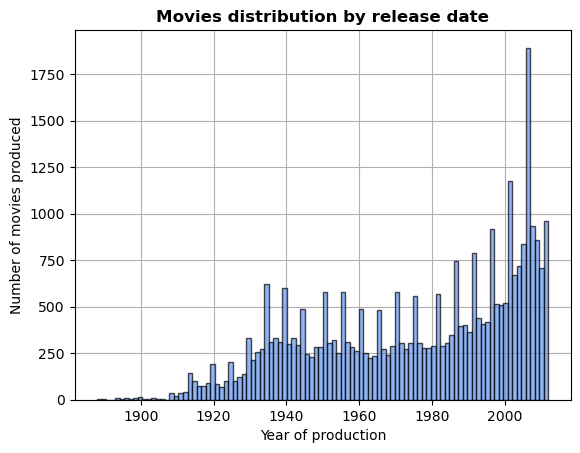

In [ ]:
# movies distribution by release date
plt.figure()
plt.title('Movies distribution by release date', weight='bold')
plt.hist(df_movies_visuals_unique['release_date'], bins= 100, **styles['hist_style'], zorder=2)
plt.xlabel('Year of production')
plt.ylabel('Number of movies produced')
plt.grid(True, zorder=0)
plt.show()

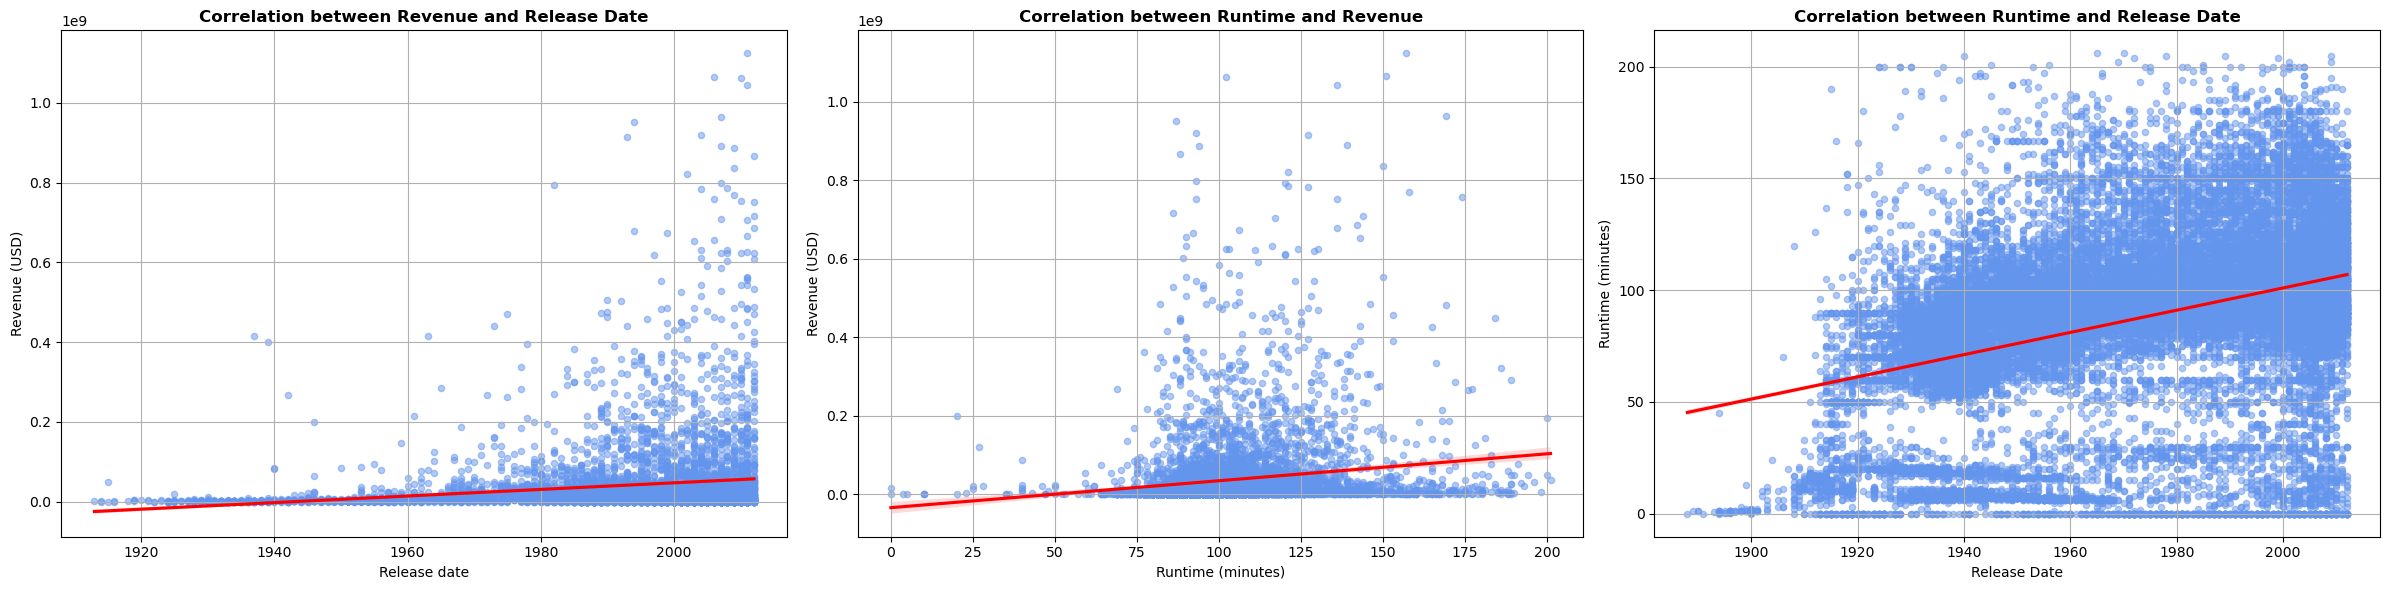

In [364]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# scatter-plot for release date vs revenue
sns.regplot(
    ax=axes[0],
    x='release_date',
    y='revenue',
    data=df_movies_visuals_unique,
    scatter_kws=styles['scatter_style'],
    line_kws=styles['line_style']
)
axes[0].set_title('Correlation between Revenue and Release Date', weight='bold')
axes[0].set_xlabel("Release date")
axes[0].set_ylabel("Revenue (USD)")
axes[0].grid(True)

# scatter-plot for runtime vs revenue
sns.regplot(
    ax=axes[1],
    x='runtime',
    y='revenue',
    data=df_movies_visuals_unique,
    scatter_kws=styles['scatter_style'],
    line_kws=styles['line_style']
)
axes[1].set_title('Correlation between Runtime and Revenue', weight='bold')
axes[1].set_xlabel("Runtime (minutes)")
axes[1].set_ylabel("Revenue (USD)")
axes[1].grid(True)

# scatter-plot for release date vs runtime
sns.regplot(
    ax=axes[2],
    x='release_date',
    y='runtime',
    data=df_movies_visuals_unique,
    scatter_kws=styles['scatter_style'],
    line_kws=styles['line_style']
)
axes[2].set_title('Correlation between Runtime and Release Date', weight='bold')
axes[2].set_xlabel("Release Date")
axes[2].set_ylabel("Runtime (minutes)")
axes[2].grid(True)

plt.tight_layout()
plt.show()

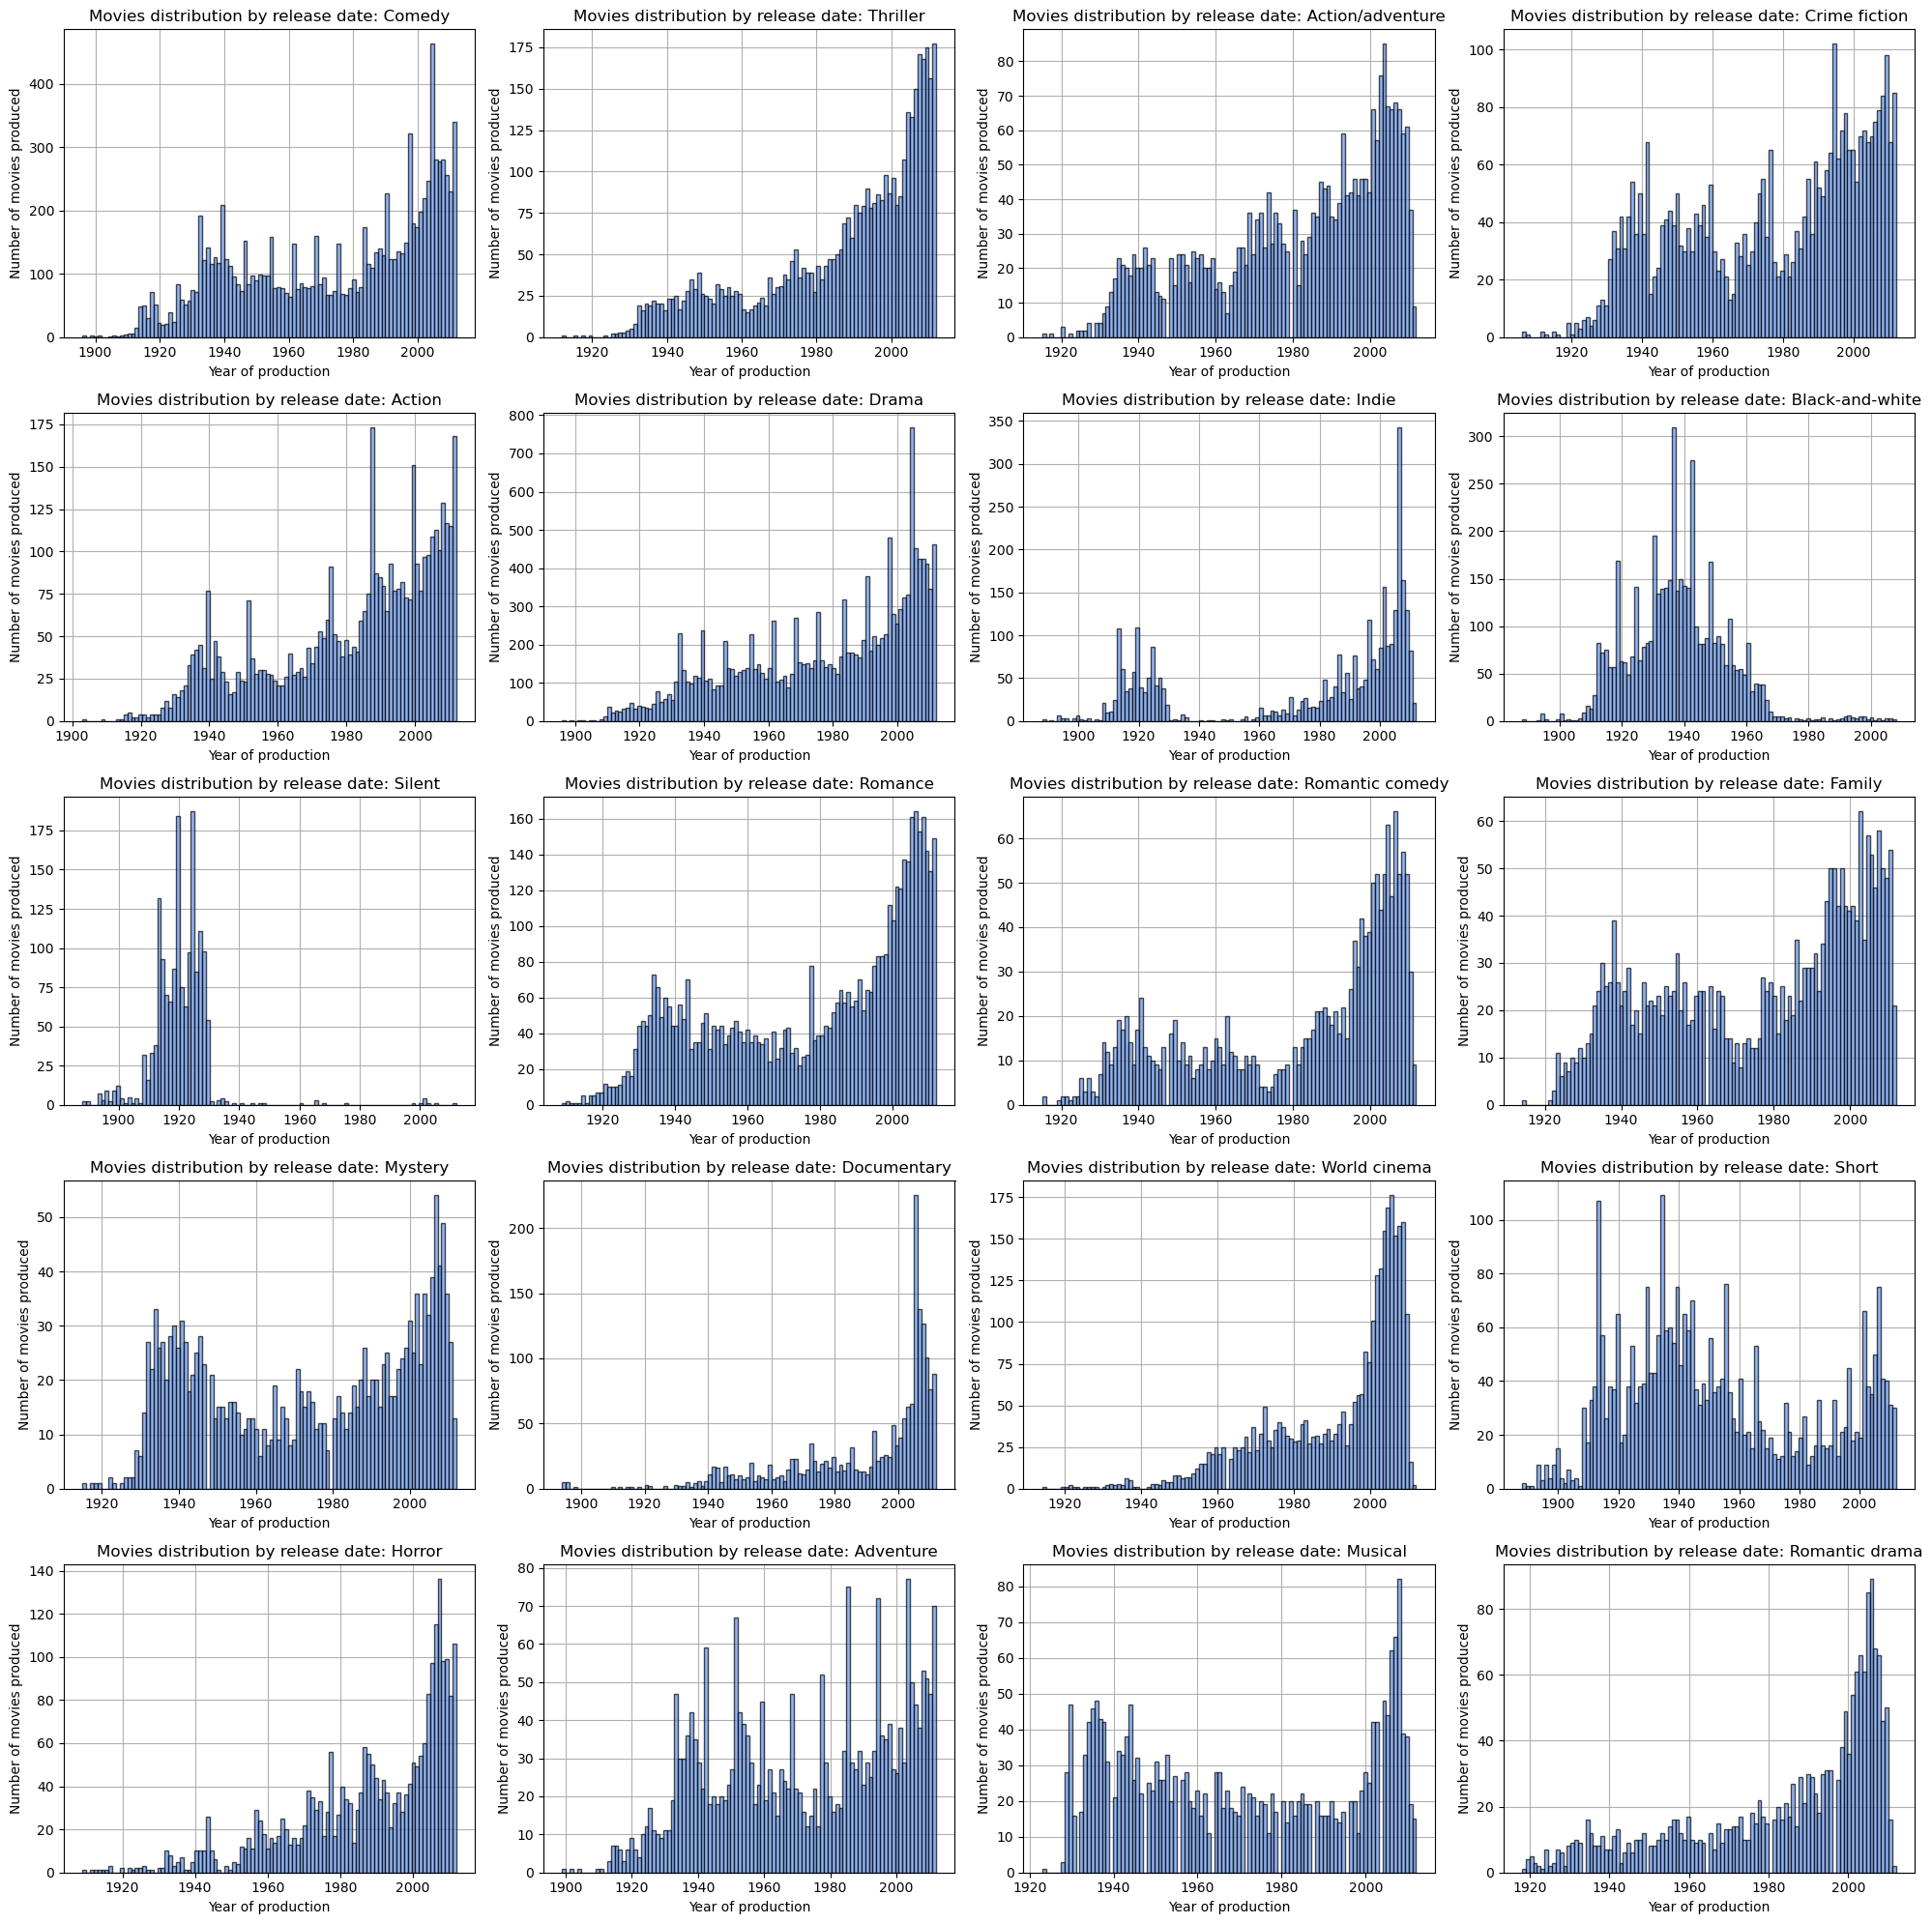

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
axes = axes.flatten()

# looping over genres
for i, genre in enumerate(df_movies_visuals['genres'].unique()):
    # selecting current axes
    ax = axes[i]
    ax.set_title(f'Movies distribution by release date: {genre}')

    # plotting the histogram for the current genre
    ax.hist(df_movies_visuals[df_movies_visuals['genres'] == genre]['release_date'], bins= 100, **styles['hist_style'], zorder=2)

    ax.set_xlabel('Year of production')
    ax.set_ylabel('Number of movies produced')
    ax.grid(True, zorder=0)

plt.tight_layout()

# 3 - Ratings Analysis

In [366]:
# copies of the master dataframes to proceed with the analysis
df_movies_ratings = df_movies_ratings_imdb.copy()
df_movies_ratings_unique = df_movies_ratings_imdb_unique.copy()

The analysis is heavily based on the `averageRating` feature. To better understand its statistics, its description is displayed.

In [367]:
# visualizing basic 'averagerating' statistics
df_movies_ratings["averageRating"].describe()

count    77948.00000
mean         6.16238
std          1.08109
min          1.10000
25%          5.60000
50%          6.30000
75%          6.90000
max          9.50000
Name: averageRating, dtype: float64

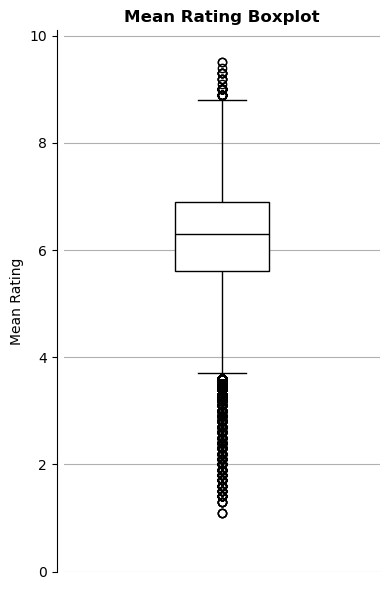

In [368]:
plt.figure(figsize=(4, 6))
ax = sns.boxplot(data=df_movies_ratings['averageRating'], **styles['boxplot_style'])

# box-plotting the 'mean_rating' column
sns.despine(offset=5, trim=False, bottom=True)
plt.title('Mean Rating Boxplot', weight='bold')
plt.xticks([])
plt.ylim([0,10.1])
plt.ylabel("Mean Rating", fontsize=10)
plt.grid(True)

plt.tight_layout()

As expected, the movie ratings are approximately normally distributed with equivalent whisker sizes in the above boxplot and a median centered about at the centre of the IQR. Many outliers are observed, however we will not consider these as outliers given the data exists over a ten point scale and no extreme values greatly drive skew in the movies ratings. The plot below provides further information on the mean movie ratings distribution.

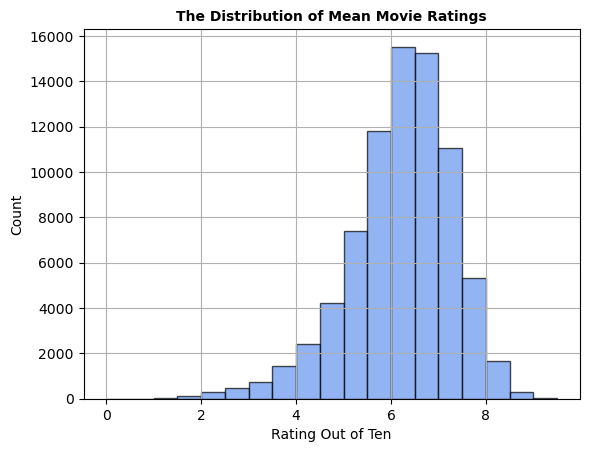

In [369]:
# defining bins
bin_edges = np.arange(0, df_movies_ratings['averageRating'].max() + 0.5, 0.5)

plt.hist(df_movies_ratings['averageRating'].values, bins = bin_edges, **styles['hist_style'])
plt.title("The Distribution of Mean Movie Ratings", weight='bold', fontsize=10)
plt.xlabel('Rating Out of Ten', fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.grid(True)

Since even through this visualization the distribution resembles a normal one, some test to verify this hypothesis are run below.

In [370]:
diagnostic.kstest_normal(df_movies_ratings['averageRating'].values, dist = 'norm')

(0.07208240893274553, 0.0009999999999998899)

Although the mean rating normality test returns a low p-value, visual inspections of the ratings distribution lead to a different conclusion. Therefore, a Q-Q plot is also employed to further assess normality.

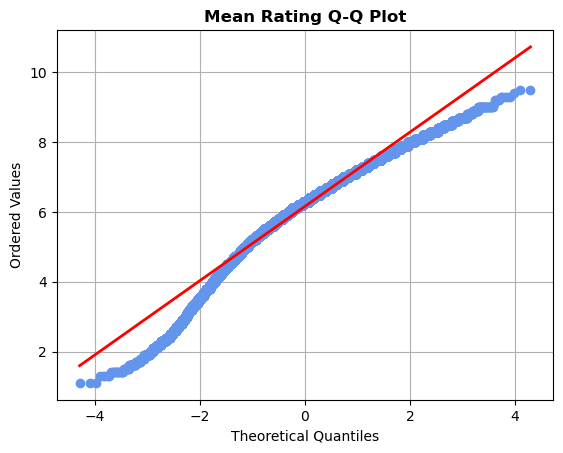

In [371]:
# ploting Q-Q test
fig, ax = plt.subplots()
res = stats.probplot(df_movies_ratings['averageRating'].values, dist="norm", plot=ax)

# line settings
ax.get_lines()[0].set_color('cornflowerblue') 
ax.get_lines()[0].set_linewidth(2)
ax.get_lines()[1].set_color('red') 
ax.get_lines()[1].set_linewidth(2)

plt.title("Mean Rating Q-Q Plot", weight='bold')
plt.xlabel("Theoretical Quantiles", fontsize=10)
plt.ylabel("Ordered Values", fontsize=10)
plt.grid(True)

Given the central portion of the Q-Q plot is flatter and the edges steeper, we again conclude that mean ratings is approximately normally distributed but there are more datapoints aggregated about the mean than there would be in the case of a normal distribution.

Now, a closer look to genres preferences is presented. The objective is to visualize if the mean movie rating changes, based on the movie genre.

Text(50.72222222222221, 0.5, 'Genres')

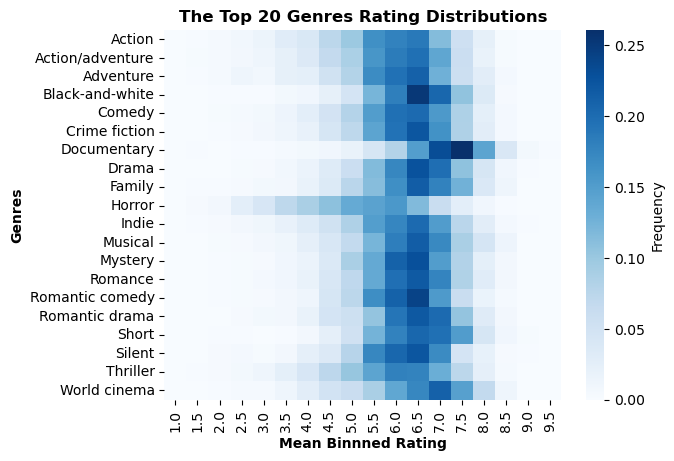

In [372]:
# making the mean of each movie's rating an increment of 0.5
df_movies_ratings["binned_rating"] = df_movies_ratings["averageRating"].apply(lambda x: round(x*2)/2)

df_genres_meanratings = pd.crosstab(df_movies_ratings['genres'], df_movies_ratings['binned_rating'], normalize='index')

# creating an heatmap among the genres
ax = plt.axes()
sns.heatmap(df_genres_meanratings, annot=False, cmap='Blues', ax = ax, cbar_kws={'label': 'Frequency'})
ax.set_title('The Top 20 Genres Rating Distributions', weight='bold')
ax.set_xlabel('Mean Binnned Rating', weight='bold')
ax.set_ylabel('Genres', weight='bold')

The top 20 genres reported in the CMU dataset all have approximately normal distributions with peaks (means) between the 4.5 and 7.5 rating bins, as expected given the population's mean rating of 6. Noticeably, horror and science fiction movies have comparatively stronger left-skews than the other main genres for ratings.

Since no evident movie genre preference has been found, other parameters are compared to the mean rating, to find correlations. For example, runtime and release date.

This is obviously difficult to visualize, so a density plot is used instead.

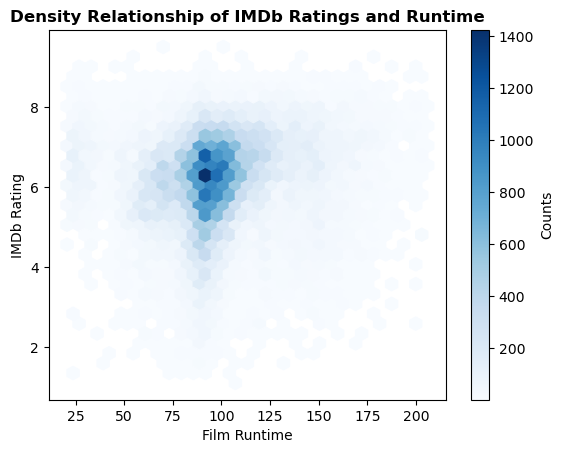

In [373]:
# plotting the relationship between movies with reasonable runtimes (over 20 minutes, despite short films
# having lesser time than this as there are many incorrect runtimes observed under 20 minutes) and mean rating
df_movies_ratings_runtimes = df_movies_ratings[df_movies_ratings['runtime'] > 20.0]

plt.hexbin(df_movies_ratings_runtimes["runtime"], df_movies_ratings_runtimes["averageRating"], gridsize=30, cmap="Blues", mincnt=1)
plt.colorbar(label="Counts")
plt.xlabel("Film Runtime")
plt.ylabel("IMDb Rating")
plt.title("Density Relationship of IMDb Ratings and Runtime", weight='bold')
plt.show()

This relationship per genre would also be interesting.

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


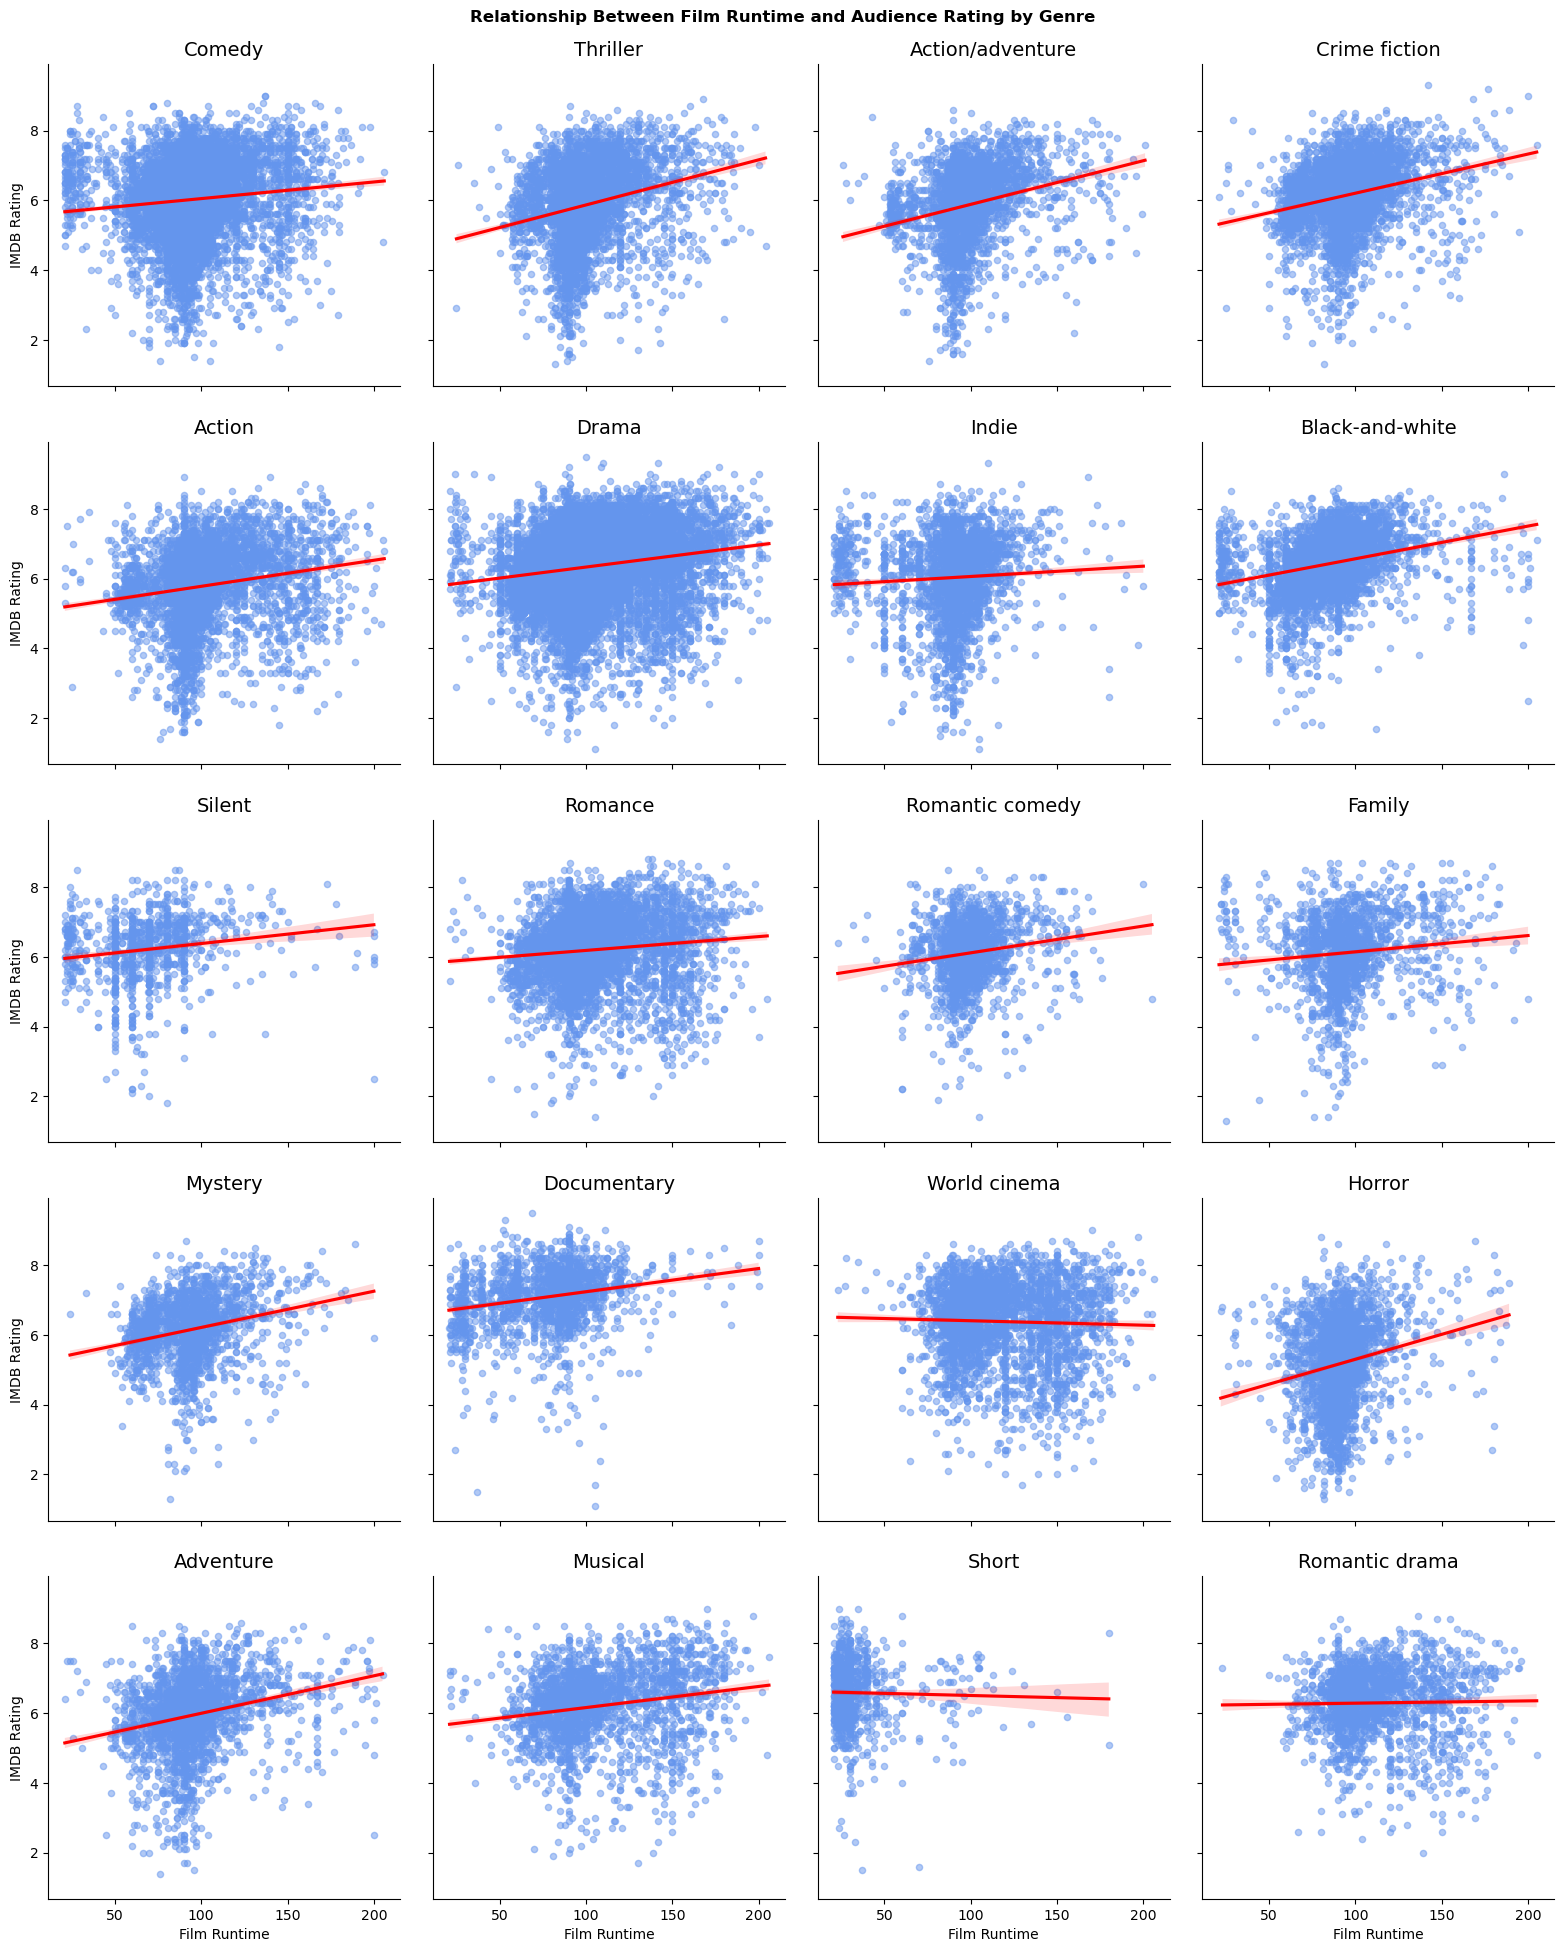

In [587]:
# preparing a grid of scatter plots with regression lines for each genre
seperated_genres = sns.FacetGrid(df_movies_ratings_runtimes, col="genres", col_wrap=4, height=4, sharex=True, sharey=True)

# mapping the regression plot
seperated_genres.map(sns.regplot, "runtime", "averageRating", scatter_kws=styles['scatter_style'], line_kws=styles['line_style'])

seperated_genres.set_axis_labels("Film Runtime", "IMDB Rating")
seperated_genres.fig.suptitle("Relationship Between Film Runtime and Audience Rating by Genre", weight='bold')
seperated_genres.set_titles("{col_name}", size=14)

seperated_genres.tight_layout(pad=2)
plt.show()

In [375]:
# calculating Pearson correlation
pearson_corr, pearson_p = pearsonr(df_movies_ratings_runtimes['runtime'], df_movies_ratings_runtimes['averageRating'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# calculating Spearman correlation
spearman_corr, spearman_p = spearmanr(df_movies_ratings_runtimes['runtime'], df_movies_ratings_runtimes['averageRating'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

Pearson correlation: 0.1222, p-value: 0.0000
Spearman correlation: 0.1767, p-value: 0.0000


The same plots can been computed to compare the rating and the release date.

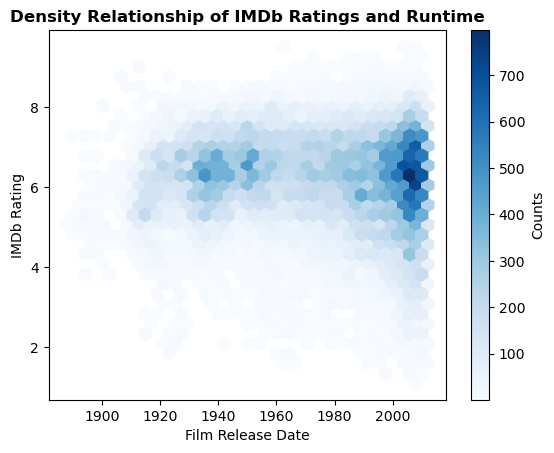

In [376]:
# hexbin() map of retings and runtime
plt.hexbin(df_movies_ratings["release_date"], df_movies_ratings["averageRating"], gridsize=30, cmap="Blues", mincnt=1)
plt.colorbar(label="Counts")
plt.xlabel("Film Release Date")
plt.ylabel("IMDb Rating")
plt.title("Density Relationship of IMDb Ratings and Runtime", weight='bold')
plt.show()

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


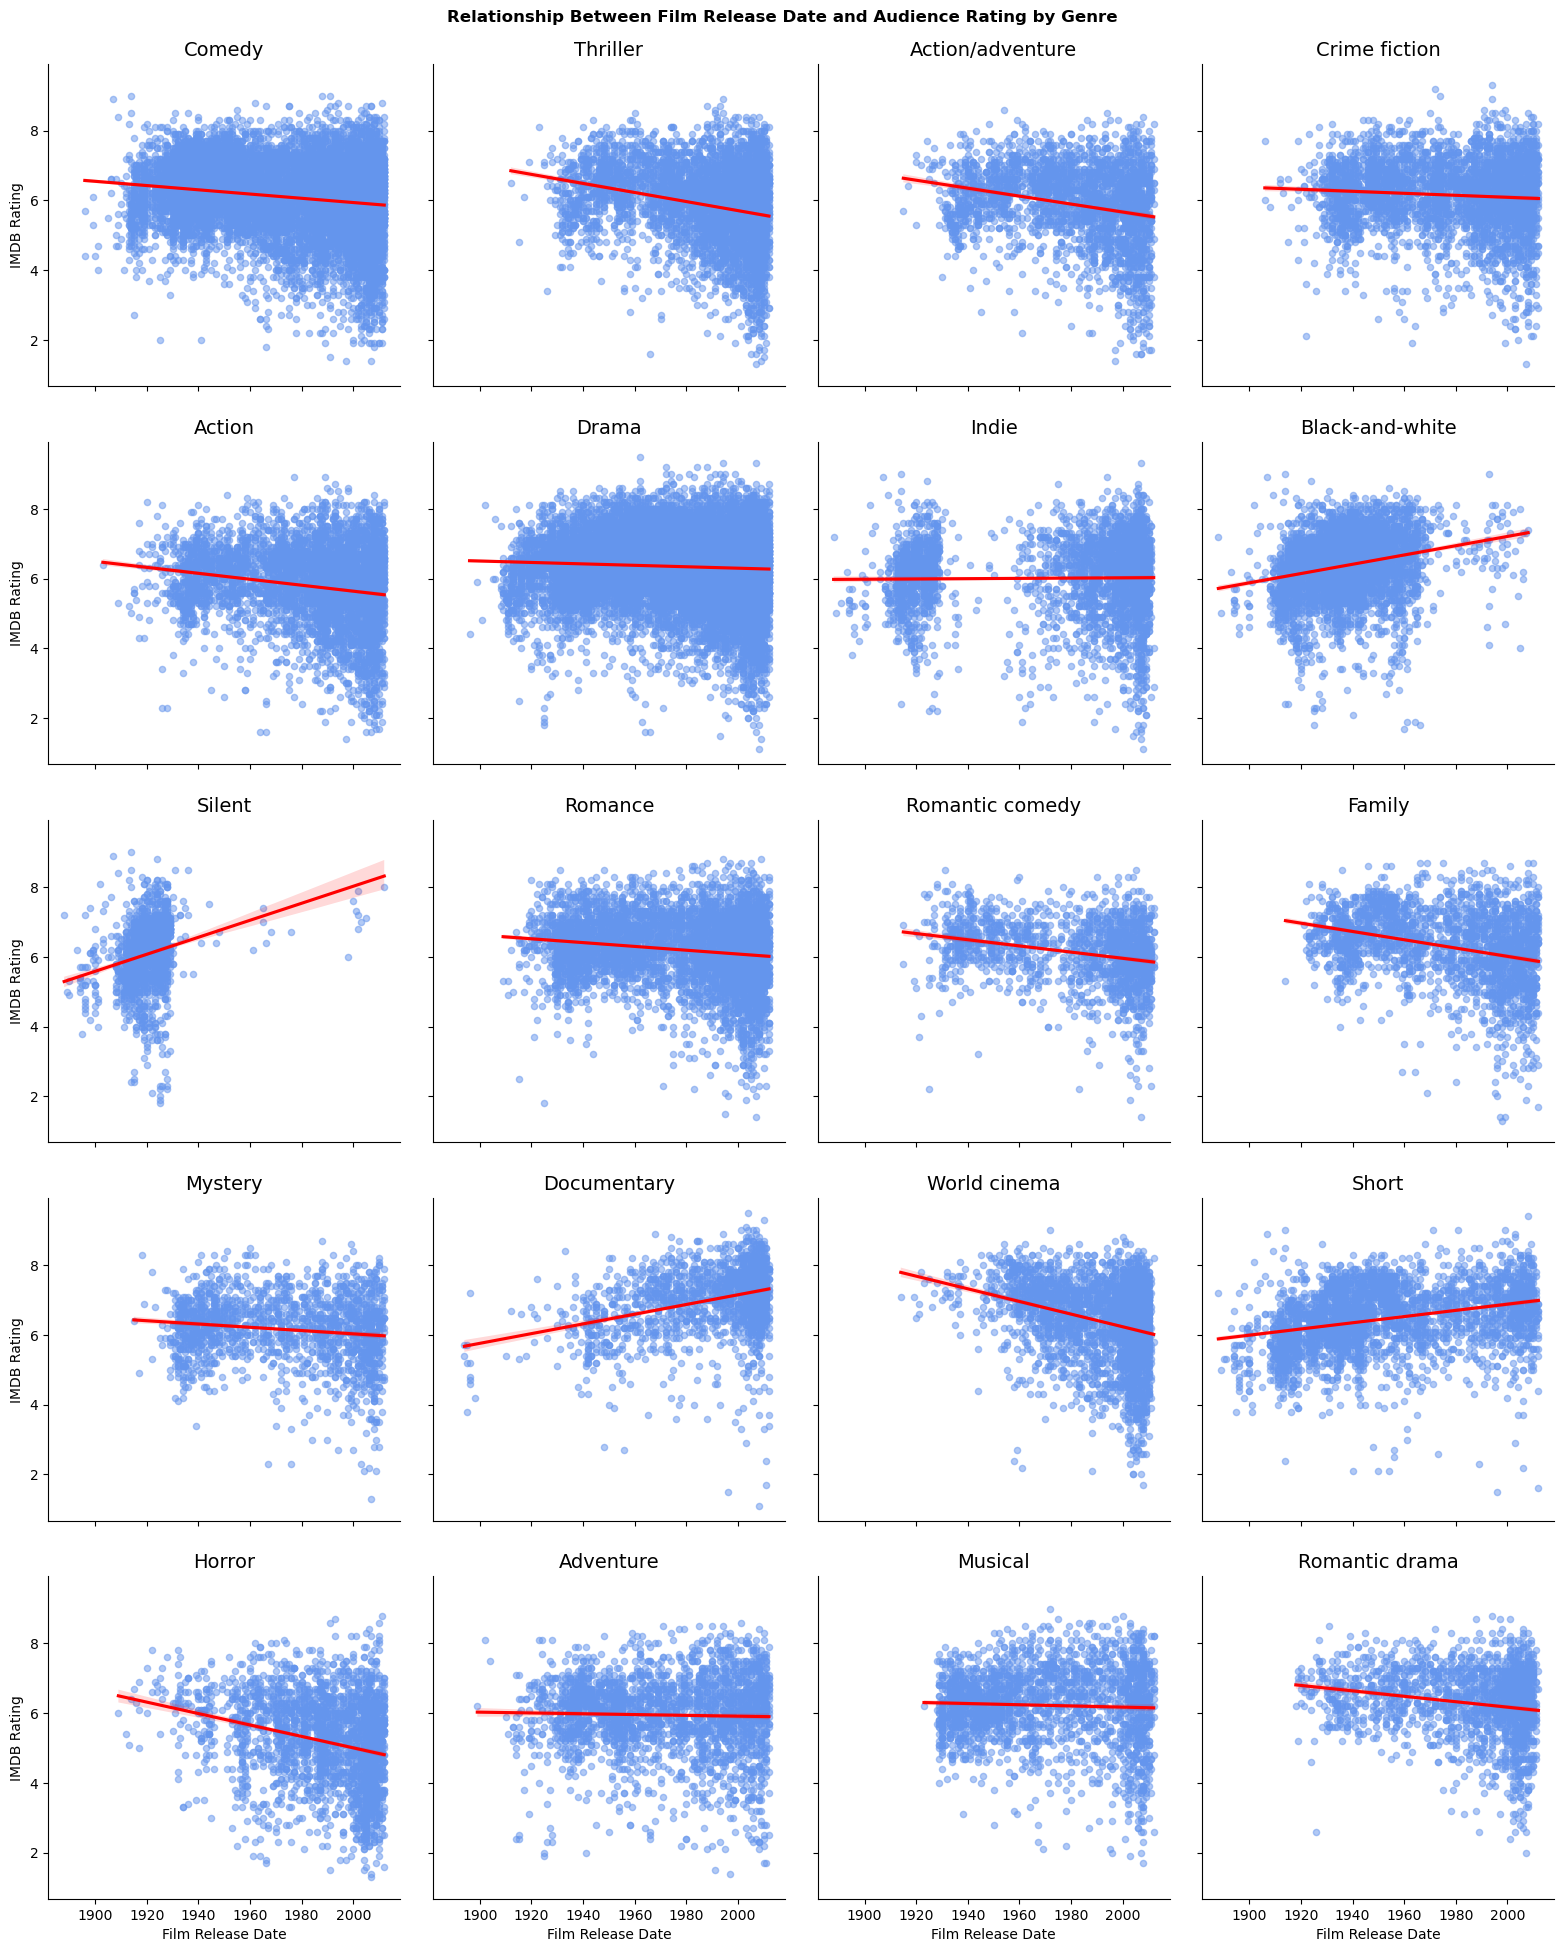

In [588]:
# preparing a grid of scatter plots with regression lines for each genre
seperated_genres = sns.FacetGrid(df_movies_ratings, col="genres", col_wrap=4, height=4, sharex=True, sharey=True)

# mapping the regression plot
seperated_genres.map(sns.regplot, "release_date", "averageRating", scatter_kws=styles['scatter_style'], line_kws=styles['line_style'])

seperated_genres.set_axis_labels("Film Release Date", "IMDB Rating")
seperated_genres.fig.suptitle("Relationship Between Film Release Date and Audience Rating by Genre", weight='bold')
seperated_genres.set_titles("{col_name}", size=14)

seperated_genres.tight_layout(pad=2)
plt.show()

In [ ]:
# calculating Pearson correlation
pearson_corr, pearson_p = pearsonr(df_movies_ratings['release_date'], df_movies_ratings['averageRating'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# calculating Spearman correlation
spearman_corr, spearman_p = spearmanr(df_movies_ratings['release_date'], df_movies_ratings['averageRating'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

Pearson correlation: -0.1029, p-value: 0.0000
Spearman correlation: -0.0858, p-value: 0.0000


## 3.1 - Film ratings across regions and genres, over time

In [379]:
# identifying if any country does not have a particular genre
for genre in top_20_genres:
    # indentifying unique regions for the current genre
    regions_with_genre = df_movies_ratings[df_movies_ratings["genres"] == genre]["region"].unique()

    # converting .tolist()
    regions_with_genre = regions_with_genre.tolist()

    # checking if the total number of regions for the current genre is equal to the total number of regions (9)
    if len(regions_with_genre) < 9:
        for region in list(regions.keys()):
            if region not in regions_with_genre:
                print(f"The geographical region {region} does not have a movie for the genre {genre}.")

The geographical region South Africa and Central Africa does not have a movie for the genre Black-and-white.
The geographical region North Africa and Middle East does not have a movie for the genre Indie.
The geographical region South Africa and Central Africa does not have a movie for the genre Musical.
The geographical region South Africa and Central Africa does not have a movie for the genre Silent.
The geographical region North Africa and Middle East does not have a movie for the genre Silent.


In [380]:
# filling a copy dataframe with blank movie(s) for the missing genre(s) of any geographic region, to ensure no errors when plotting below
df_movies_ratings_regionfilled = df_movies_ratings.copy()

df_movies_ratings_regionfilled = filling.fill_missing_regions(
    df_movies_ratings_regionfilled,
    top_20_genres,    
    list(regions.keys())      
)

In [381]:
# checking if any country does not have a particular genre again, which shouldn't be the case
for genre in top_20_genres:
    # indentifying unique regions for the current genre
    regions_with_genre = df_movies_ratings_regionfilled[df_movies_ratings_regionfilled["genres"] == genre]["region"].unique()

    # converting .tolist()
    regions_with_genre = regions_with_genre.tolist()
    if len(regions_with_genre) < 9:
        for region in list(regions.keys()):
            if region not in regions_with_genre:
                print(f"The geographical region {region} does not have a movie for the genre {genre}.")
    else:
        print(f"Every region has at least one {genre} movie.")

Every region has at least one Drama movie.
Every region has at least one Comedy movie.
Every region has at least one Romance movie.
Every region has at least one Black-and-white movie.
Every region has at least one Action movie.
Every region has at least one Thriller movie.
Every region has at least one Crime fiction movie.
Every region has at least one Indie movie.
Every region has at least one Short movie.
Every region has at least one World cinema movie.
Every region has at least one Action/adventure movie.
Every region has at least one Horror movie.
Every region has at least one Adventure movie.
Every region has at least one Family movie.
Every region has at least one Musical movie.
Every region has at least one Documentary movie.
Every region has at least one Romantic drama movie.
Every region has at least one Mystery movie.
Every region has at least one Romantic comedy movie.
Every region has at least one Silent movie.


In [382]:
# computing mean ratings and confidence intervals
mean_ratings, confidence_intervals = ratings_statistics.calculate_genre_statistics(
    df_movies_ratings_regionfilled,
    top_20_genres,
    list(regions.keys())
)

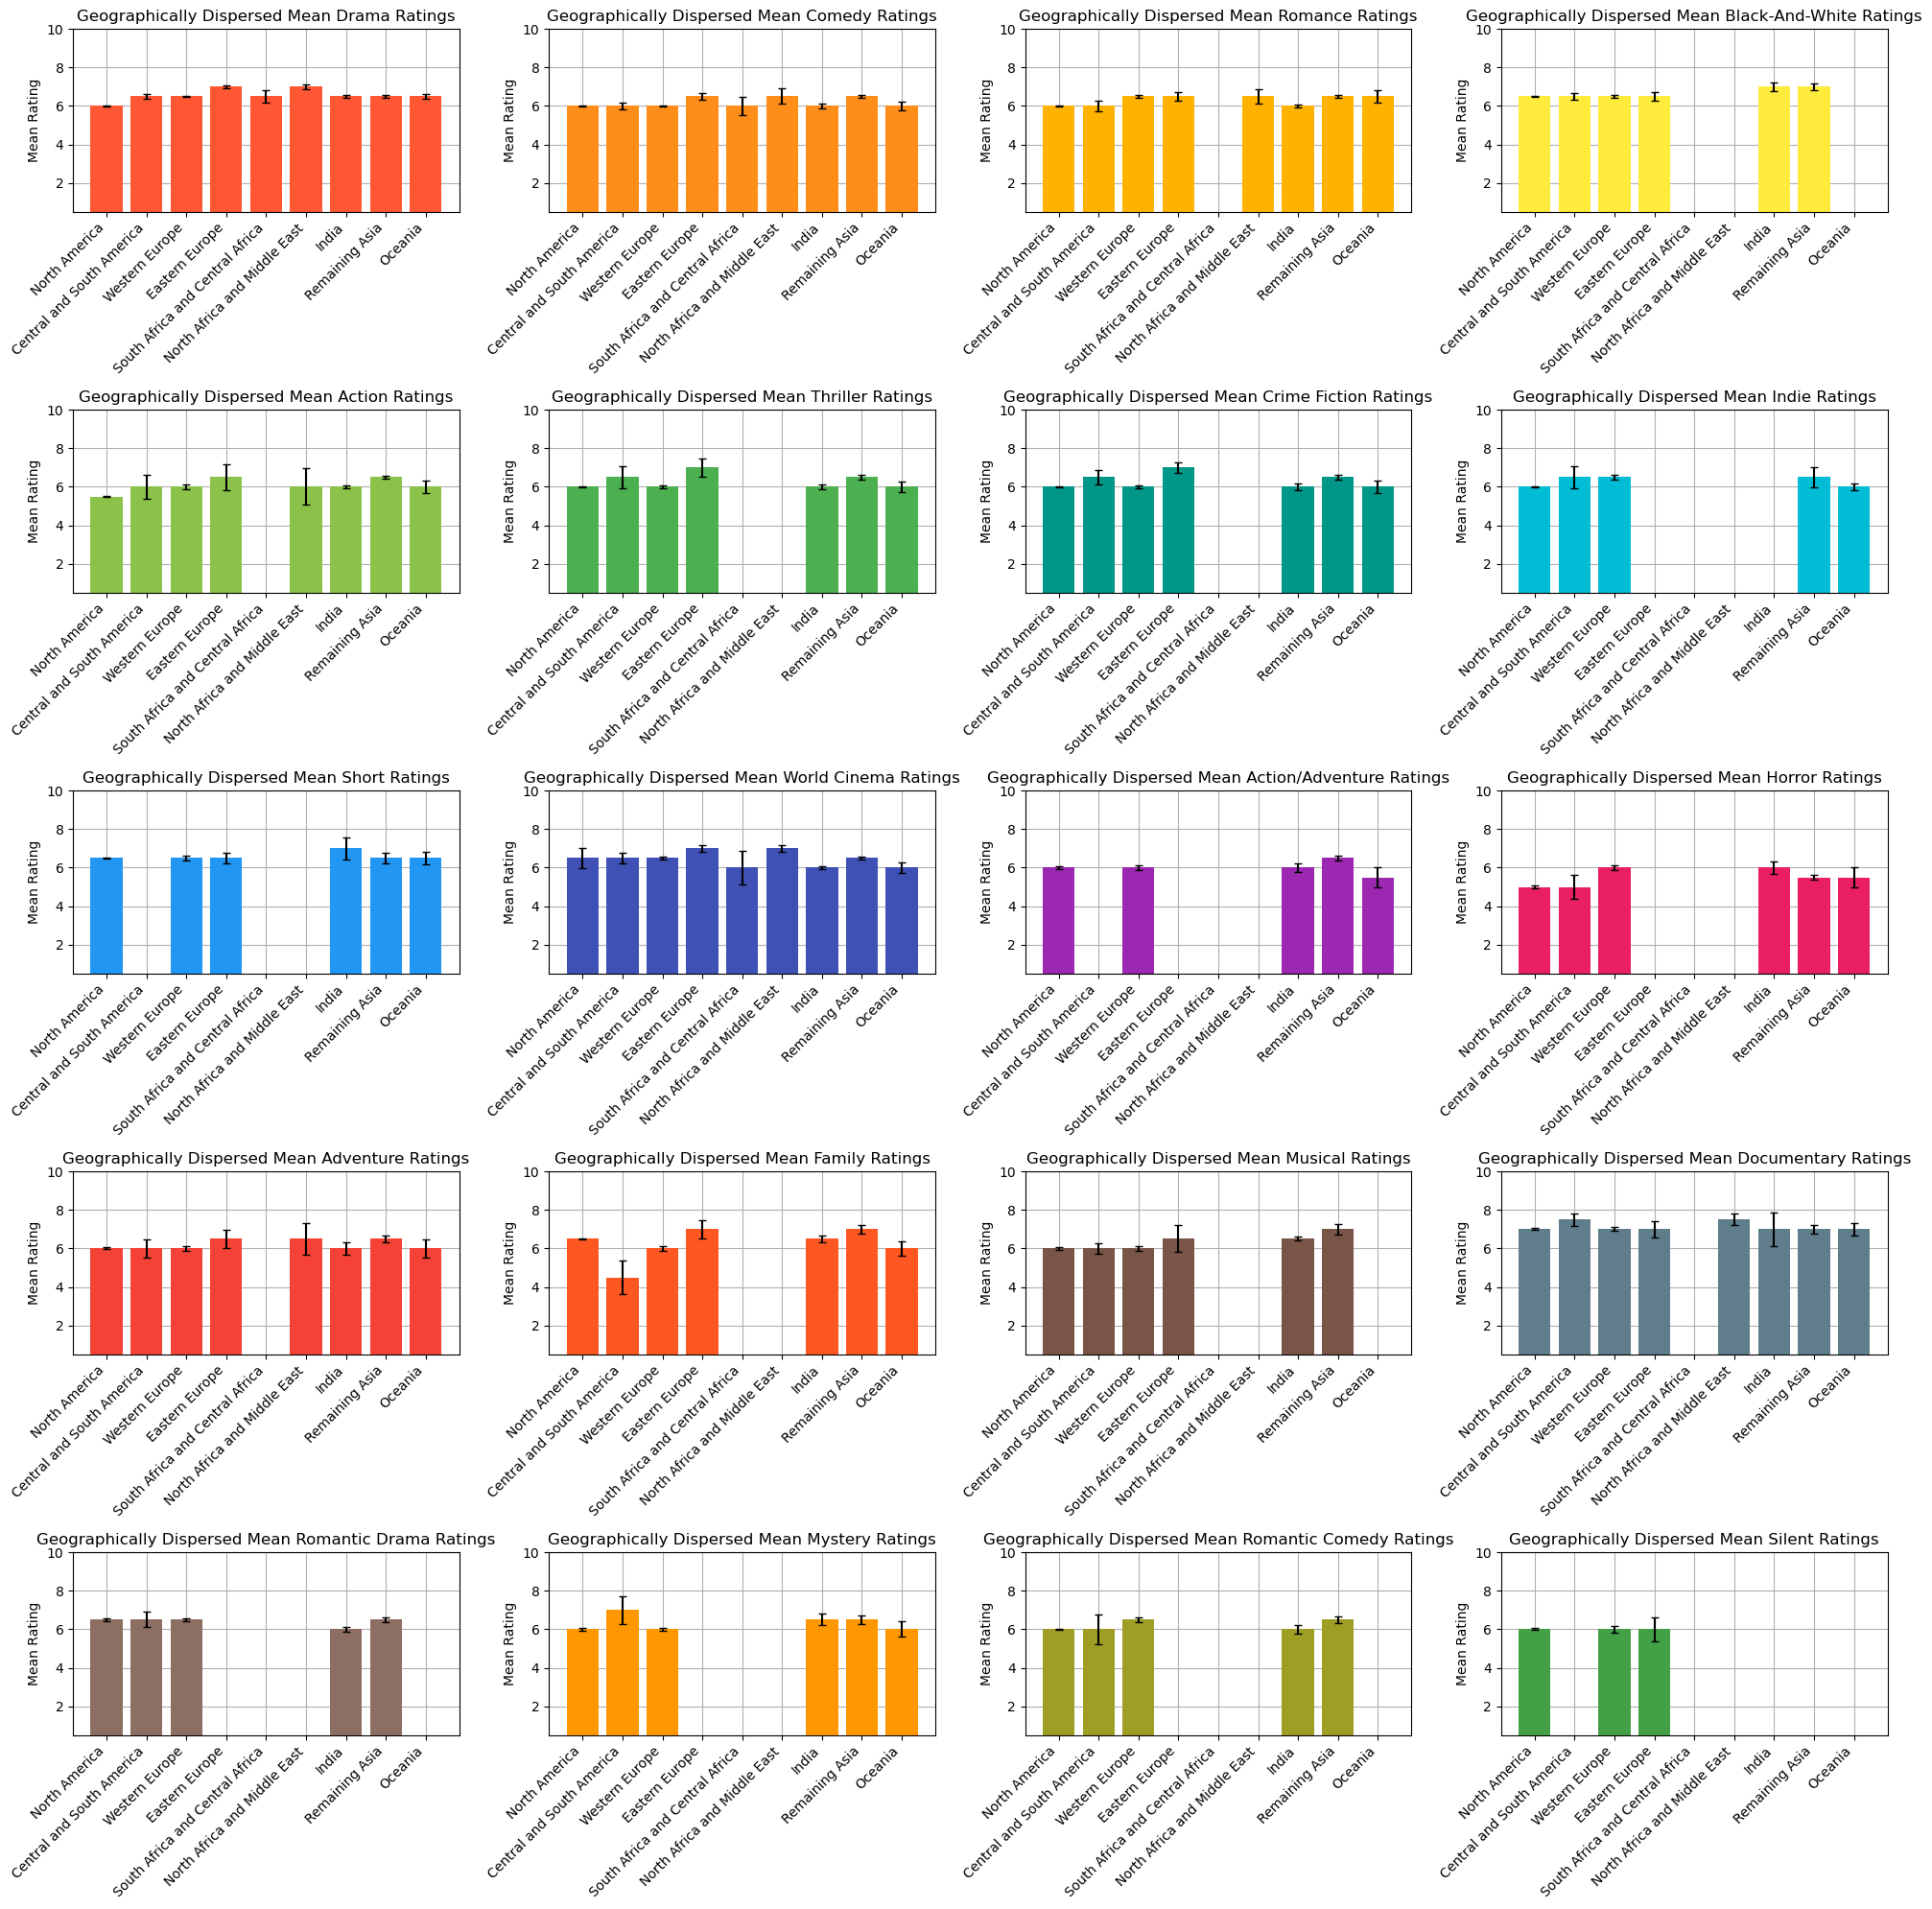

In [383]:
# creating a 5x4 grid for the subplots to fit 20 genres
fig, axes = plt.subplots(5, 4, figsize=(20, 20))
axes = axes.flatten()

# plotting each genre in the corresponding subplot
for i, genre in enumerate(top_20_genres):
    axes[i].bar(range(len(list(regions.keys()))), mean_ratings[genre], yerr=confidence_intervals[genre], capsize=3, color=genres_colors[i], zorder=2)

    axes[i].grid(True, zorder=0)
    axes[i].set_xticks(range(len(list(regions.keys()))))
    axes[i].set_xticklabels(list(regions.keys()), rotation=45, ha='right')
    axes[i].set_title(f"Geographically Dispersed Mean {genre.title()} Ratings")
    axes[i].set_ylabel("Mean Rating")
    axes[i].set_ylim(0.5, 10)

plt.tight_layout()
plt.show()

Now we want to explore how within each geographical region the mean ratings of movies by genre differ.

In [384]:
# computing mean ratings and confidence intervals
mean_ratings, confidence_intervals = ratings_statistics.calculate_region_statistics(
    df_movies_ratings_regionfilled,
    list(regions.keys()),
    top_20_genres
)

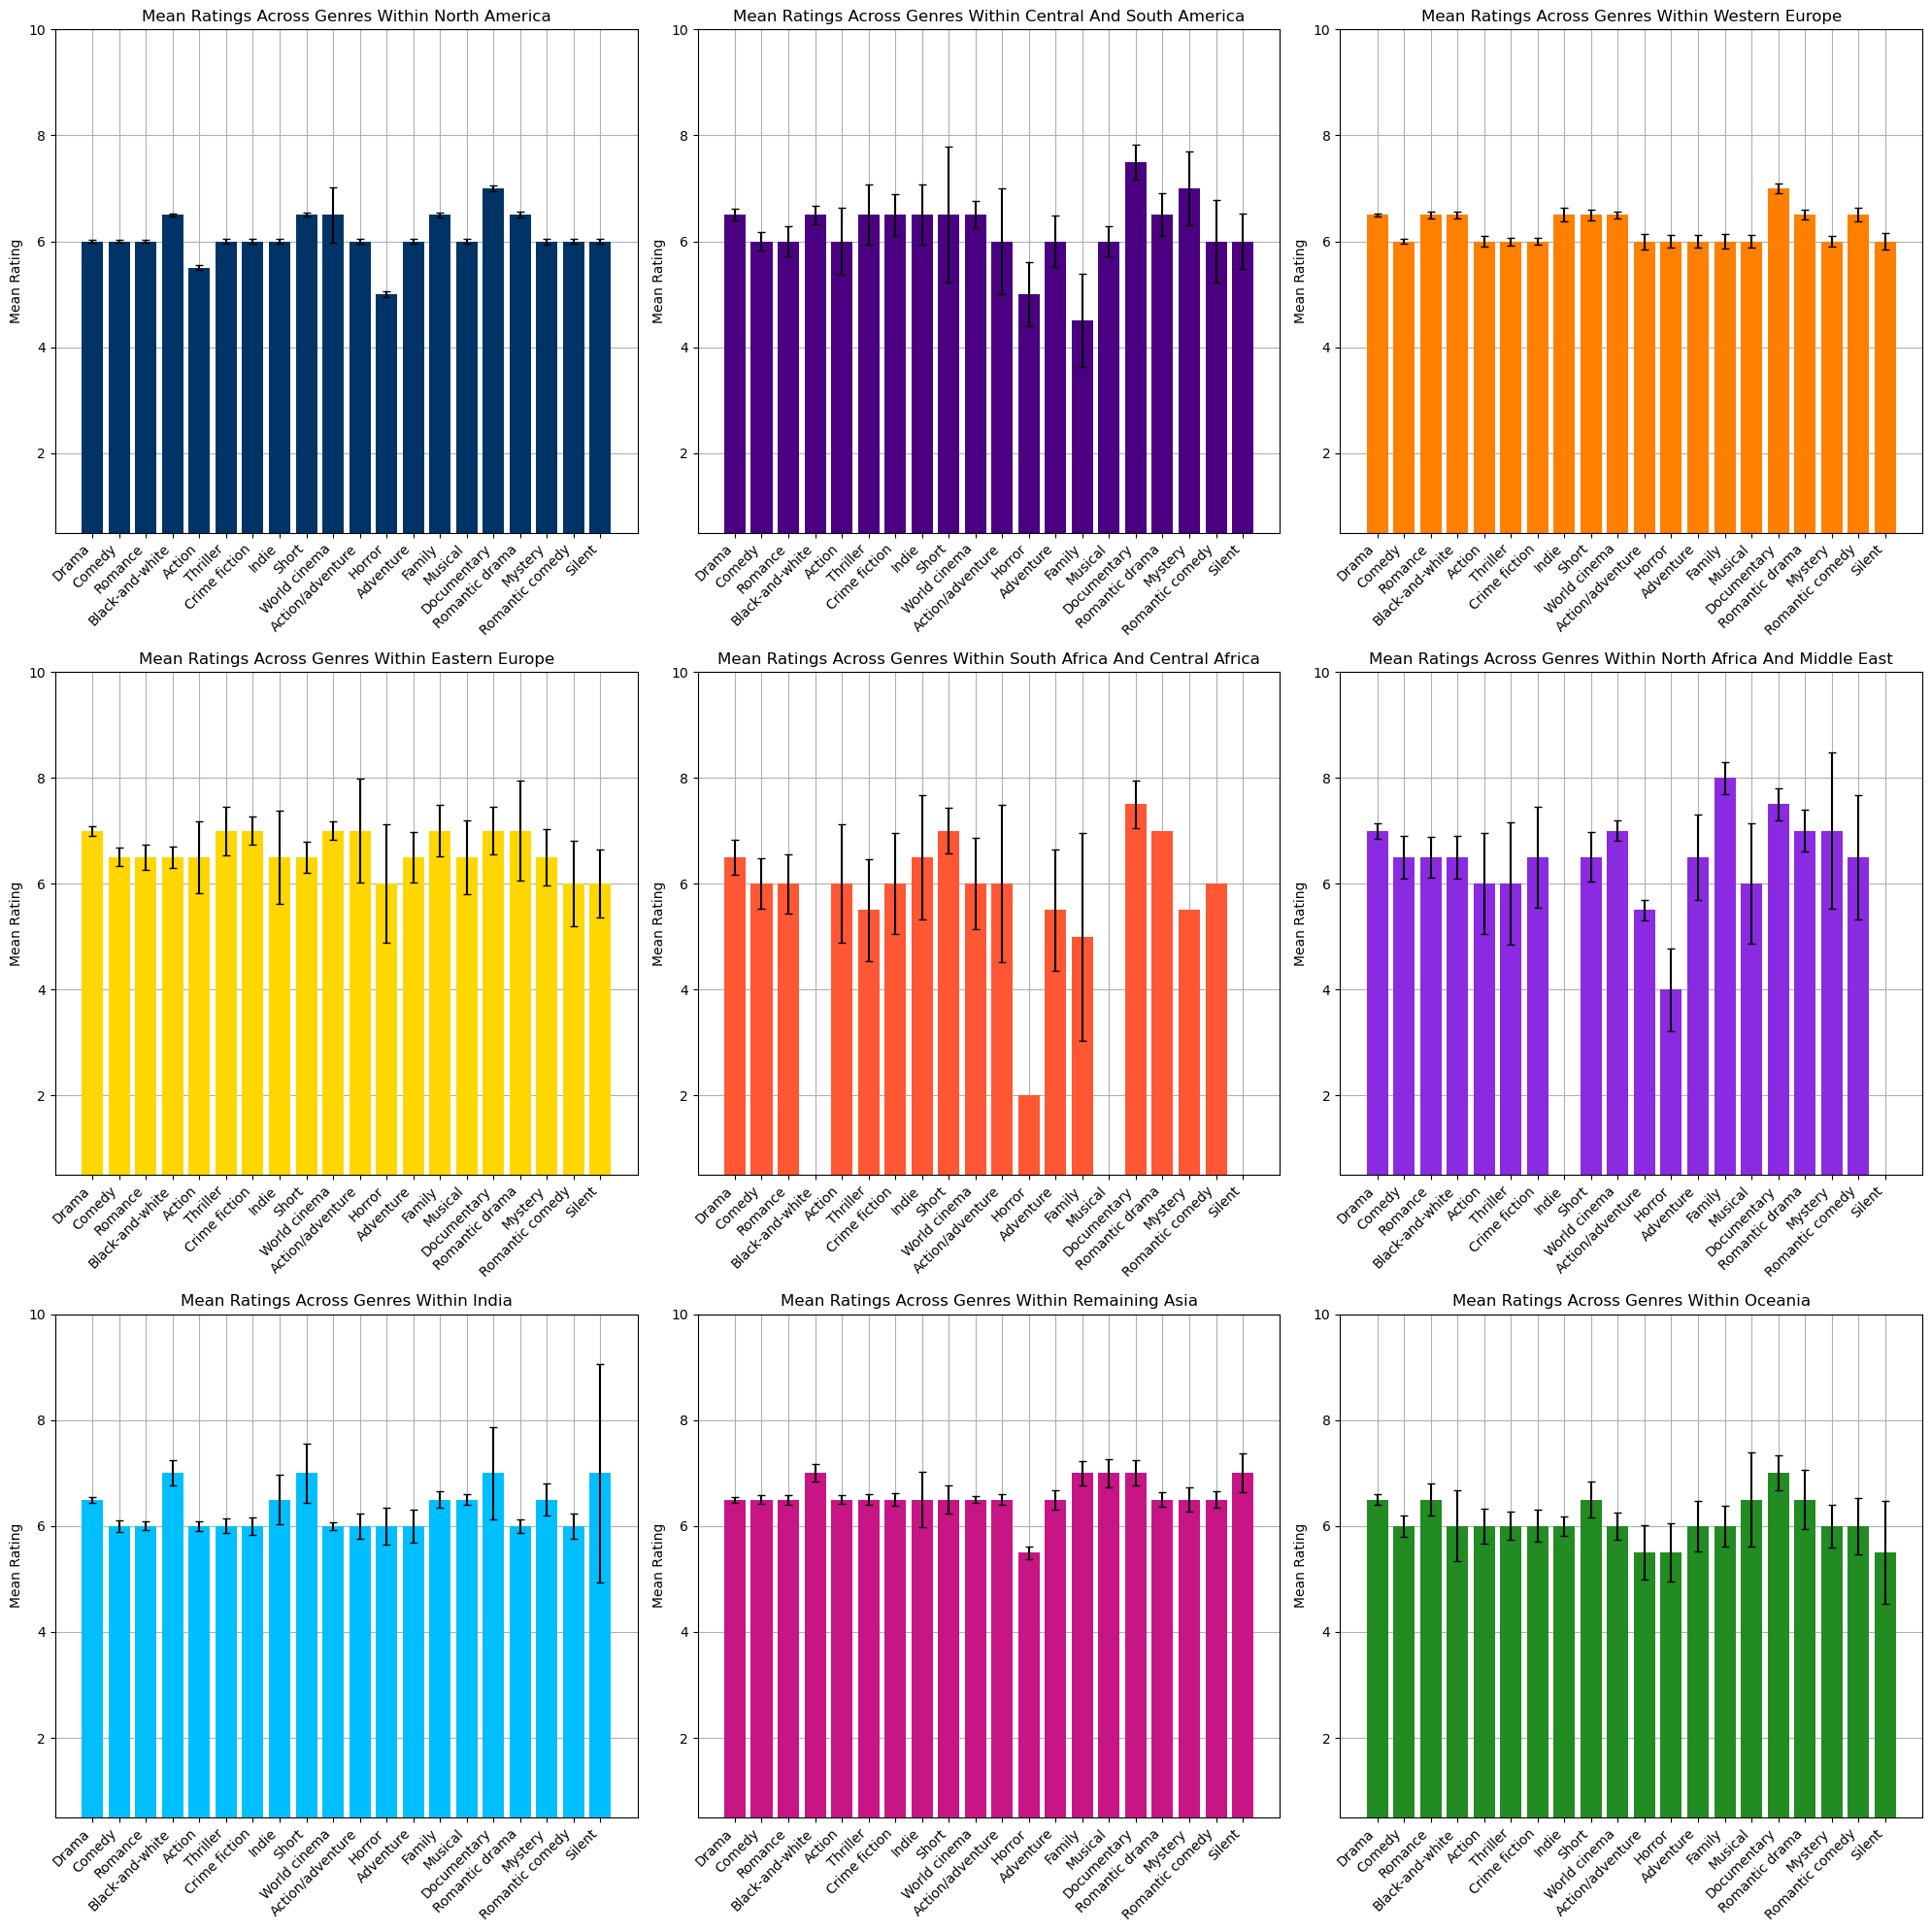

In [385]:
# creating a 3x3 grid for the subplots to fit 9 regions
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()

# plotting each genre in the corresponding subplot
for i, region in enumerate(list(regions.keys())):
    axes[i].bar(range(len(top_20_genres)), mean_ratings[region], yerr=confidence_intervals[region], capsize=3, color=regions_colors[i], zorder=2)

    axes[i].grid(True, zorder=0)
    axes[i].set_xticks(range(len(top_20_genres)))
    axes[i].set_xticklabels(top_20_genres, rotation=45, ha='right')
    axes[i].set_title(f"Mean Ratings Across Genres Within {region.title()}")
    axes[i].set_ylabel("Mean Rating")
    axes[i].set_ylim(0.5, 10)

plt.tight_layout()
plt.show()

Now we want to observe how the mean rating per genre per region changes over time.

In [386]:
# creating a dataframe copy
df_movies_ratings_region_decadefilled = df_movies_ratings_regionfilled.copy()

# binning movies into the decade in which they were released
df_movies_ratings_region_decadefilled["decade"] = df_movies_ratings_region_decadefilled["release_date"].apply(
    cleaning.categorize_decade)

# dropping missing decade entries
df_movies_ratings_region_decadefilled.dropna(subset=['decade'], inplace=True)

In [387]:
# defining the decades of interest
decades = ["1950", "1960", "1970", "1980", "1990", "2000"]

In [388]:
# blank movie(s) for the missing genre(s) of any geographic region in any deacde are required, to ensure no errors when plotting below
df_movies_ratings_region_decadefilled = filling.fill_missing_decades(
    df_movies_ratings_region_decadefilled,
    top_20_genres,               
    list(regions.keys()),                         
    decades               
)

In [389]:
# computing mean ratings and confidence intervals
mean_ratings, confidence_intervals = ratings_statistics.calculate_region_decade_statistics(
    df_movies_ratings_region_decadefilled,
    list(regions.keys()),
    top_20_genres,
    decades  
)

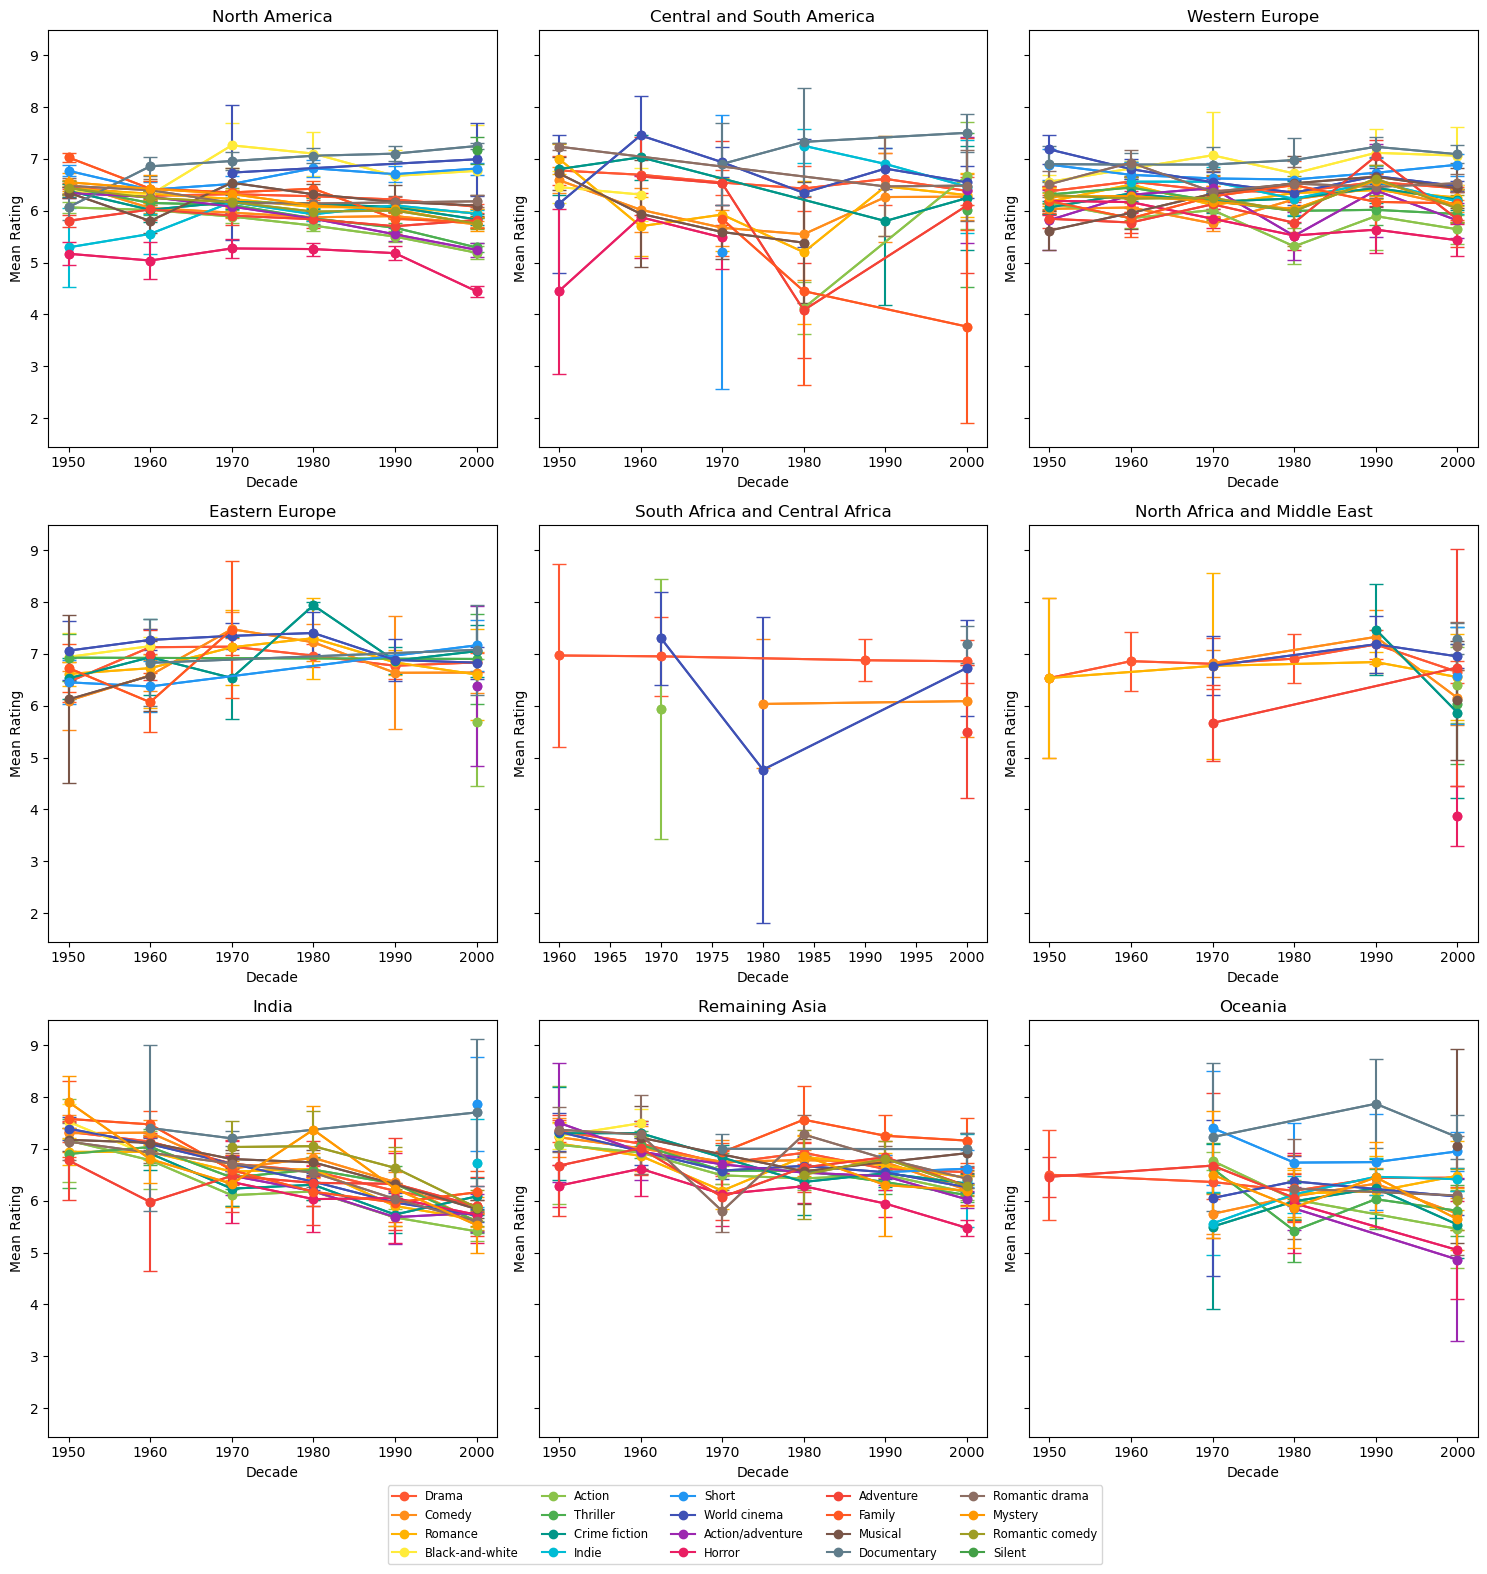

In [390]:
# plotting the results
ratings_visualizations.plot_region_genre_ratings(
    mean_ratings,           
    confidence_intervals,   
    decades,                
    top_20_genres,     
    genres_colors                  
)

The above is great but with 20 genres, quite hard to visualize. Let's focus on the top 6 genres to make the observations more readable, recycling the code from above.

In [391]:
# getting the top 6 genres as a list
top_6_genres = df_movies_ratings_imdb['genres'].value_counts().head(6).index.tolist()

In [392]:
# creating a dataframe copy
df_movies_ratings_region_decadefilled = df_movies_ratings_regionfilled.copy()

# binning movies into the decade in which they were released
df_movies_ratings_region_decadefilled["decade"] = df_movies_ratings_region_decadefilled["release_date"].apply(
    cleaning.categorize_decade)

# dropping missing decade entries
df_movies_ratings_region_decadefilled.dropna(subset=['decade'], inplace=True)

In [393]:
# blank movie(s) for the missing genre(s) of any geographic region in any deacde are required, to ensure no errors when plotting below
df_movies_ratings_region_decadefilled = filling.fill_missing_decades(
    df_movies_ratings_region_decadefilled,
    top_6_genres,               
    list(regions.keys()),                         
    decades               
)

In [394]:
# computing mean ratings and confidence intervals
mean_ratings, confidence_intervals = ratings_statistics.calculate_region_decade_statistics(
    df_movies_ratings_region_decadefilled,
    list(regions.keys()),
    top_6_genres,
    decades  
)

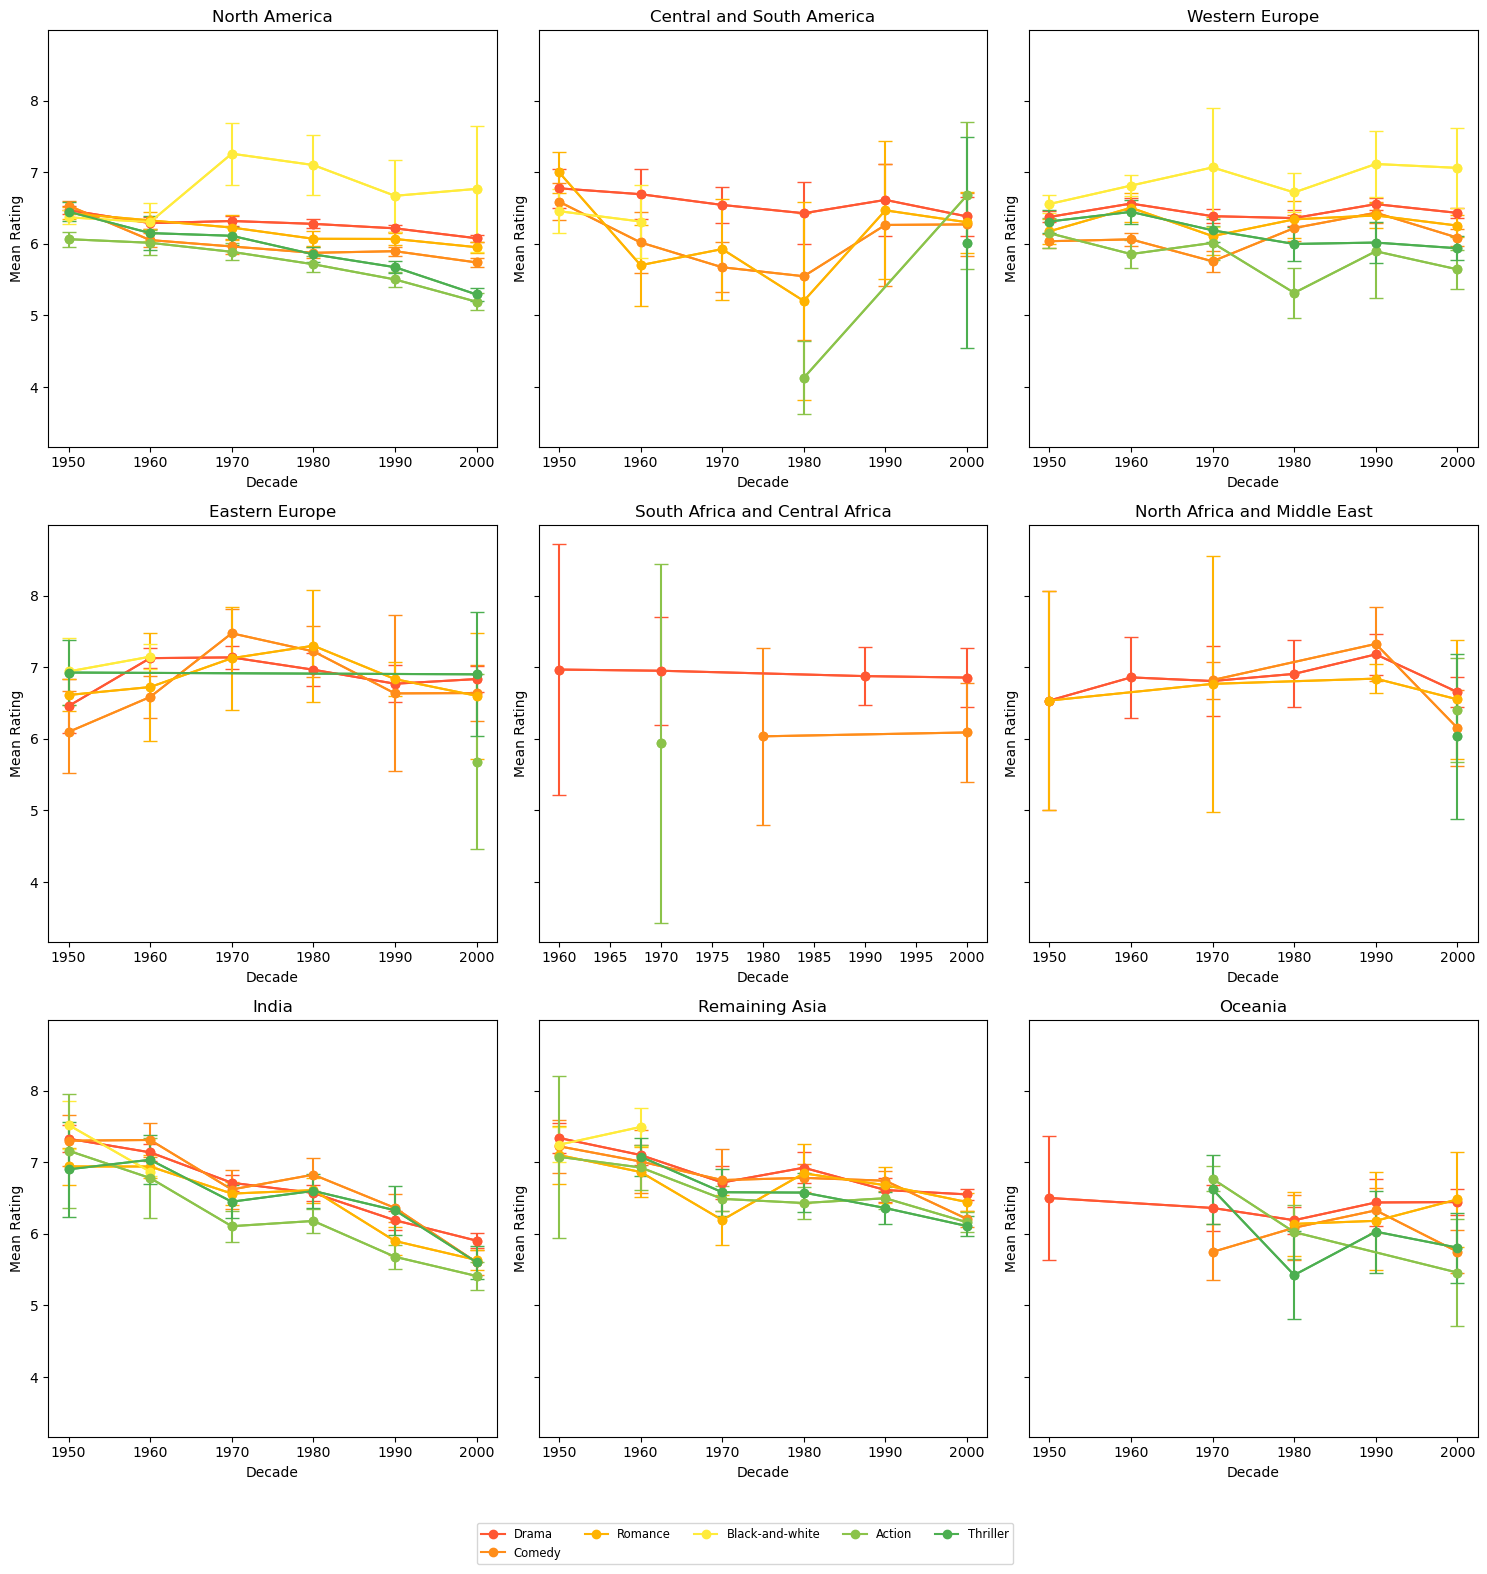

In [395]:
# plotting the results
ratings_visualizations.plot_region_genre_ratings(
    mean_ratings,           
    confidence_intervals,   
    decades,                
    top_6_genres,     
    genres_colors                  
)

Interesting! Let's now apply the analysis of comparing ratings across decades to analyzing the ratings across decades between regions per genre.

In [396]:
# creating a dataframe copy
df_movies_ratings_region_decadefilled = df_movies_ratings_regionfilled.copy()

# binning movies into the decade in which they were released
df_movies_ratings_region_decadefilled["decade"] = df_movies_ratings_region_decadefilled["release_date"].apply(
    cleaning.categorize_decade)

# dropping missing decade entries
df_movies_ratings_region_decadefilled.dropna(subset=['decade'], inplace=True)

In [397]:
# blank movie(s) for the missing genre(s) of any geographic region in any deacde are required, to ensure no errors when plotting below
df_movies_ratings_region_decadefilled = filling.fill_missing_decades(
    df_movies_ratings_region_decadefilled,
    top_6_genres,               
    list(regions.keys()),                         
    decades               
)

In [398]:
# compute mean ratings and confidence intervals
mean_ratings, confidence_intervals = ratings_statistics.calculate_genre_region_decade_statistics(
    df_movies_ratings_region_decadefilled, 
    top_6_genres,                             
    list(regions.keys()),                           
    decades                              
)

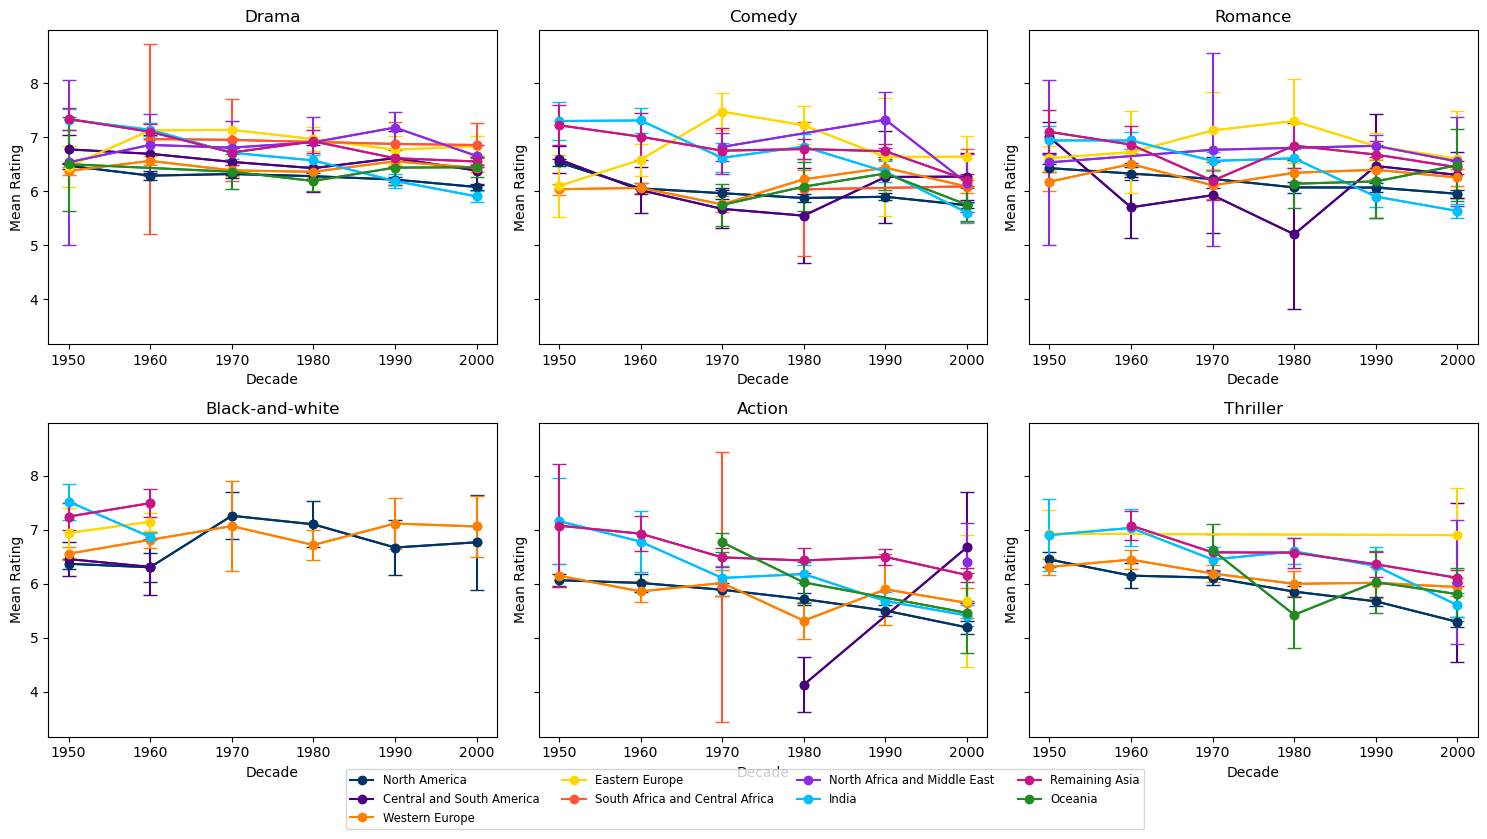

In [399]:
# plotting the results
ratings_visualizations.plot_genre_region_mean_ratings(mean_ratings, 
    confidence_intervals,
    list(regions.keys()),
    decades,
    regions_colors
)

Let's replicate the above over the top 20 genres.

In [400]:
# creating a dataframe copy
df_movies_ratings_region_decadefilled = df_movies_ratings_regionfilled.copy()

# binning movies into the decade in which they were released
df_movies_ratings_region_decadefilled["decade"] = df_movies_ratings_region_decadefilled["release_date"].apply(
    cleaning.categorize_decade)

# dropping missing decade entries
df_movies_ratings_region_decadefilled.dropna(subset=['decade'], inplace=True)

In [401]:
# blank movie(s) for the missing genre(s) of any geographic region in any deacde are required, to ensure no errors when plotting below
df_movies_ratings_region_decadefilled = filling.fill_missing_decades(
    df_movies_ratings_region_decadefilled,
    top_20_genres,               
    list(regions.keys()),                         
    decades               
)

In [402]:
# compute mean ratings and confidence intervals
mean_ratings, confidence_intervals = ratings_statistics.calculate_genre_region_decade_statistics(
    df_movies_ratings_region_decadefilled, 
    top_20_genres,                             
    list(regions.keys()),                           
    decades                              
)

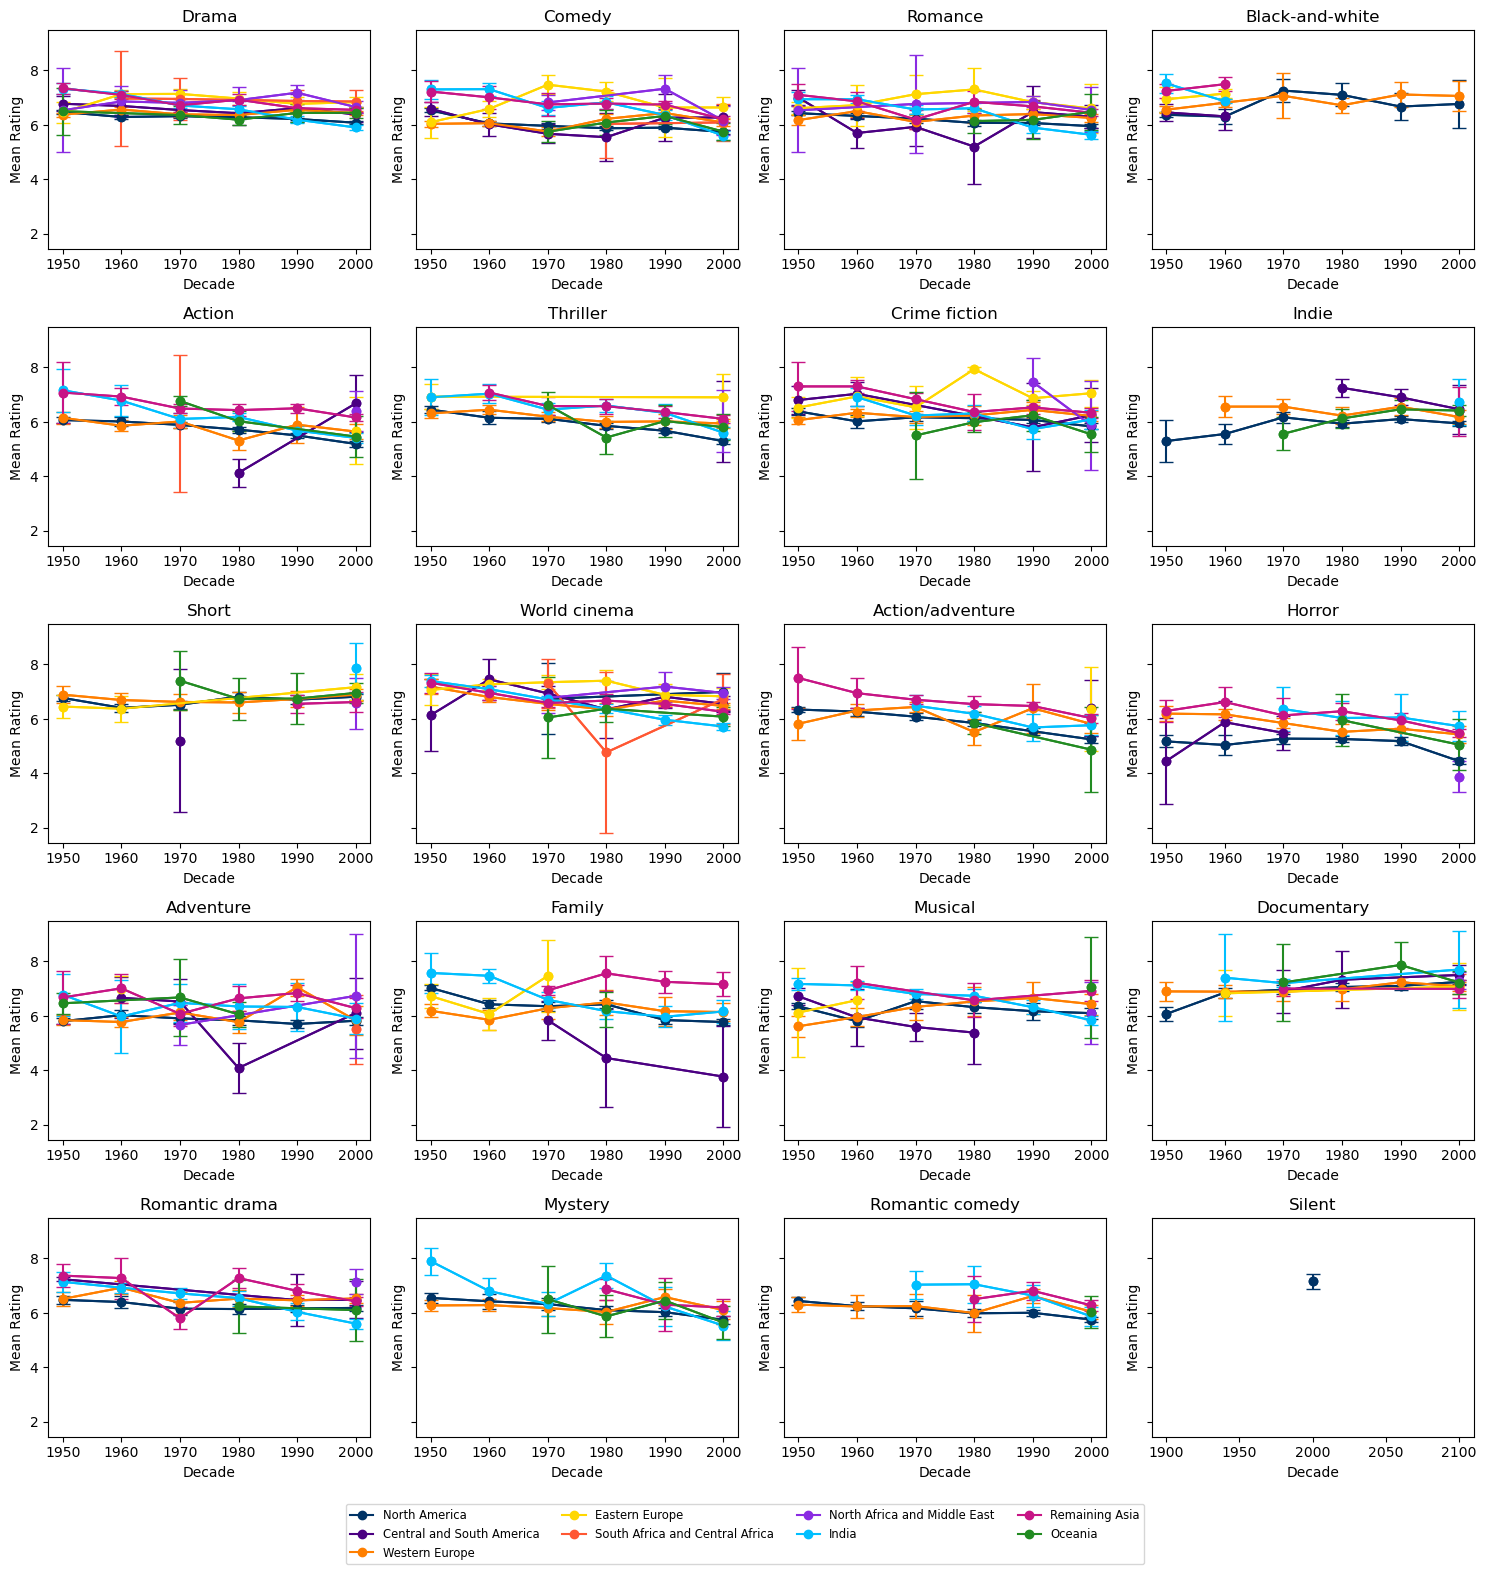

In [403]:
# plotting the results
ratings_visualizations.plot_genre_region_mean_ratings(mean_ratings, 
    confidence_intervals,
    list(regions.keys()),
    decades,
    regions_colors,
    (5, 4)
)

## 3.2 - Ratings statistical significance analysis

Wanting to analyze the significance of difference between ratings per region; there is complete independency of a given genre's ratings per region
as no movies were exploded for country hence no movies can be counted in more than one region and the ratings are assumed to be normally distributed,
hence ANOVA is performed to determine if within a given genre their ratings by region are statistically significantly different
- H_o = the null hypothesis: There is no significant difference among a given genre's rating means across movie regions
- H_a = the alternative hypothesis: There is a significant difference among a given genre's rating means across movie regions

In [404]:
# computing p_values from ANOVA testing for each genre
p_values = ratings_statistics.calculate_genre_anova_p_values(
    df_movies_ratings_regionfilled,
    top_20_genres,
    list(regions.keys())
)

# converting above results to a dataframe
df_genre_region_p_value = pd.DataFrame(list(p_values.items()), columns=['Genre', 'p_value'])

# log transformation for better visualization
df_genre_region_p_value['log_p_value'] = -df_genre_region_p_value['p_value'].apply(lambda x: np.log10(x) if x > 0 else None)

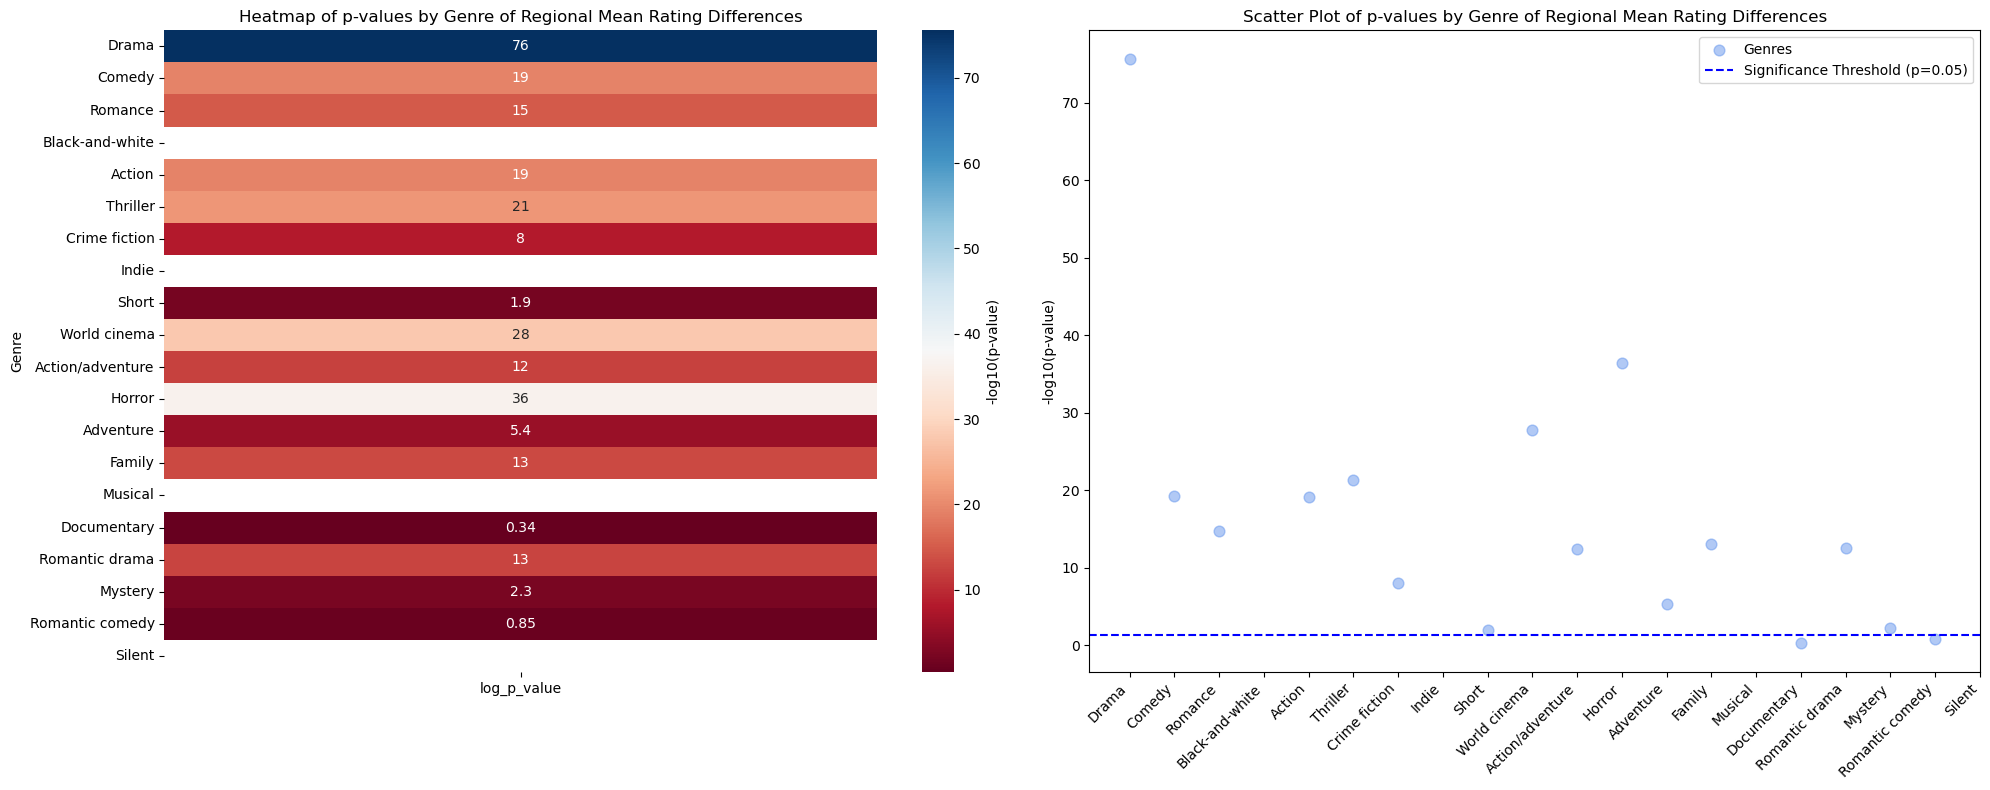

In [405]:
# preparing heatmap and scatterplot figure
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# plotting heatmap
sns.heatmap(df_genre_region_p_value.set_index('Genre')[['log_p_value']], annot=True, cmap='RdBu', cbar_kws={'label': '-log10(p-value)'}, ax=axes[0])
axes[0].set_title('Heatmap of p-values by Genre of Regional Mean Rating Differences')

# plotting scatter plot
axes[1].scatter(top_20_genres, df_genre_region_p_value['log_p_value'], s=60, color='cornflowerblue', alpha=0.5, label='Genres')

# adding significance threshold line
axes[1].axhline(y=-np.log10(0.05), color='blue', linestyle='--', label='Significance Threshold (p=0.05)')
axes[1].set_xticks(range(len(top_20_genres)))
axes[1].set_xticklabels(top_20_genres, rotation=45, ha='right')
axes[1].set_ylabel('-log10(p-value)')
axes[1].set_title('Scatter Plot of p-values by Genre of Regional Mean Rating Differences')
axes[1].legend()

plt.tight_layout()
plt.show()

Most movies genres reject that there is no statistically significant difference in their ratings across regions and therefore we consider regional differences to have an impact on the mean ratings per genre. Documentaries and romantic comedies are the sole movies that fail to conclude a statistically significant difference in their mean ratings seperated by movie country.

Now we aim to understand if there is significance in the mean ratings across genres for a given movie region. For this, new hypothesis tests are prepared:

- H_o = the null hypothesis: There is no significant difference among a given region's mean ratings across genres
- H_a = the alternative hypothesis: There is a significant difference among a given region's mean ratings across genres

As there are some movies that appear in more than one genre, then we have to consider that we are in a situation where our samples are not entirely independent, which is a requirement for using one-way ANOVA testing, and hence the sample ratings may not fit a normal distribution. As a result, a Kruskal-Wallis Test is used per regional groupign of movies. A linear-mixed model would also be applicable for such an analysis, however, this test requires a linear relationship between the ratings and genre hot-encoded features, which we cannot prove. The Kruskal-Wallis Test is therefore called on each regional grouping.

In [406]:
# performing Kruskal-Wallis and printing results
ratings_statistics.analyze_genre_ratings_by_region(df_movies_ratings, list(regions.keys()))

Results for region: North America
Kruskal-Wallis Statistic: 4016.9537, p-value: 0.0000
The null hypothesis is rejected; there is a suggested statistically significant difference in movie ratings by genre for movies in North America.

--------------------------------------------------

Results for region: Central and South America
Kruskal-Wallis Statistic: 91.6798, p-value: 0.0000
The null hypothesis is rejected; there is a suggested statistically significant difference in movie ratings by genre for movies in Central and South America.

--------------------------------------------------

Results for region: Western Europe
Kruskal-Wallis Statistic: 815.2140, p-value: 0.0000
The null hypothesis is rejected; there is a suggested statistically significant difference in movie ratings by genre for movies in Western Europe.

--------------------------------------------------

Results for region: Eastern Europe
Kruskal-Wallis Statistic: 24.0532, p-value: 0.1941
The null hypothesis is failed to 

## 3.3 Genre, time and regions on ratings statistics

Since we've already established that ratings per genre are different for different regions and vice-versa, we now want to see the evolution per decade of these ratings for different region-genre combos. To do that, we calculate the mean rating for each genre-region per decade, treating them as different subjects, and consider the rating as measured for each decade. This assumes that the ratings for a specific genre-region combo are dependent across decades, which is a key assumption for using repeated-measures ANOVA.

The repeated-measures ANOVA test requires that each genre-region combo has at least one rating per decade, thus we'll be using `df_movies_ratings_region_decadefilled`. The null hypothesis is the following:the mean ratings for genre-region combos do not change across decades.

In [407]:
# creating unique identifier for genre-region combinations
df_movies_ratings_region_decadefilled['genre_region'] = (
    df_movies_ratings_region_decadefilled['genres'] + "-" +
    df_movies_ratings_region_decadefilled['region']
)

# converting to category
df_movies_ratings_region_decadefilled['decade'] = df_movies_ratings_region_decadefilled['decade'].astype('category')
df_movies_ratings_region_decadefilled['genre_region'] = df_movies_ratings_region_decadefilled['genre_region'].astype('category')

In [408]:
# fitting the model with interaction between decade and genre_region
model = ols("averageRating ~ C(decade) * C(genre_region)", data=df_movies_ratings_region_decadefilled).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA Table:")
print(anova_table)

ANOVA Table:
                                 sum_sq       df           F         PR(>F)
C(decade)                   1442.595956      5.0  266.264071  3.527453e-282
C(genre_region)            13310.275508    179.0   68.623344   0.000000e+00
C(decade):C(genre_region)   9037.584703    895.0    9.318955   0.000000e+00
Residual                   57881.747174  53417.0         NaN            NaN


Interpretation: looking at the 'C(decade):C(genre_region)' row in the ANOVA table, a significant p-value means the effect of decade on ratings differs by genre_region.

In [409]:
# extracting model residuals
residuals = model.resid
fitted_values = model.fittedvalues

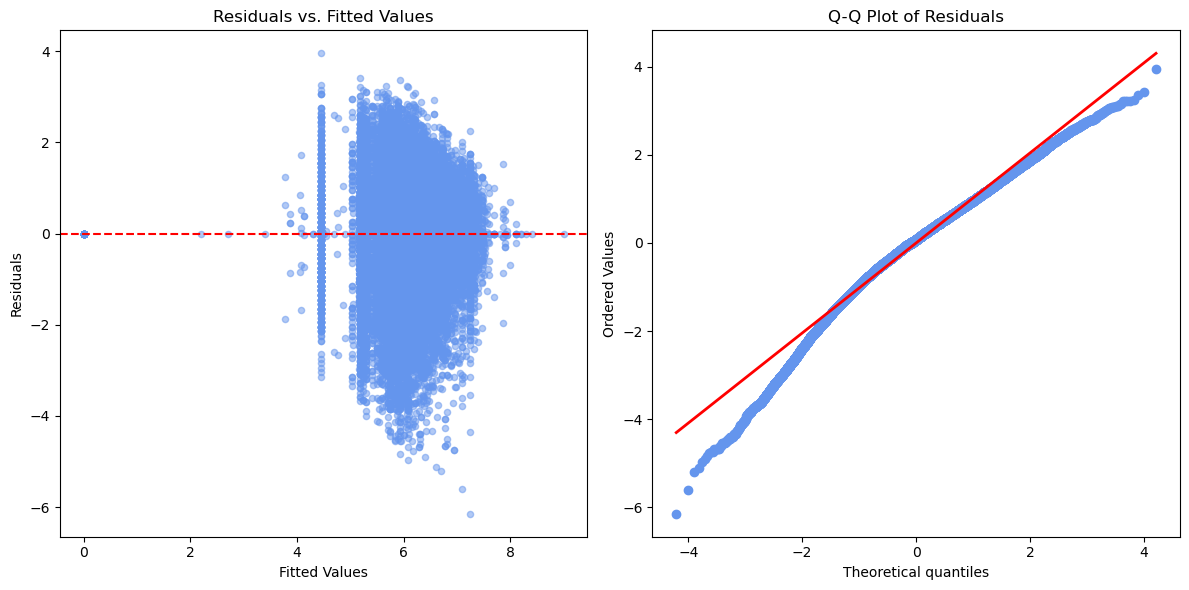

In [410]:
# preparing figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# plotting residuals vs. fitted values
axes[0].scatter(fitted_values, residuals, **styles['scatter_style'])
axes[0].axhline(y=0, color="r", linestyle="--")
axes[0].set_xlabel("Fitted Values")
axes[0].set_ylabel("Residuals")
axes[0].set_title("Residuals vs. Fitted Values")

# Q-Q plot for residuals
stats.probplot(residuals, dist='norm', plot=axes[1])
axes[1].set_title("Q-Q Plot of Residuals")

# line settings
axes[1].get_lines()[0].set_color('cornflowerblue') 
axes[1].get_lines()[0].set_linewidth(2)
axes[1].get_lines()[1].set_color('red') 
axes[1].get_lines()[1].set_linewidth(2)

plt.tight_layout()
plt.show()

For every fitted value in x we have a homogeneous spread so we consider the homogenity of varience to be suitable for our analysis. 

In [411]:
# converting 'decade' column to numeric (integer)
df_movies_ratings_region_decadefilled['decade'] = pd.to_numeric(df_movies_ratings_region_decadefilled['decade'], errors='coerce')

In [412]:
# calculate_slopes() call to compute slopes of average ratings between consecutive periods for movies grouped by specified columns
df_slopes = ratings_statistics.calculate_slopes(
    df_movies_ratings_region_decadefilled,
    ['region', 'genres'],
    'decade',
    'averageRating'
)

In [413]:
# identify_top_and_worst_genres() to identify the genres with the steepest and shallowest slope in ratings 
# for each region and consecutive decade pair
df_top_worst = ratings_statistics.identify_top_worst_genres(df_slopes)

In [414]:
# defining decades and regions for visualization
decade_pairs = sorted(df_top_worst[['decade1', 'decade2']].drop_duplicates().values.tolist())
regions_unique = sorted(df_top_worst['region'].unique())

# flattening the decade pairs for visualization
decade_labels = [f"{d1}-{d2}" for d1, d2 in decade_pairs]

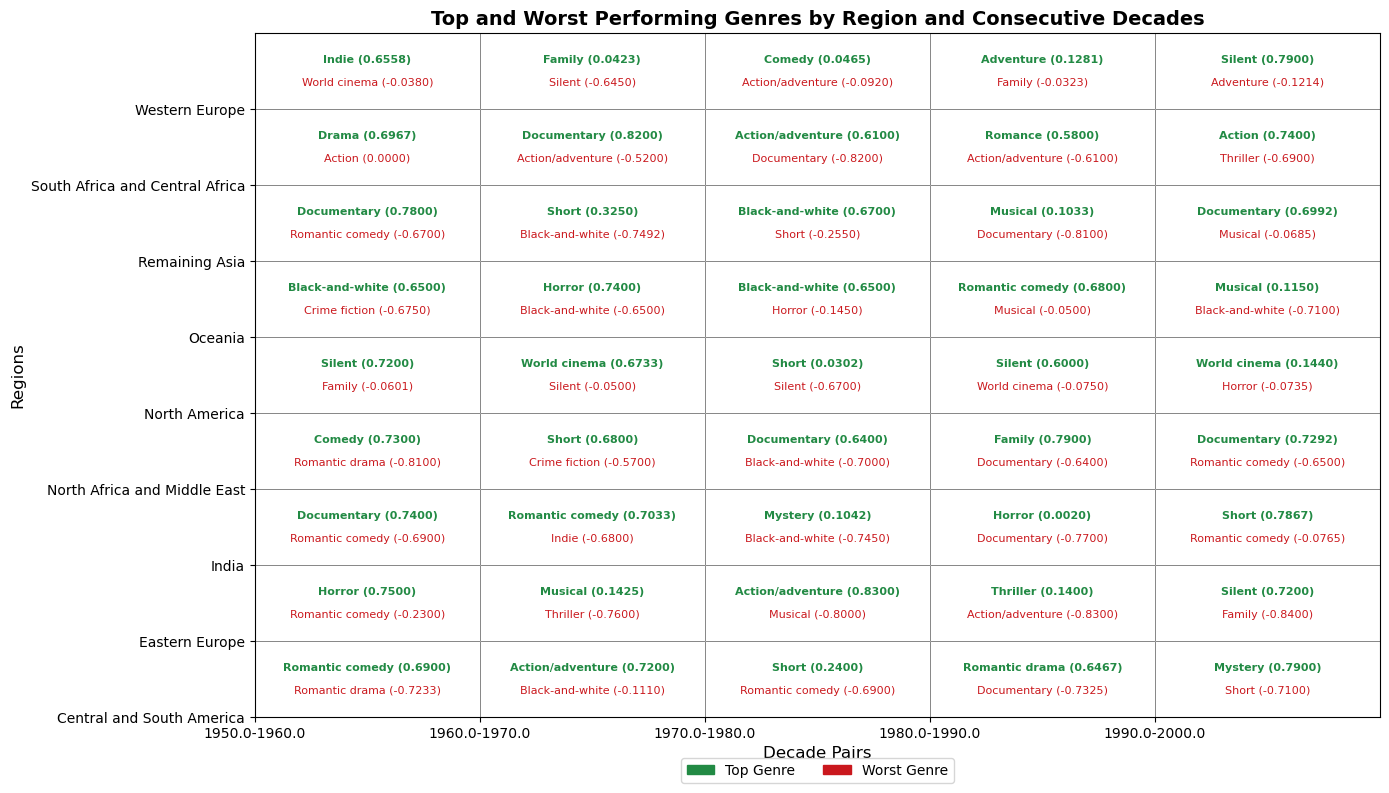

In [415]:
# plot_top_worst_genres() call, to create a grid plot visualizing the top and worst-performing genres 
# across regions and consecutive decade pairs
ratings_visualizations.plot_top_worst_genres(
    top_worst_df=df_top_worst,
    regions=regions_unique,
    decade_labels=decade_labels,
    decade_pairs=decade_pairs,
)

In [416]:
# anova_on_slopes() call to perform ANOVA on the slopes of average ratings between different decades 
# for specified genre-region combinations
anova_results_df, significant_results_df = ratings_statistics.anova_on_slopes(
    df_movies_ratings_region_decadefilled,
    top_6_genres,
    regions_unique
)

print("Significant Results:")
print(significant_results_df.head(5))

Significant Results:
   genre          region     f_stat       p_value  significant
1  Drama  Eastern Europe   4.874727  2.670461e-04         True
2  Drama           India  49.856161  7.811295e-49         True
4  Drama   North America  18.414591  3.492335e-18         True
6  Drama  Remaining Asia  13.962152  4.150508e-13         True
8  Drama  Western Europe   3.959657  1.409835e-03         True


# Arima model: 

We have proved interactions between region - genre now and we have proved that genre - regions pairs evoluate differently through time. Is it possible to capture these relationships and try to predict the ratings for certain genre - regions? or for some regions at least? 

To do that, we tried first to implement an Arima model which tries to capture and then predict ratings for each region. 

In [417]:
# categorization into 5-year bins to have more datapoints for ARIMA
df_movies_ratings_region_decadefilled["5yearbin"] = df_movies_ratings_region_decadefilled["release_date"].apply(cleaning.categorize_5_year)

# dropping unmatched '5yearbin' column entries
df_movies_ratings_region_decadefilled.dropna(subset=['5yearbin'], inplace=True)

# defining the 5 year bins of interest
five_year_bins = ["1950", "1955", "1960", "1965", "1970", "1975", "1980", "1985", "1990", "1995", "2000", "2005"]

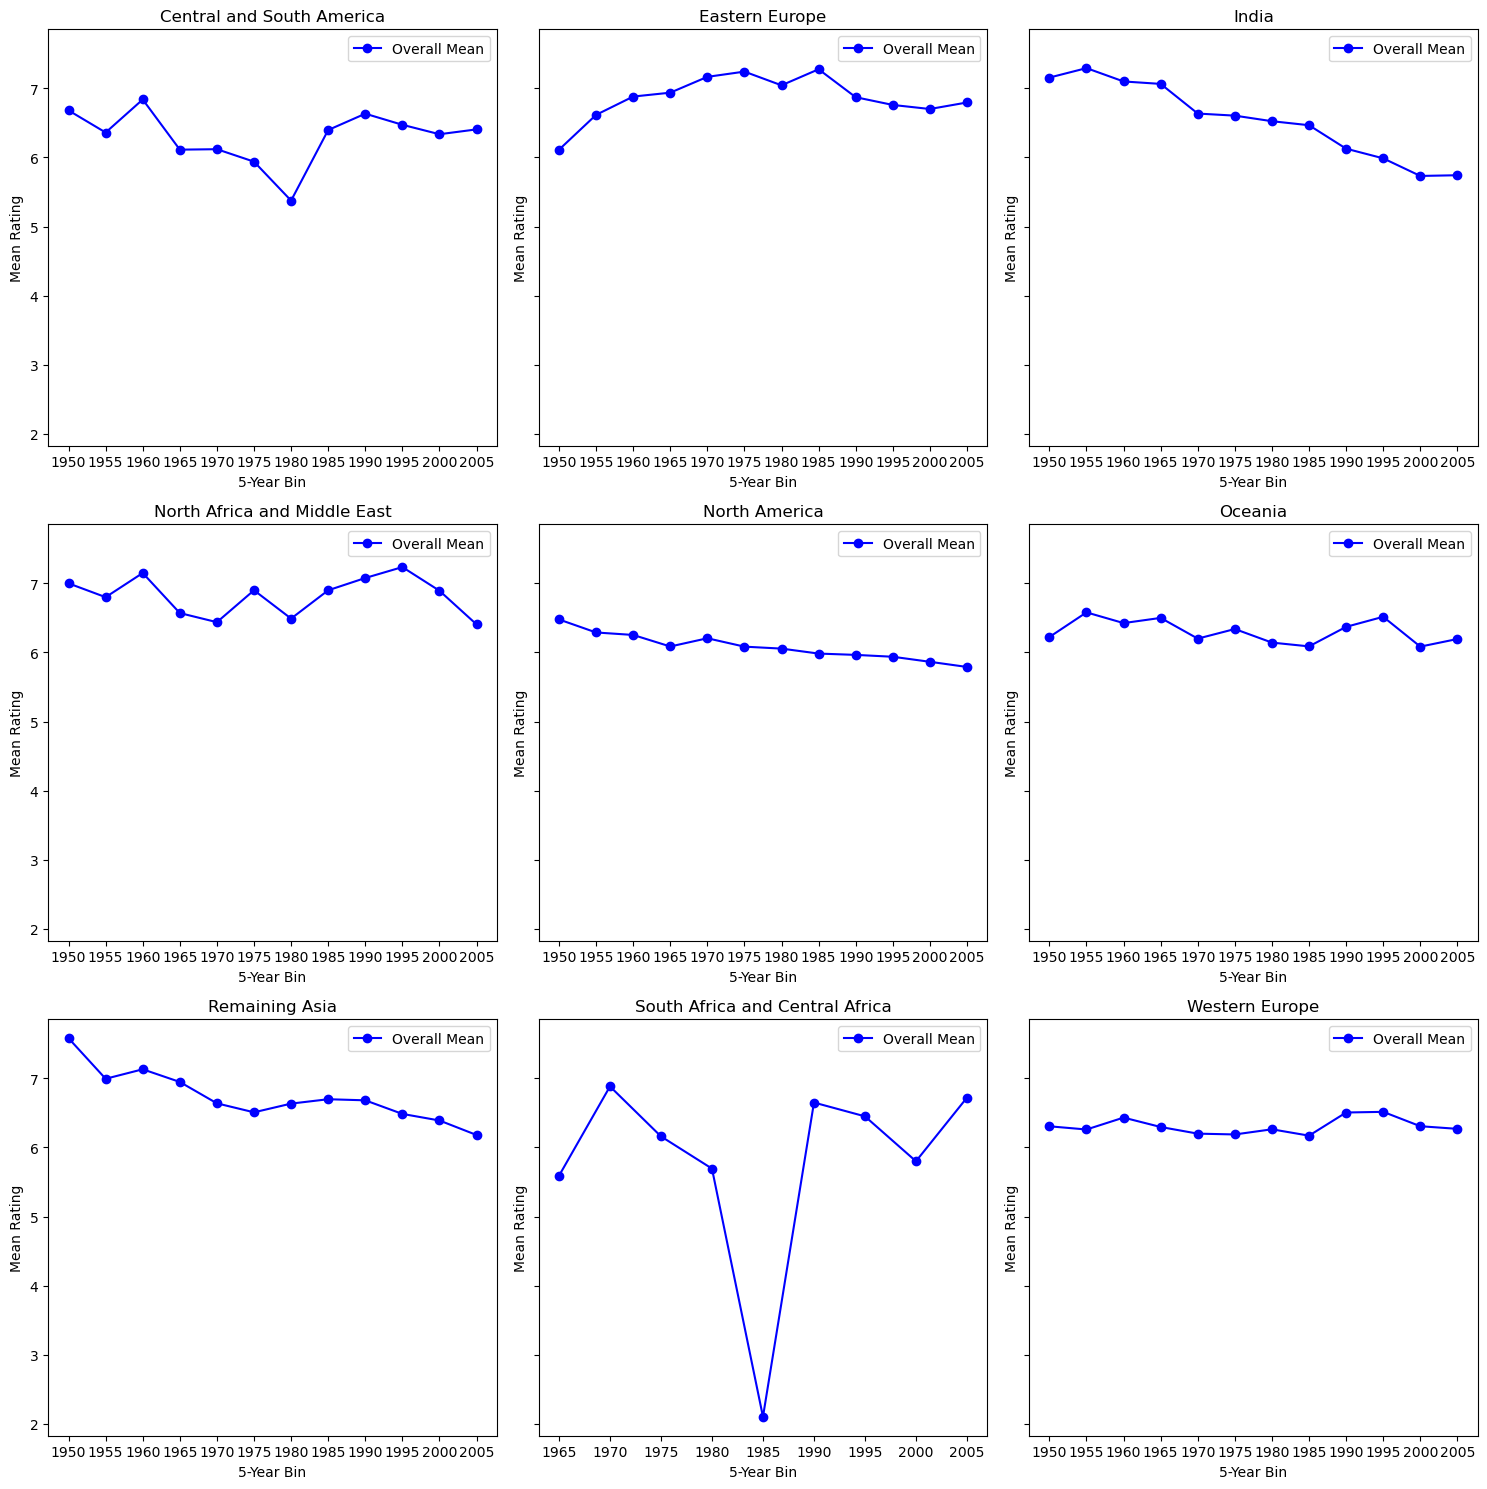

In [418]:
# computing overall means to then fit the Arima model
overall_means = ratings_visualizations.calculate_and_plot_overall_means(
    df_movies_ratings_region_decadefilled,
    regions_unique
)

--- Fitting AutoARIMA for Region: Central and South America ---
Best Model for Central and South America:  ARIMA(0,0,0)(0,0,0)[0] intercept
--- Fitting AutoARIMA for Region: Eastern Europe ---
Best Model for Eastern Europe:  ARIMA(1,0,0)(0,0,0)[0] intercept
--- Fitting AutoARIMA for Region: India ---
Best Model for India:  ARIMA(0,1,1)(0,0,0)[0] intercept
--- Fitting AutoARIMA for Region: North Africa and Middle East ---
Best Model for North Africa and Middle East:  ARIMA(0,0,0)(0,0,0)[0] intercept
--- Fitting AutoARIMA for Region: North America ---
Best Model for North America:  ARIMA(0,1,1)(0,0,0)[0] intercept
--- Fitting AutoARIMA for Region: Oceania ---
Best Model for Oceania:  ARIMA(0,0,0)(0,0,0)[0] intercept
--- Fitting AutoARIMA for Region: Remaining Asia ---
Best Model for Remaining Asia:  ARIMA(0,1,0)(0,0,0)[0] intercept
--- Fitting AutoARIMA for Region: South Africa and Central Africa ---
Best Model for South Africa and Central Africa:  ARIMA(0,0,0)(0,0,0)[0] intercept
--- Fi

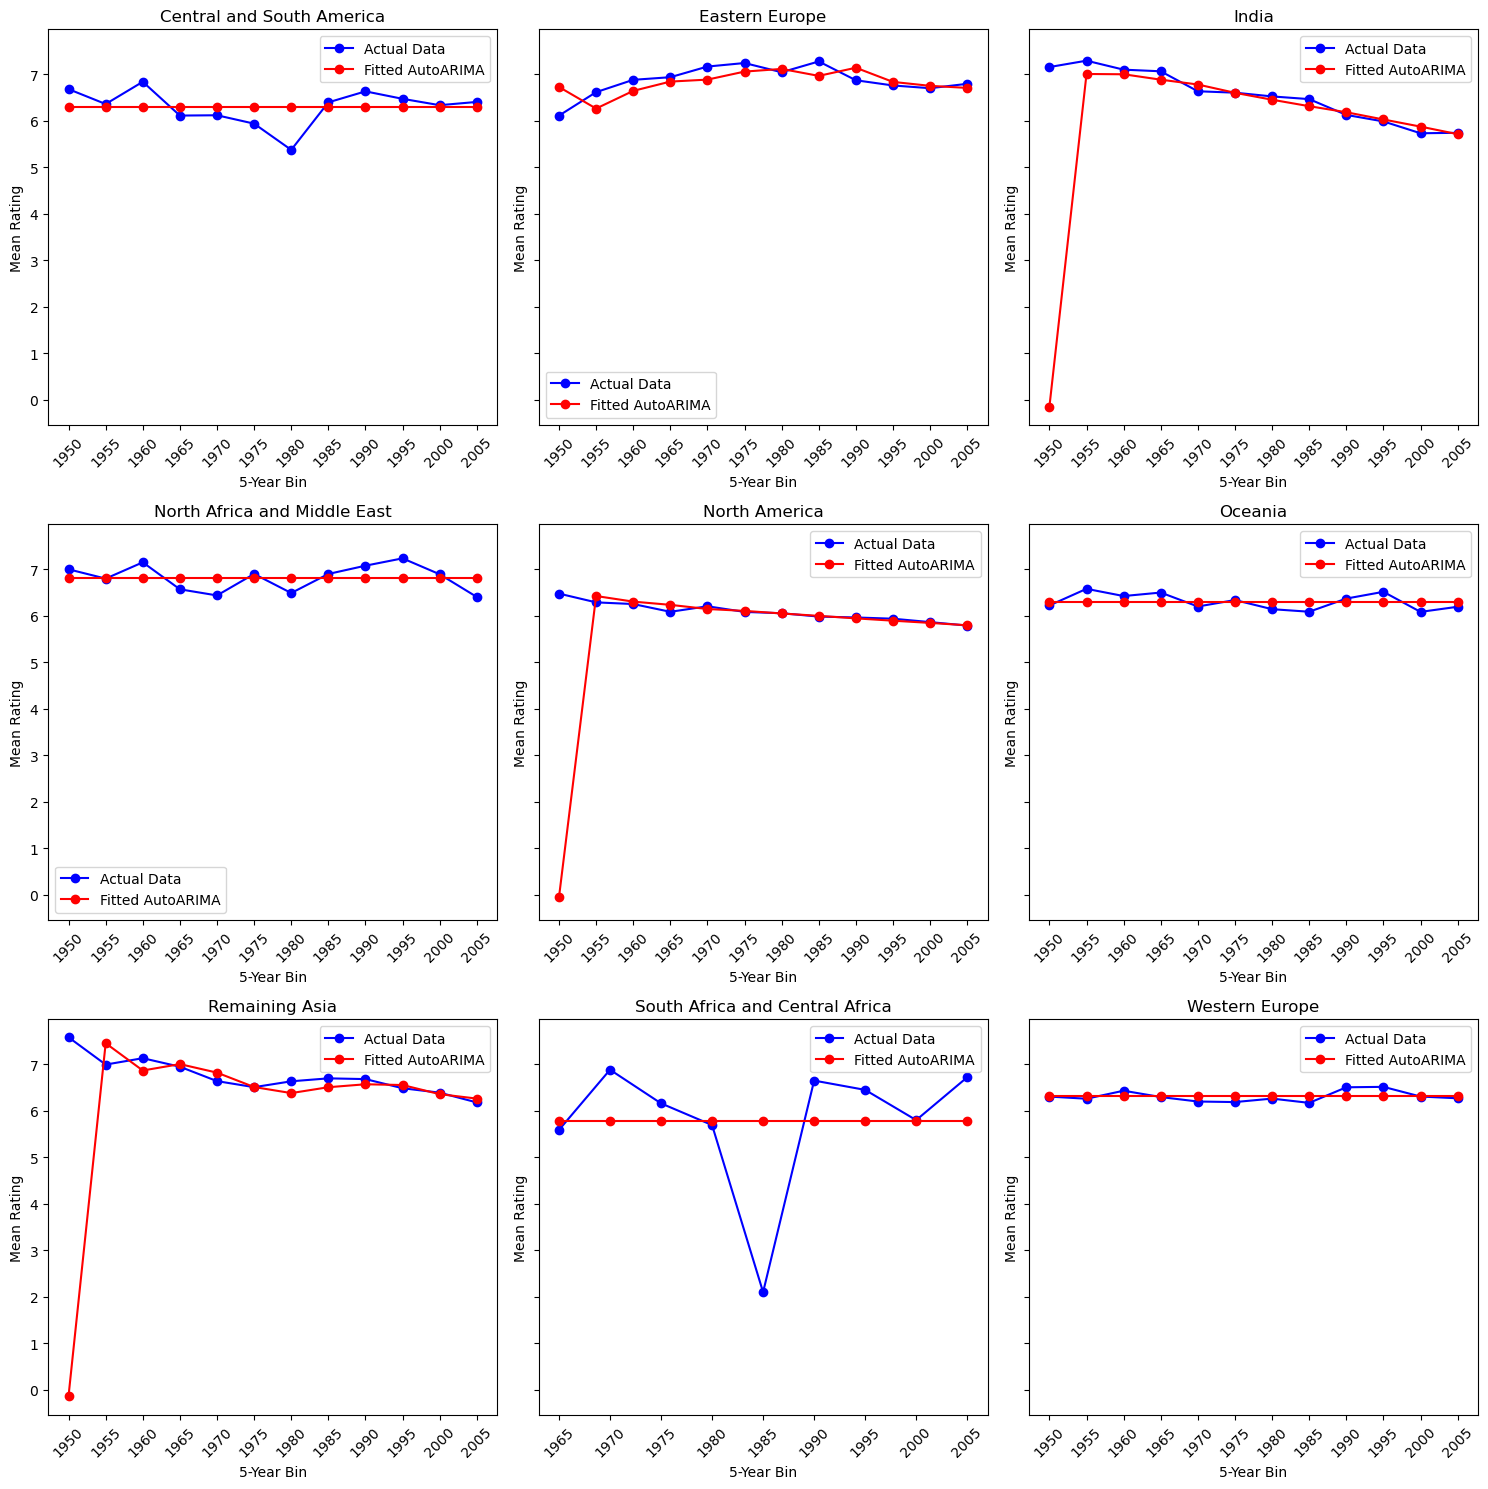

Region: Central and South America --> RMSE: 0.3714, R²: 0.0000
Region: Eastern Europe --> RMSE: 0.2696, R²: 0.2163
Region: India --> RMSE: 2.1128, R²: -15.1319
Region: North Africa and Middle East --> RMSE: 0.2720, R²: 0.0000
Region: North America --> RMSE: 1.8861, R²: -100.2430
Region: Oceania --> RMSE: 0.1659, R²: 0.0000
Region: Remaining Asia --> RMSE: 2.2334, R²: -37.6498
Region: South Africa and Central Africa --> RMSE: 1.3760, R²: 0.0000
Region: Western Europe --> RMSE: 0.1113, R²: -0.0000


In [419]:
# fitting and plotting the Arima model
fitted_models, forecast_results, error_metrics = ratings_visualizations.fit_autoarima_models(overall_means)

The AutoARIMA model fits varied significantly across regions. While RMSE values are generally low for most regions, indicating small absolute prediction errors, the R² scores are poor or negative for many regions. This suggests that the model often fails to explain variance effectively, especially for regions like India, North America, and Remaining Asia, where R² scores are heavily negative, reflecting poor model performance. The model performs better in Eastern Europe (moderate R² = 0.2166). Overall, the AutoARIMA model struggles to capture trends accurately across most regions, highlighting the need for better-suited modeling approaches.

--- Forecasting for Region: India ---
--- Forecasting for Region: North America ---
--- Forecasting for Region: Western Europe ---


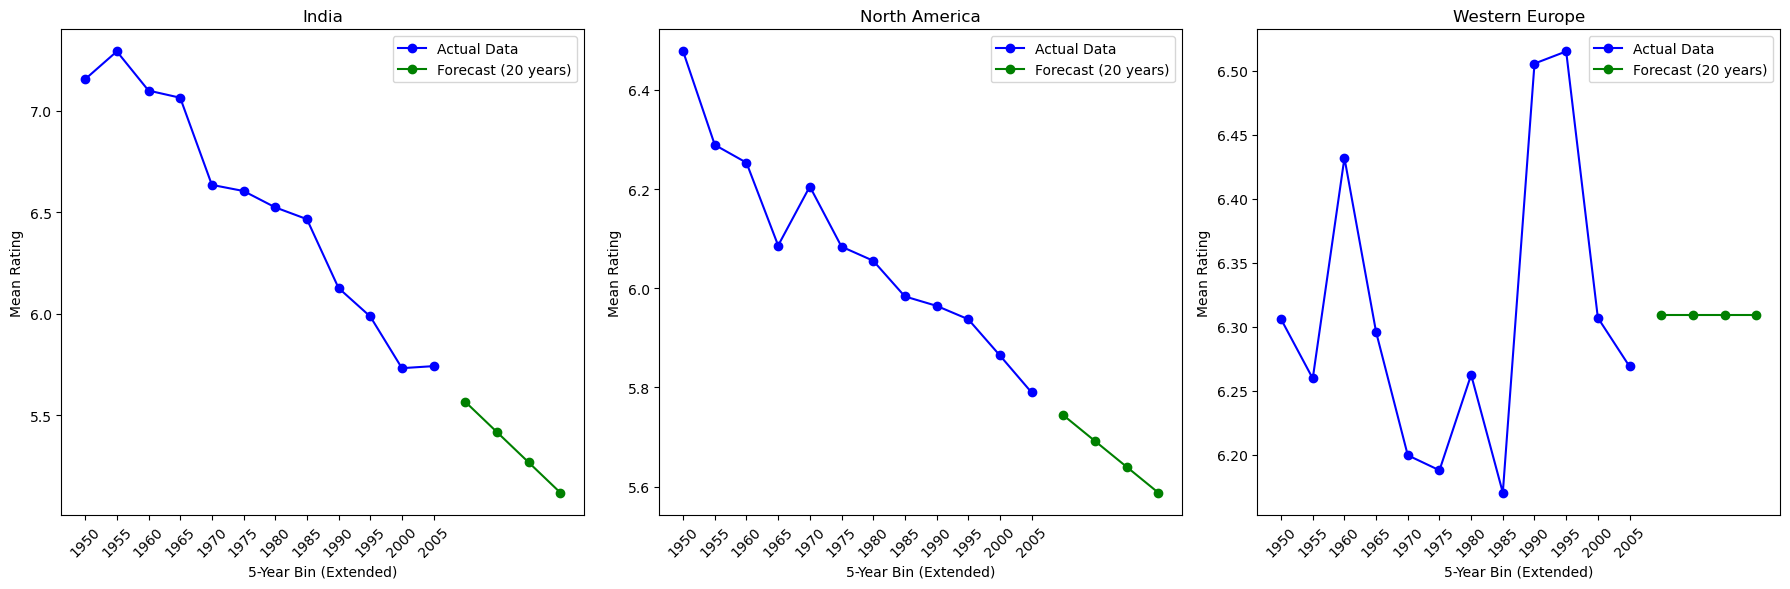

In [420]:
# trying to forecats on some selected regions ("India", "North America", "Western Europe")
future_predictions = ratings_visualizations.forecast_regions(fitted_models, overall_means)

# 4 - Characters features analysis

In [421]:
# copies of the master dataframes to proceed with the analysis
df_movies_charac = df_movies_ratings_imdb.copy()
df_movies_charac_unique = df_movies_ratings_imdb_unique.copy()
df_charac = df_characters.copy()

## 4.1 - Number of actors

Since we're trying to assess diversity in movies, we start by looking at the nb of actors in a movie. 

In [422]:
# nb of actors per movie = unique actors per movie as each entry of df_characters is a character in the movie 
actors_per_movie = df_characters.groupby('wikipedia_id')['freebase_actor_id'].nunique()

# mapping the count back to the original dataframe
df_movies_charac['nb_actors'] = df_movies_charac['wikipedia_id'].map(actors_per_movie)

In [423]:
# dropping missing values
df_movies_charac = df_movies_charac.dropna(subset=['averageRating', 'nb_actors'])

# printing basic stats
print(df_movies_charac[['averageRating', 'nb_actors']].describe())

       averageRating     nb_actors
count    70755.00000  70755.000000
mean         6.14768      8.273507
std          1.08089      5.395348
min          1.10000      0.000000
25%          5.60000      4.000000
50%          6.30000      8.000000
75%          6.90000     11.000000
max          9.50000    115.000000


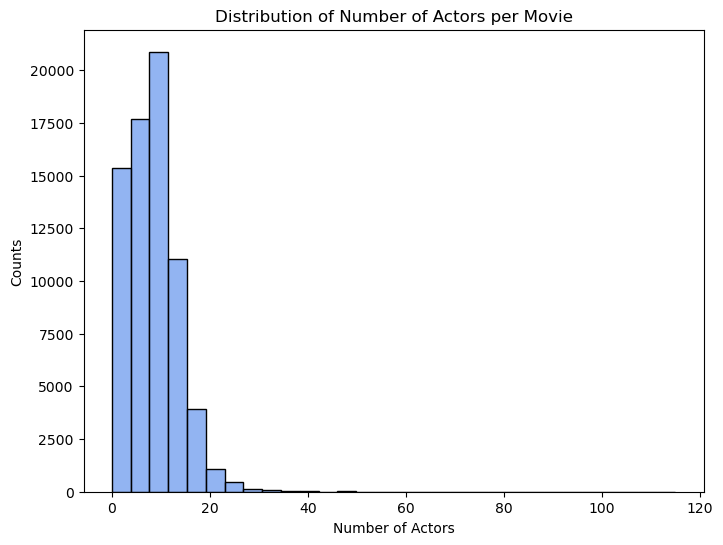

In [ ]:
# plotting the distribution of the number of actors
plt.figure(figsize=(8, 6))
sns.histplot(df_movies_charac['nb_actors'], bins=30, **styles['hist_style'])
plt.title("Distribution of Number of Actors per Movie")
plt.xlabel("Number of Actors")
plt.ylabel("Counts")
plt.show()

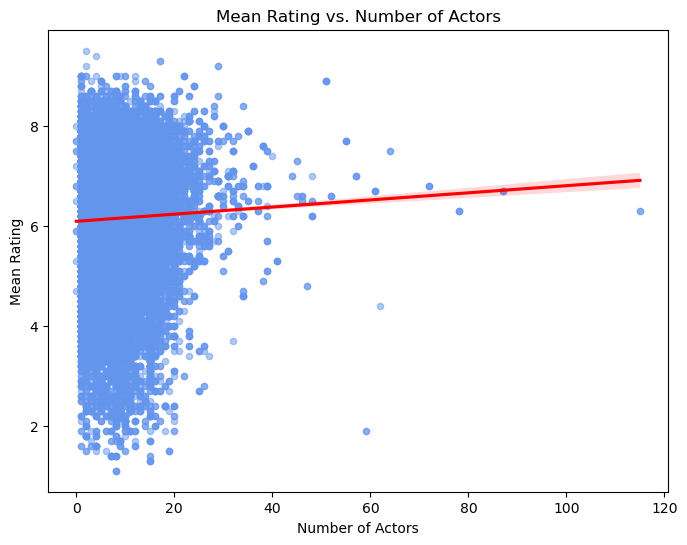

In [425]:
# scatter plot of nb of actors vs mean rating
plt.figure(figsize=(8,6))
sns.regplot(
    x='nb_actors', 
    y='averageRating', 
    data=df_movies_charac, 
    scatter_kws=styles['scatter_style'], 
    line_kws=styles['line_style']
)
plt.xlabel('Number of Actors')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Number of Actors')
plt.show()

In [426]:
# calculating Pearson correlation between averageRating and nb_actors
pearson_corr, pearson_p = pearsonr(df_movies_charac['averageRating'], df_movies_charac['nb_actors'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# calculating Spearman correlation between averageRating and nb_actors
spearman_corr, spearman_p = spearmanr(df_movies_charac['averageRating'], df_movies_charac['nb_actors'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

Pearson correlation: 0.0355, p-value: 0.0000
Spearman correlation: 0.0344, p-value: 0.0000


Now let’s dig deeper into the demographics of the actors and explore how that might influence the ratings.

In [427]:
# merging character's data with master dataframe
df_movies_charac_merged = pd.merge(df_charac[['wikipedia_id','actor_gender','actor_ethnicity','freebase_actor_id']],
                             df_movies_charac_unique[['wikipedia_id','countries', 'title', 'release_date','genres','averageRating','region']], 
                             on='wikipedia_id', how='inner')

# filtering rows where both 'regions' and 'actor ethnicity' are not NaN
df_movies_charac_merged = df_movies_charac_merged.dropna(subset=['region', 'actor_ethnicity'])

In [428]:
# exploding the 'actor ethnicity' column to handle lists
df_movies_charac_exploded = df_movies_charac_merged.explode('actor_ethnicity')

# ethnicity representation by region through groupby()
region_ethnicity = df_movies_charac_exploded.groupby(['region', 'actor_ethnicity']).size().unstack(fill_value=0)

# calculating percentages for each region
region_ethnicity = region_ethnicity.div(region_ethnicity.sum(axis=1), axis=0) * 100

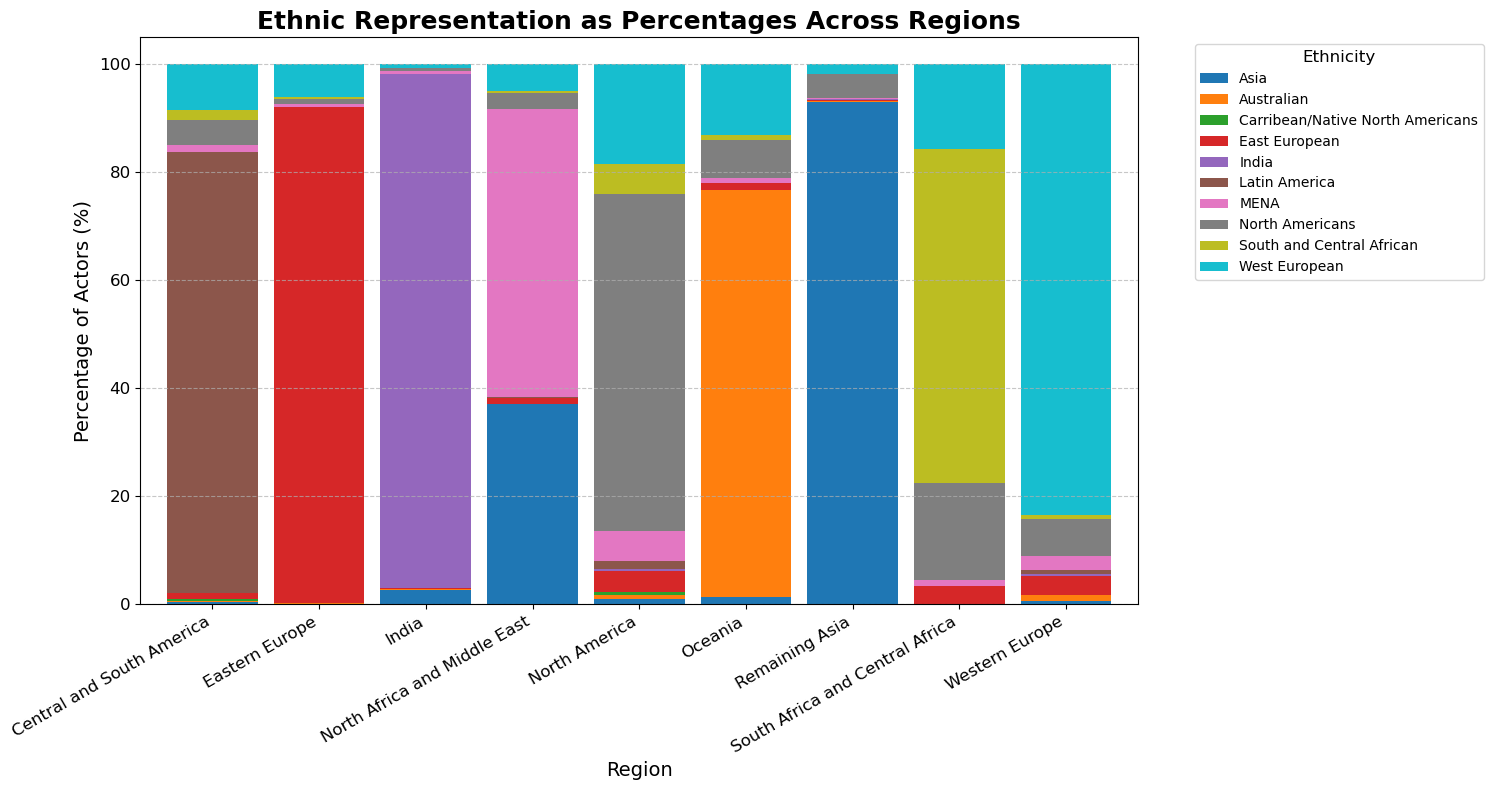

In [ ]:
# plotting the stacked bar chart with percentages
plt.figure(figsize=(15, 8))

# stacked bar plot
region_ethnicity.plot(
    kind='bar',
    stacked=True,
    width=0.85,
    ax=plt.gca()
)

plt.xlabel("Region", fontsize=14)
plt.ylabel("Percentage of Actors (%)", fontsize=14)
plt.title("Ethnic Representation as Percentages Across Regions", fontsize=18, fontweight='bold')
plt.xticks(rotation=30, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Since some of the ethnicities do not directly correspond to our regions, we need to have a mapping between the two. This mapping is contained in the `ethnicity_to_region` dictionary that is imported from `regions_clusters`.

In [430]:
# mapping the exploded ethnicity to standardized regions
df_movies_charac_exploded['mapped_region'] = df_movies_charac_exploded['actor_ethnicity'].map(ethnicity_to_region)

# dropping rows where mapping fails (unmatched regions)
df_movies_charac_exploded = df_movies_charac_exploded.dropna(subset=['mapped_region'])

In [431]:
# classifying as 'From Region' or 'Not From Region'
df_movies_charac_exploded['region_category'] = df_movies_charac_exploded.apply(
    lambda row: 'From Region' if row['region'] == row['mapped_region'] else 'Not From Region', axis=1
)

# grouping by 'region' and 'region_category' to count actors
region_category = df_movies_charac_exploded.groupby(['region', 'region_category']).size().unstack(fill_value=0)

# converting counts to percentages
region_category = region_category.div(region_category.sum(axis=1), axis=0) * 100

# unstacking the data to prepare for grouped bar plotting
region_category = region_category.unstack().reset_index()
region_category.columns = ['Category', 'Region', 'Percentage']

# pivoting data to get Categories as columns (grouped bar structure)
region_category = region_category.pivot(index='Region', columns='Category', values='Percentage')

<Figure size 1800x1000 with 0 Axes>

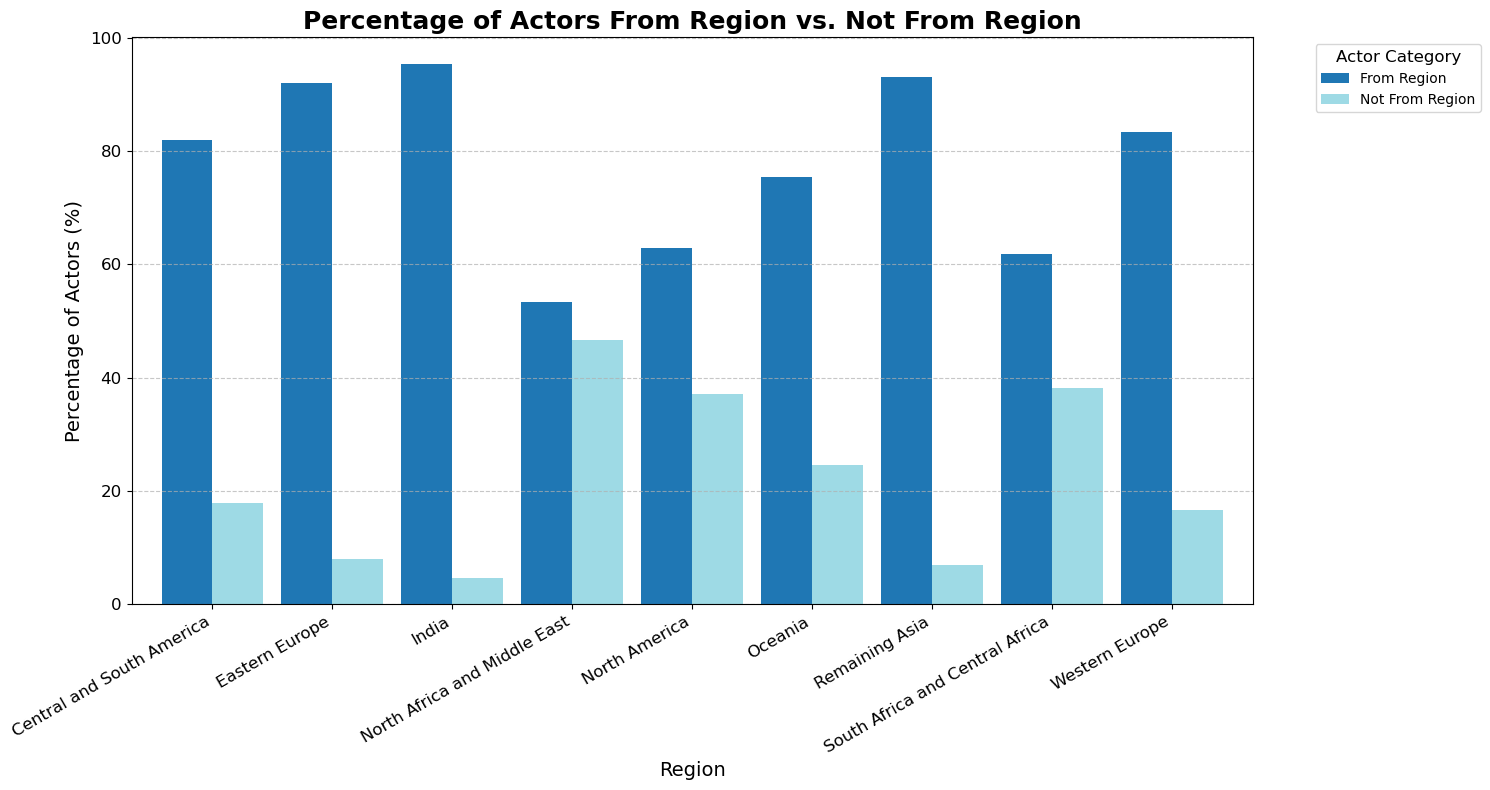

In [ ]:
# plotting grouped bar chart for From Region vs. Not From Region
plt.figure(figsize=(18, 10))
region_category.plot(kind='bar', colormap='tab20', width=0.85, figsize=(15, 8))
 
plt.title("Percentage of Actors From Region vs. Not From Region", fontsize=18, fontweight='bold')
plt.xlabel("Region", fontsize=14)
plt.ylabel("Percentage of Actors (%)", fontsize=14)
plt.xticks(rotation=30, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Actor Category", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Beside ethnicty representation, we are also interested in the gender distribution among moveis.

In [433]:
# grouping by 'region' and 'actor_gender', then count occurrences
region_gender = df_movies_charac_exploded.groupby(['region', 'actor_gender']).size().unstack(fill_value=0)

# calculating percentages for each region
region_gender = region_gender.div(region_gender.sum(axis=1), axis=0) * 100

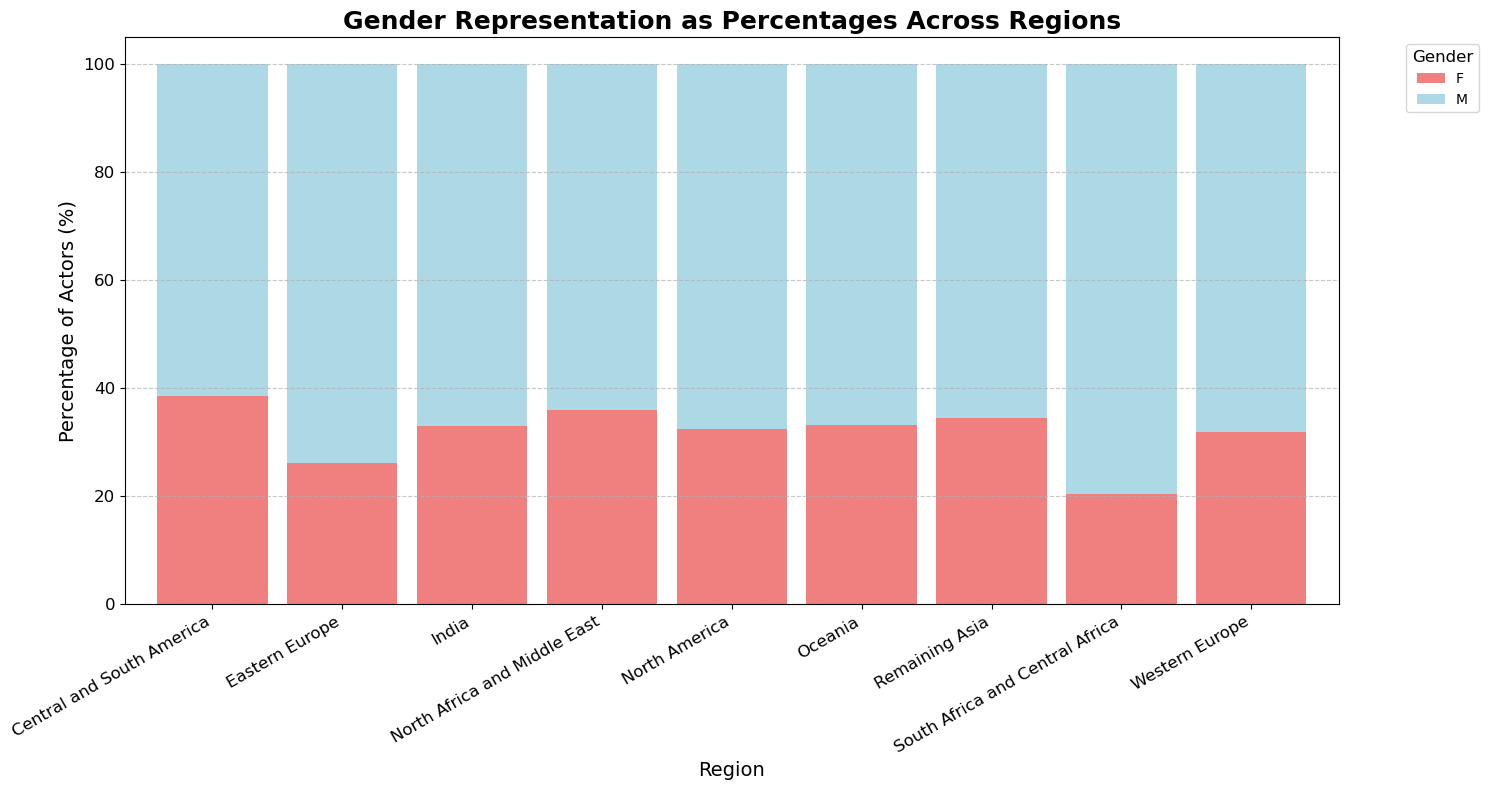

In [ ]:
# plotting stacked bar chart with percentages
plt.figure(figsize=(15, 8))
region_gender.plot(
    kind='bar',
    stacked=True,
    color=['lightcoral', 'lightblue'],
    width=0.85,
    ax=plt.gca()
)

plt.xlabel("Region", fontsize=14)
plt.ylabel("Percentage of Actors (%)", fontsize=14)
plt.title("Gender Representation as Percentages Across Regions", fontsize=18, fontweight='bold')
plt.xticks(rotation=30, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## 4.2 - Etchnicity score

What interests us is how the demographics of the cast members of one movie may impact it's ratings. We'll look at their ethnicities and their genders. This two features have to be quantified through an ethnicity_score and a gender_score per movie, reflecting not only the proportions but the distribution of the cast. A movie with 10 ethnicities represented equally (balanced distribution) should score higher in diversity than a movie with 10 ethnicities but dominated by one ethnicity. This is where the Shannon Diversity Index (SDI) becomes valuable because we are not capturing the true spread of diversity.
- **Shannon Index** offers a balanced measure of diversity, reducing the impact of outliers and providing a more accurate view of diversity distribution. We will be looking at the entropy of distribution. 
$$
H = - \sum_{i=1}^{n} p_i \ln(p_i)
$$

Where:

- \(H\): Shannon Diversity Index  
- \(p_i\): Proportion of individuals in the \(i\)-th category (ethnicity)  
- \(n\): Total number of categories (ethnicities)  




In [435]:
# filtering actors with no ethnicities by filtering nans and empty lists
df_charac_filtered = df_charac[
    df_charac['actor_ethnicity'].notna() & df_characters['actor_ethnicity'].apply(lambda x: len(x) > 0)
]

# exploding on actor ethnicity
df_charac_filtered = df_charac_filtered.explode('actor_ethnicity')

To better understand the actual ethnicities distributions, an `ehtnicity_proportion` columns is created.

In [ ]:
# counting occurrences of each ethnicity per movie
ethnicity_counts = df_charac_filtered.groupby(['wikipedia_id', 'actor_ethnicity']).size().reset_index(name='ethnicity_count')

# since df_charac_filtered is exploded based on ethnicities, counting the nb of entries simply gives total nb of ethnicities in the movie
total_actors = df_charac_filtered.groupby('wikipedia_id').size().reset_index(name='total_actors')

# merging counts into total_actors dataframe
df_ethnicity_counts = ethnicity_counts.merge(total_actors, on='wikipedia_id')

# defining proportions for each ethnicity
df_ethnicity_counts['ethnicity_proportion'] = df_ethnicity_counts['ethnicity_count'] / df_ethnicity_counts['total_actors']

# printing head()
df_ethnicity_counts.head(20) 

wikipedia_id            actor_ethnicity  ethnicity_count  total_actors  \
0            330              West European                1             1   
1           3217              East European                1            13   
2           3217            North Americans                9            13   
3           3217              West European                3            13   
4           3333            North Americans               12            14   
5           3333              West European                2            14   
6           3746                       Asia                1            12   
7           3746              Latin America                1            12   
8           3746            North Americans                8            12   
9           3746              West European                2            12   
10          3837              East European                2            22   
11          3837                       MENA                2            22   
12          3837            North Americans               13            22   
13          3837  South and Central African                3            22   
14          3837              West European                2            22   
15          3947              East European                1            11   
16          3947            North Americans                7            11   
17          3947              West European                3            11   
18          4227              East European                1            11   
19          4227                       MENA                1            11   

    ethnicity_proportion  
0               1.000000  
1               0.076923  
2               0.692308  
3               0.230769  
4               0.857143  
5               0.142857  
6               0.083333  
7               0.083333  
8               0.666667  
9               0.166667  
10              0.090909  
11              0.090909  
12              0.590909  
13              0.136364  
14              0.090909  
15              0.090909  
16              0.636364  
17              0.272727  
18              0.090909  
19              0.090909

In [ ]:
# calculating ethnicity SDI for each movie
df_sdi = df_ethnicity_counts.groupby('wikipedia_id').apply(
    lambda group: characters_features.shannon_entropy(group['ethnicity_proportion'])
).reset_index(name='SDI_ethnicity')

# merging the SDI scores back to the original dataframe
df_ethnicity_counts = df_ethnicity_counts.merge(df_sdi, on='wikipedia_id')

# dropping duplicates for distribution analysis 
df_ethnicity_counts = df_ethnicity_counts.drop_duplicates(subset='wikipedia_id')

# displaying basic statistics
df_ethnicity_counts["SDI_ethnicity"].describe()

C:\Users\bosca\AppData\Local\Temp\ipykernel_17448\739213572.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sdi = df_ethnicity_counts.groupby('wikipedia_id').apply(


count    59557.000000
mean         0.392283
std          0.443042
min         -0.000000
25%          0.000000
50%          0.000000
75%          0.693147
max          1.858519
Name: SDI_ethnicity, dtype: float64

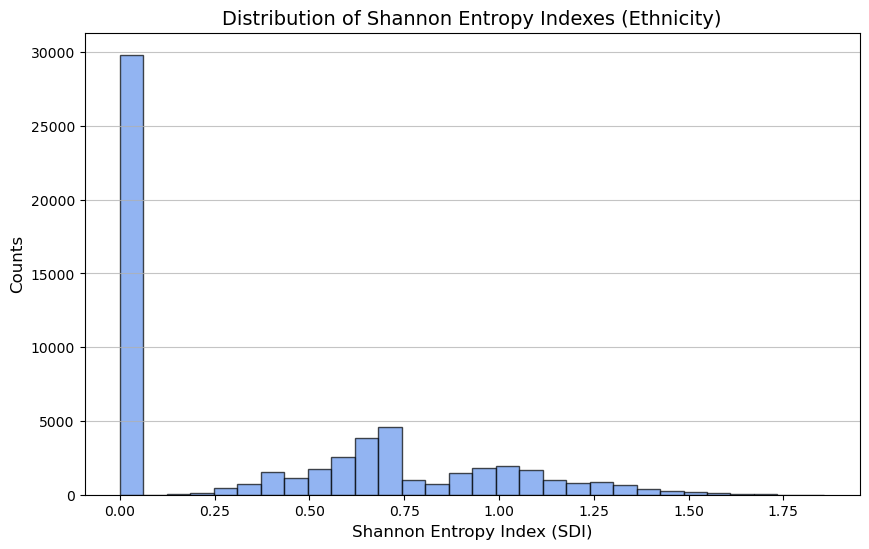

In [ ]:
# plotting the distribution of Shannon entropy indexes
plt.figure(figsize=(10, 6))
plt.hist(df_ethnicity_counts['SDI_ethnicity'], bins=30, **styles['hist_style'])
plt.title('Distribution of Shannon Entropy Indexes (Ethnicity)', fontsize=14)
plt.xlabel('Shannon Entropy Index (SDI)', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

The Shannon Entropy Index (SDI) for actors ethnicity in movies highlights a clear imbalance. From the summary statistics and distribution:

- Dominant Zero Values: A significant portion of the movies (over 50%) have an SDI of 0, meaning no ethnic diversity among the cast.
- Low Overall Mean (0.39): The average SDI remains low, indicating limited ethnic diversity across the dataset.
- Sparse Higher Values: A small subset of movies exhibit higher SDI values, reflecting greater ethnic diversity but occurring infrequently.

The distribution suggests that while some movies feature a diverse cast, the overall trend leans heavily toward minimal or no ethnic diversity.

## 4.3 - Gender score 

Preparing a similar analysis for the gender score.

In [439]:
# since we will now focus on genders, missing entries in this column must be removed
df_charac_gender = df_charac.dropna(subset=['actor_gender'])

In [ ]:
# computing occurrences of each gender per movie
gender_counts = df_charac_gender.groupby(['wikipedia_id', 'actor_gender']).size().reset_index(name='gender_count')

# computing total number of actors per movie
total_actors = df_charac_gender.groupby('wikipedia_id').size().reset_index(name='total_actors')

# merging the counts back into a single dataframe
df_gender_counts = gender_counts.merge(total_actors, on='wikipedia_id')

# computing proportions for each gender
df_gender_counts['gender_proportion'] = df_gender_counts['gender_count'] / df_gender_counts['total_actors']

df_gender_counts.head(20) 

wikipedia_id actor_gender  gender_count  total_actors  gender_proportion
0            330            F             4             4           1.000000
1           3217            F             3            13           0.230769
2           3217            M            10            13           0.769231
3           3333            F             6            15           0.400000
4           3333            M             9            15           0.600000
5           3746            F             3            14           0.214286
6           3746            M            11            14           0.785714
7           3837            F             2            20           0.100000
8           3837            M            18            20           0.900000
9           3947            F             5            15           0.333333
10          3947            M            10            15           0.666667
11          4227            F             2            10           0.200000
12          4227            M             8            10           0.800000
13          4231            F             6            16           0.375000
14          4231            M            10            16           0.625000
15          4560            F             2            15           0.133333
16          4560            M            13            15           0.866667
17          4726            F             1            11           0.090909
18          4726            M            10            11           0.909091
19          4727            F             2            21           0.095238

In [ ]:
# calculating gender SDI for each movie
df_sdi = df_gender_counts.groupby('wikipedia_id').apply(
    lambda group: characters_features.shannon_entropy(group['gender_proportion'])
).reset_index(name='SDI_gender')

# merging the SDI scores back to the original dataframe
df_gender_counts = df_gender_counts.merge(df_sdi, on='wikipedia_id')

# dropping duplicates for distribution analysis 
df_gender_counts = df_gender_counts.drop_duplicates(subset='wikipedia_id')

# displaying basic statistics
df_gender_counts["SDI_gender"].describe()

C:\Users\bosca\AppData\Local\Temp\ipykernel_17448\2832327400.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sdi = df_gender_counts.groupby('wikipedia_id').apply(


count    63652.000000
mean         0.445453
std          0.276033
min         -0.000000
25%         -0.000000
50%          0.562335
75%          0.673012
max          0.693147
Name: SDI_gender, dtype: float64

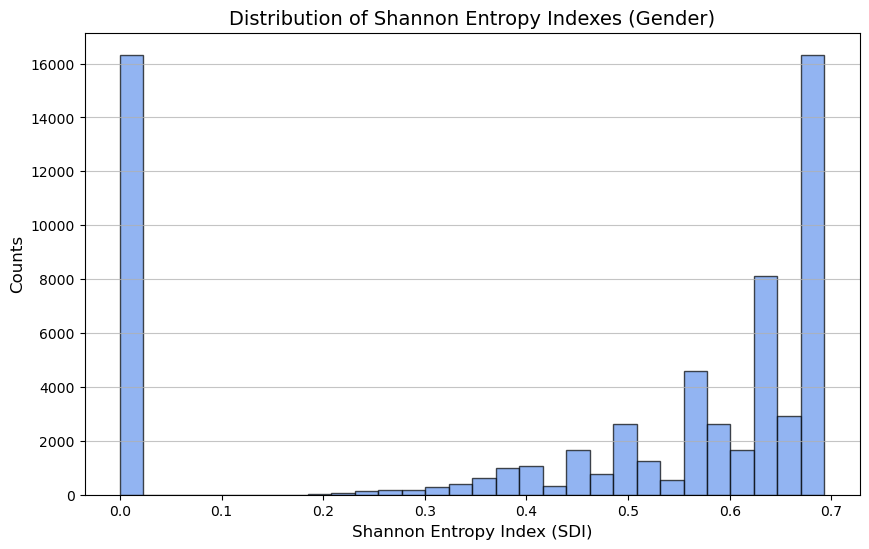

In [ ]:
# plotting the distribution of Shannon entropy indexes
plt.figure(figsize=(10, 6))
plt.hist(df_gender_counts['SDI_gender'], bins=30, **styles['hist_style'])
plt.title('Distribution of Shannon Entropy Indexes (Gender)', fontsize=14)
plt.xlabel('Shannon Entropy Index (SDI)', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

The **Shannon Entropy Index (SDI)** for gender reveals moderate diversity, with many movies showing an SDI of 0, reflecting single-gender casts, often male-dominated in reality. While the mean SDI of 0.45 indicates limited gender balance, higher values around 0.6–0.7 suggest progress in representation for some films. This aligns with ongoing industry efforts to improve gender diversity, though the persistence of imbalance highlights the slow pace of change.

## 4.4 - Shannon scores and ratings

In [443]:
# merging SDI_ethnicity
df_movies_charac_unique = df_movies_charac_unique.merge(
    df_ethnicity_counts[['wikipedia_id', 'SDI_ethnicity']],
    on='wikipedia_id',
    how='left'
)

# merging SDI_gender and GPR
df_movies_charac_unique = df_movies_charac_unique.merge(
    df_gender_counts[['wikipedia_id', 'SDI_gender']],
    on='wikipedia_id',
    how='left'
)

### 4.4.1 - SDI ethnicity and ratings

The large size of our dataset (32.621 entries) might lead to declare significant even trivial relationships. To better assess the relationship between the ethnicity score of a movie and its average rating, we will sample the unique dataframe and explore whether this yields meaningful insights.

In [ ]:
# sampling the unique dataframe
df_sampled = df_movies_charac_unique[['SDI_ethnicity', 'averageRating']].dropna().sample(n=7000, random_state=42)
df_sampled = df_sampled[['averageRating', 'SDI_ethnicity']].dropna()

# computing Pearson and Spearman correlations
pearson_corr, pearson_p = pearsonr(df_sampled['SDI_ethnicity'], df_sampled['averageRating'])
spearman_corr, spearman_p = spearmanr(df_sampled['SDI_ethnicity'], df_sampled['averageRating'])

# printing results
print(f"Pearson: Correlation = {pearson_corr:.4f}, p-value = {pearson_p:.4f}")
print(f"Spearman: Correlation = {spearman_corr:.4f}, p-value = {spearman_p:.4f}")

Pearson: Correlation = -0.0430, p-value = 0.0003
Spearman: Correlation = -0.0504, p-value = 0.0000


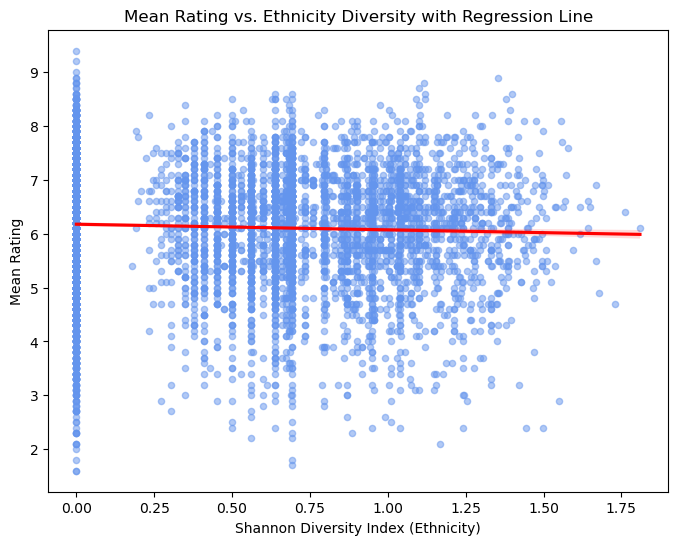

In [572]:
# scatter plot
plt.figure(figsize=(8,6))
sns.regplot(
    x='SDI_ethnicity', 
    y='averageRating', 
    data=df_sampled, 
    scatter_kws=styles['scatter_style'], 
    line_kws=styles['line_style']
)
plt.xlabel('Shannon Diversity Index (Ethnicity)')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Ethnicity Diversity with Regression Line')
plt.show()

In [573]:
# binning ethnicities into 4 groups in terms of DSI index to compare their mean ratings
bin_edges = [-0.01, 0.0, 0.5, 1.0, 2.0]
bin_labels = ["Zero", "Low", "Medium", "High"]

df_sampled['ethnicity_group'] = pd.cut(
    df_sampled['SDI_ethnicity'], 
    bins=bin_edges, 
    labels=bin_labels,
    include_lowest=True
)

# checking the distribution of the bins
print(df_sampled['ethnicity_group'].value_counts())

ethnicity_group
Zero      3045
Medium    2367
High      1041
Low        547
Name: count, dtype: int64


In [ ]:
# extracting ratings for each group to assess ANOVA p-value
group_zero = df_sampled[df_sampled['ethnicity_group'] == 'Zero']['averageRating']
group_low = df_sampled[df_sampled['ethnicity_group'] == 'Low']['averageRating']
group_medium = df_sampled[df_sampled['ethnicity_group'] == 'Medium']['averageRating']
group_high = df_sampled[df_sampled['ethnicity_group'] == 'High']['averageRating']

# f_oneway() call for ANOVA p-value
_, p_anova = f_oneway(group_zero, group_low, group_medium, group_high)
print(f"ANOVA p-value: {p_anova:.4f}")


ANOVA p-value: 0.0025


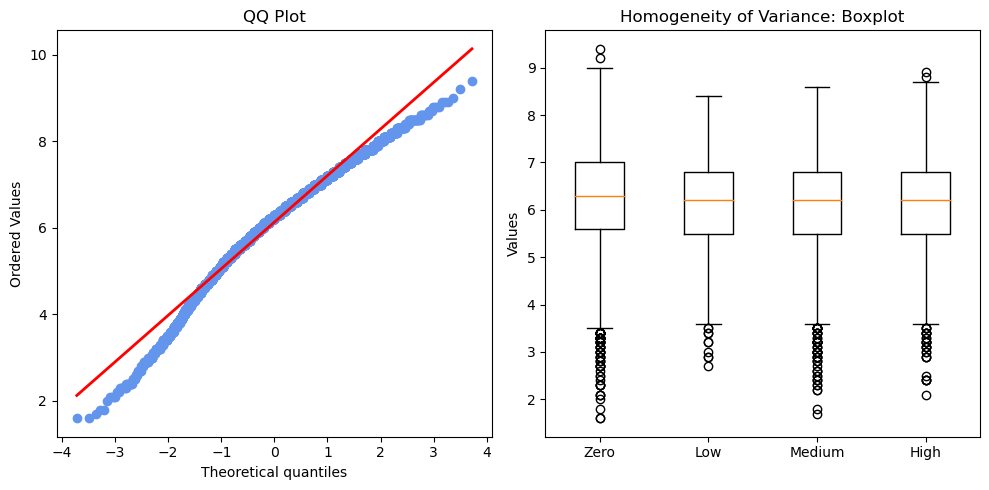

In [575]:
# combining with order all groups to prepare data for QQ plot
groups_combined = np.concatenate([group_zero, group_low, group_medium, group_high])

# preparing figure
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# QQ Plot
stats.probplot(groups_combined, dist="norm", plot=axes[0])
axes[0].set_title("QQ Plot")

# line settings
axes[0].get_lines()[0].set_color('cornflowerblue') 
axes[0].get_lines()[0].set_linewidth(2)
axes[0].get_lines()[1].set_color('red') 
axes[0].get_lines()[1].set_linewidth(2)

# boxplot for variance visualization
axes[1].boxplot([group_zero, group_low, group_medium, group_high], labels=["Zero", "Low", "Medium", "High"])
axes[1].set_title("Homogeneity of Variance: Boxplot")
axes[1].set_ylabel("Values")

plt.tight_layout()
plt.show()

The null hypothesis for ANOVA states that the mean ratings across all four ethnicity groups ("Zero," "Low," "Medium," "High") are equal. Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a significant difference in mean ratings among at least one of the groups.

### 4.4.2 - SDI gender and ratings

An equivalent approach is now adopted for the SDI gender score.

In [576]:
# sampling the unique dataframe
df_sampled = df_movies_charac_unique[['SDI_gender', 'averageRating']].dropna().sample(n=7000, random_state=42)
df_sampled = df_sampled[['averageRating', 'SDI_gender']].dropna()

# computing Pearson and Spearman correlations
pearson_corr, pearson_p = pearsonr(df_sampled['SDI_gender'], df_sampled['averageRating'])
spearman_corr, spearman_p = spearmanr(df_sampled['SDI_gender'], df_sampled['averageRating'])

# printing results
print(f"Pearson: Correlation = {pearson_corr:.4f}, p-value = {pearson_p:.4f}")
print(f"Spearman: Correlation = {spearman_corr:.4f}, p-value = {spearman_p:.4f}")

Pearson: Correlation = -0.0450, p-value = 0.0002
Spearman: Correlation = -0.0453, p-value = 0.0001


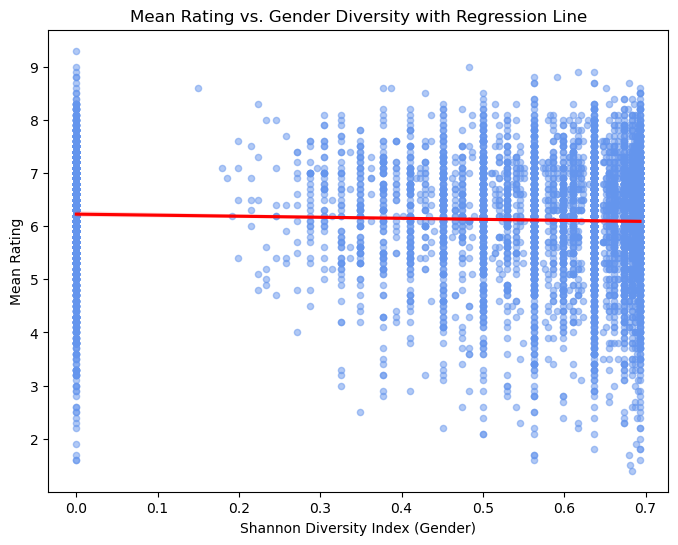

In [577]:
# scatter plot
plt.figure(figsize=(8,6))
sns.regplot(
    x='SDI_gender', 
    y='averageRating', 
    data=df_sampled, 
    scatter_kws=styles['scatter_style'], 
    line_kws=styles['line_style']
)
plt.xlabel('Shannon Diversity Index (Gender)')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Gender Diversity with Regression Line')
plt.show()

In [578]:
# splitting SDI_genders into two groups to perform ANOVA testing
group_low = df_sampled[df_sampled['SDI_gender'] <= 0.5]['averageRating']
group_high = df_sampled[df_sampled['SDI_gender'] > 0.5]['averageRating']

# f_oneway() call for ANOVA p-value
_, p_anova = f_oneway(group_low, group_high)
print(f"ANOVA p-value: {p_anova:.4f}")

ANOVA p-value: 0.0001


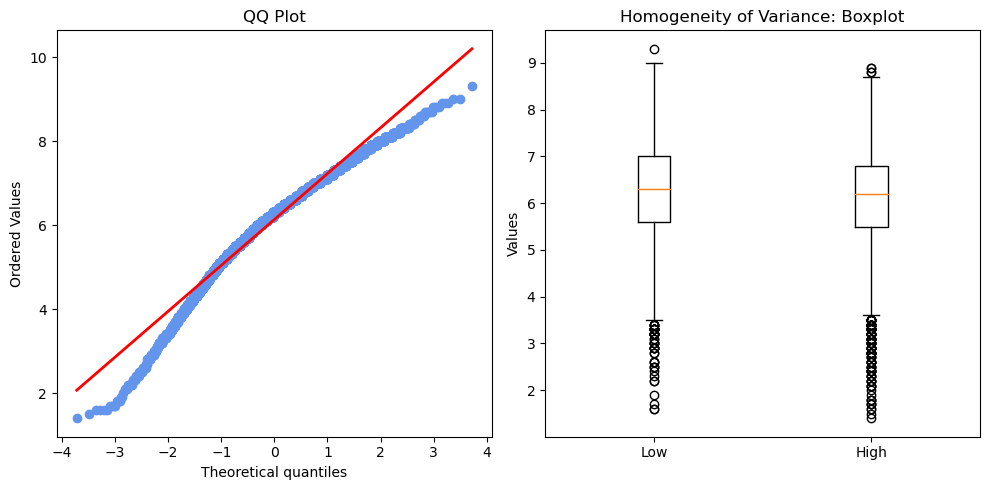

In [ ]:
# combining with order all groups to prepare data for QQ plot
groups_combined = np.concatenate([ group_low ,group_high])

# preparing figure
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# QQ Plot
stats.probplot(groups_combined, dist="norm", plot=axes[0])
axes[0].set_title("QQ Plot")

# line settings
axes[0].get_lines()[0].set_color('cornflowerblue') 
axes[0].get_lines()[0].set_linewidth(2)
axes[0].get_lines()[1].set_color('red') 
axes[0].get_lines()[1].set_linewidth(2)

# boxplot for variance visualization
axes[1].boxplot([group_low, group_high], labels=["Low", "High"])
axes[1].set_title("Homogeneity of Variance: Boxplot")
axes[1].set_ylabel("Values")

plt.tight_layout()
plt.show()

## 4.5 Number of spoken languages 

Another factor that can reflect a movie's **diversity and global appeal** is the **number of spoken languages** featured in it. Analyzing this can provide insights into how linguistic diversity might influence audience ratings.

In [580]:
# dropping rows where spoken_languages is NaN
df_movies_charac_lang = df_movies_charac_unique.dropna(subset=['spoken_languages'])

# dropping rows where spoken_languages is an empty list
df_movies_charac_lang = df_movies_charac_lang[
    df_movies_charac_lang['spoken_languages'].apply(lambda x: len(x) > 0)
]

# counting the number of languages per movie
df_movies_charac_lang['nb_languages'] = df_movies_charac_lang['spoken_languages'].apply(len)

# dropping rows with missing values in 'mean_rating' or 'nb_languages'
df_movies_charac_lang = df_movies_charac_lang.dropna(subset=['averageRating', 'nb_languages'])

In [581]:
# computing Pearson correlation
pearson_corr, pearson_p = pearsonr(df_movies_charac_lang['nb_languages'], df_movies_charac_lang['averageRating'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# computing Spearman correlation
spearman_corr, spearman_p = spearmanr(df_movies_charac_lang['nb_languages'], df_movies_charac_lang['averageRating'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

Pearson correlation: 0.0969, p-value: 0.0000
Spearman correlation: 0.0749, p-value: 0.0000


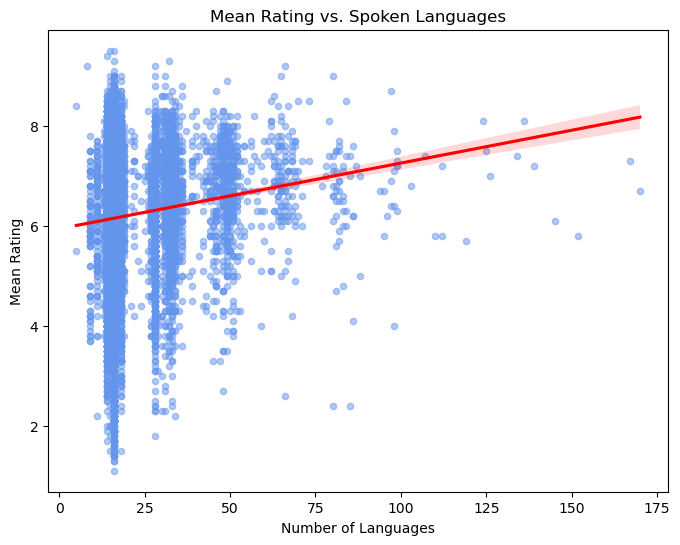

In [582]:
# scatter plot
plt.figure(figsize=(8,6))
sns.regplot(
    x='nb_languages', 
    y='averageRating', 
    data=df_movies_charac_lang, 
    scatter_kws=styles['scatter_style'], 
    line_kws=styles['line_style']
)
plt.xlabel('Number of Languages')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Spoken Languages')
plt.show()

An equivalent ANOVA analysis as the previous ones will now be performed also on this feature.

In [ ]:
# plitting nb_languages into two groups
group_low = df_movies_charac_lang[df_movies_charac_lang['nb_languages'] <= 15]['averageRating']
group_high = df_movies_charac_lang[df_movies_charac_lang['nb_languages'] > 15]['averageRating']

# f_oneway() call for ANOVA p-value
_, p_anova = f_oneway(group_low, group_high)
print(f"ANOVA p-value: {p_anova:.4f}")

ANOVA p-value: 0.0174


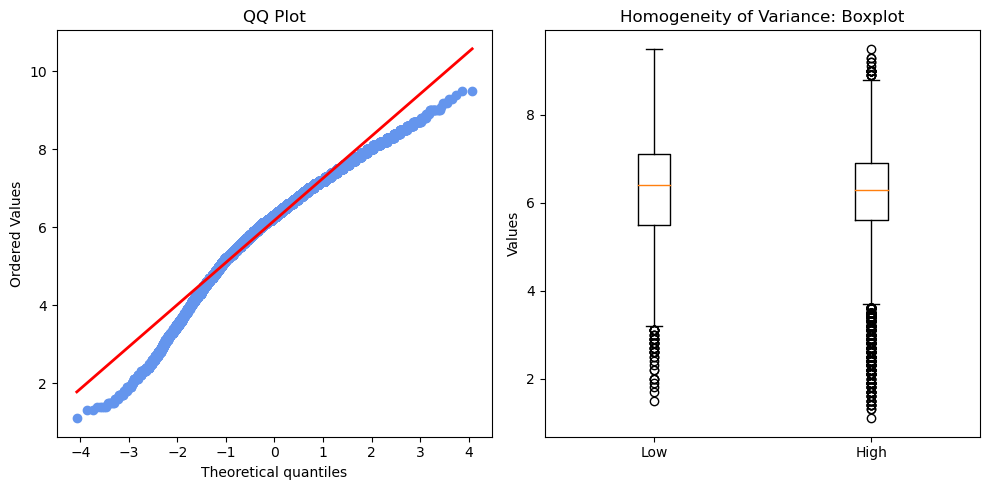

In [ ]:
# combining with order all groups to prepare data for QQ plot
groups_combined = np.concatenate([ group_low ,group_high])

# preparing figure
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# QQ Plot
stats.probplot(groups_combined, dist="norm", plot=axes[0])
axes[0].set_title("QQ Plot")

# line settings
axes[0].get_lines()[0].set_color('cornflowerblue') 
axes[0].get_lines()[0].set_linewidth(2)
axes[0].get_lines()[1].set_color('red') 
axes[0].get_lines()[1].set_linewidth(2)

# boxplot for variance visualization
axes[1].boxplot([group_low, group_high], labels=["Low", "High"])
axes[1].set_title("Homogeneity of Variance: Boxplot")
axes[1].set_ylabel("Values")

plt.tight_layout()
plt.show()

# 5 - Ratings classification

In [585]:
# copies of the master dataframes to proceed with the analysis
df_movies_model = df_movies_ratings_imdb.copy()
df_characters_model = df_characters.copy()

## 5.1 - Historical proximity score

Before proceeding with the classification model, a final interesting observation can be made. That is, how do historical events influence movies production? For this reason, a feature called `historical_proximity_score` will be defined. In particular, entries are in range [-1, 1]. Taking into account that a movie takes minimum a year to produce (in general), if a meaningful historical event happens, a score of 1 is given to the exact year of the event and the year later, then the score decreases by 0.2 each year. Therefore, an historical event has a decreasing impact on movies for the next 5 years. If the event is positive, the score is positive, viceversa if the event is negative.

In [586]:
# saving df_movies_tmdb_ratings as a pickle file
output_path = Path("src/scripts/df_movies_model.pkl")
df_movies_model.to_pickle(output_path)

# running historical_proximity.py script
result = subprocess.run(["python", "src/scripts/historical_proximity.py"], capture_output=True, text=True)

# if the script failed, print the error message
if result.returncode != 0:
    print("Error occurred:")
    print(result.stderr)
else:
    print("Script ran successfully.")

# loading historical_proximity_score
historical_proximity_score = pd.read_pickle("src/scripts/historical_proximity_score.pkl")

KeyboardInterrupt: 

In [553]:
# adding historical_proximity_score column
df_movies_model['historical_proximity_score'] = df_movies_model.apply(
    lambda row: add_features.get_historical_proximity_score(row, historical_proximity_score), axis=1
)

## 5.2 - Genre complexity score

The genre complexity score indicates how much complex the genre combination of a given movie is. Therefore, this score corresponds to number of genres for any given movie. Considering the genre explosion operation conducted during the cleaning process of the movies dataset, the score translates to the `genre_count` column of the used dataframe.

In [554]:
# grouping the data by 'genre_count' to calculate count and mean rating
complexity_stats = (
    df_movies_model.groupby('genre_count')
    .agg(count=('averageRating', 'size'), mean_rating=('averageRating', 'mean'))
    .reset_index()
)

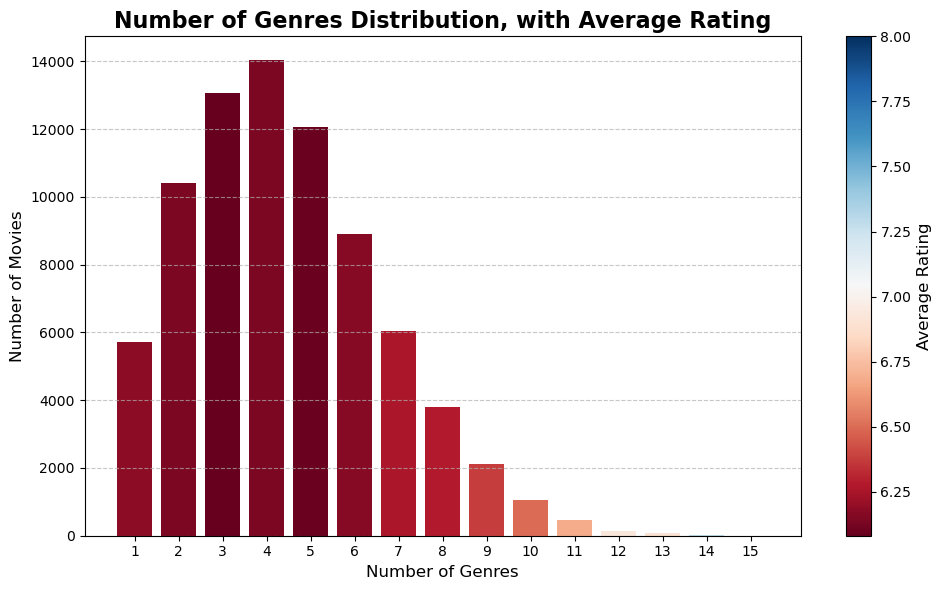

In [ ]:
# creating the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# selecting current colormap
cmap = plt.cm.RdBu
norm = plt.Normalize(complexity_stats['mean_rating'].min(), complexity_stats['mean_rating'].max())

bars = ax.bar(
    complexity_stats['genre_count'], 
    complexity_stats['count'], 
    color=[cmap(norm(rating)) for rating in complexity_stats['mean_rating']]
)

# adding color bar for the mean rating
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Average Rating", fontsize=12)

ax.set_title("Number of Genres Distribution, with Average Rating", fontsize=16, weight='bold')
ax.set_xlabel("Number of Genres", fontsize=12)
ax.set_ylabel("Number of Movies", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# changing x-axis ticks
ax.set_xticks(complexity_stats['genre_count'])
ax.set_xticklabels(complexity_stats['genre_count'].astype(int))

plt.tight_layout()
plt.show()

## 5.3 Classification model

The `df_movies_model` dataframe needs to be filled with all the needed features.

In [556]:
# adding 'nb_actors'
df_movies_model['nb_actors'] = df_movies_model['wikipedia_id'].map(actors_per_movie)

# adding 'SDI_ethnicity'
df_movies_model = df_movies_model.merge(
    df_ethnicity_counts[['wikipedia_id', 'SDI_ethnicity']],
    on='wikipedia_id',
    how='left'
)

# adding 'SDI_gender'
df_movies_model = df_movies_model.merge(
    df_gender_counts[['wikipedia_id', 'SDI_gender']],
    on='wikipedia_id',
    how='left'
)

# dropping rows where spoken_languages is nan
df_movies_model = df_movies_model.dropna(subset=['spoken_languages'])

# dropping rows where spoken_languages is an empty list
df_movies_model = df_movies_model[
    df_movies_model['spoken_languages'].apply(lambda x: len(x) > 0)
]

# adding 'nb_languages'
df_movies_model['nb_languages'] = df_movies_model['spoken_languages'].apply(len)

# adding 'binned_rating' column as the target
df_movies_model['binned_rating'] = df_movies_model['averageRating'].round()

In [ ]:
# keeping only some features and specifing the target variable
features = df_movies_model[
    [
        'release_date',
        'revenue',
        'runtime',
        'genres',
        'budget',
        'genre_count',
        'region',
        'historical_proximity_score',
        'SDI_ethnicity',
        'SDI_gender',
        'nb_actors',
        'nb_languages'
    ]
]

target = df_movies_model[['binned_rating']]

# encoding target variable to discrete classes
encoder = LabelEncoder()
target = encoder.fit_transform(target)

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [558]:
# one-hot encoding of some features that need this treatment
features = pd.get_dummies(features, columns=['release_date', 'genres', 'genre_count', 'region', 'nb_actors', 'nb_languages'], drop_first=True)

In [ ]:
# train-test split 80-20 ratio
df_train, df_test, df_train_target, df_test_target = train_test_split(
    features, 
    target, 
    test_size=0.2, 
    random_state=42
)

# printing train and test sizes
print(f'The number of samples in the train dataset is: {len(df_train)}')
print(f'The number of samples in the test dataset is: {len(df_test)}')

KeyboardInterrupt: 

In [518]:
# creating the model
random_forest = RandomForestClassifier()

# training the model
random_forest.fit(df_train, df_train_target)

# cross-validating features
scores = cross_val_score(random_forest, df_train, df_train_target, cv=10)

# computing the 95% CI (since cv=10, t-Student parameter is adopted)
SE = scores.std() / np.sqrt(10)

# t-score for 95% CI with 9 degrees of freedom (n-1, n=10)
t_score = stats.t.ppf(0.975, df=9)

# printing results
print(f"The mean accuracy is {scores.mean():.4f} ± {t_score*SE:.4f}")

c:\Users\bosca\anaconda3\envs\ada\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


KeyboardInterrupt: 

In [468]:
# prediction
target_predict = random_forest.predict(df_test)

# printing accuracy scores
accuracy = accuracy_score(df_test_target, target_predict)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.758


In [469]:
# retrieving feature importances
importances = random_forest.feature_importances_

# creating a DataFrame with feature names and importances
df_importances = pd.DataFrame({
    'Feature': features.columns,
    'Importance': importances
})

# cleaning features names
df_importances['Features'] = df_importances['Feature'].apply(cleaning.extract_category)

# grouping by the features, summing and sorting values
importances_extracted = df_importances.groupby('Features', as_index=False).agg({'Importance': 'sum'})
importances_extracted = importances_extracted.sort_values(by='Importance', ascending=False)

C:\Users\bosca\AppData\Local\Temp\ipykernel_17448\194421517.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Features', data=importances_extracted, orient='h', palette=palette)


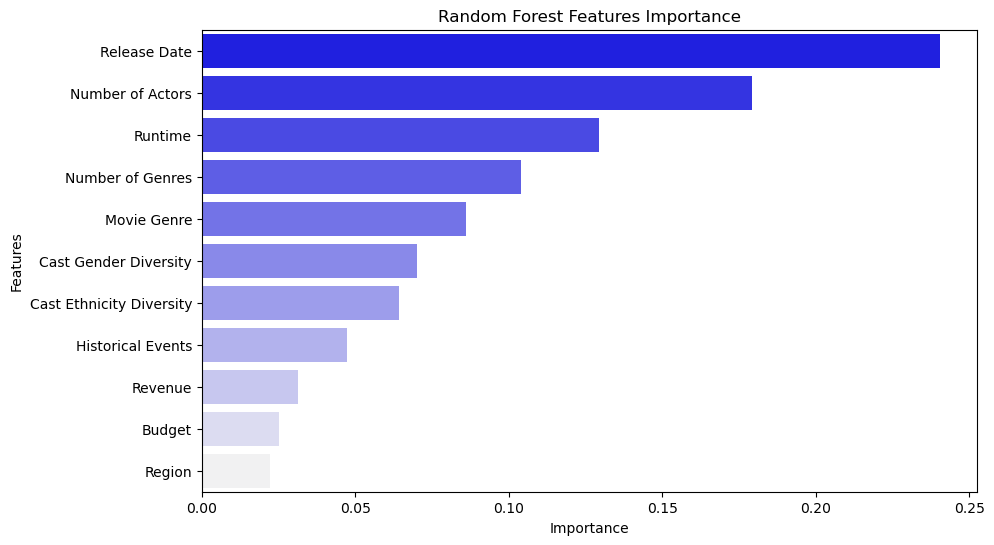

In [ ]:
# renaming the indices (features) for graph readability
importances_extracted['Features'] = ['Release Date', 'Number of Actors', 'Runtime', 'Number of Genres', 'Movie Genre', 
                            'Cast Gender Diversity', 'Cast Ethnicity Diversity', 'Historical Events', 'Revenue',
                            'Budget', 'Region']

# preparing bar plot
plt.figure(figsize=(10, 6))

# selecting color palette
palette = sns.light_palette("blue", reverse=True, n_colors=len(importances_extracted))

sns.barplot(x='Importance', y='Features', data=importances_extracted, orient='h', palette=palette)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Features Importance')
plt.show()